In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 5

***
## load and prepare data

In [4]:
!ls ../data/processed/dsv02

test.parquet  train.parquet


In [5]:
train = pd.read_parquet("../data/processed/dsv02/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
categ_feats = [
    'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 
    'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first',
    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
]
len(input_feats)

1562

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
train = train.reset_index()

train["customer_id"] = train["customer_ID"].str[-16:].apply(lambda x: int(x, 16))
train.drop("customer_ID", axis=1, inplace=True)

del train_labels
gc.collect()

118

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting':'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold")
        valid_df = dataframe.query("fold == @fold")
        
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=5000,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
            
        models.append(model)
        del train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.parquet"))

['../data/processed/cv0.parquet',
 '../data/processed/cv1.parquet',
 '../data/processed/cv2.parquet',
 '../data/processed/cv3.parquet',
 '../data/processed/cv4.parquet',
 '../data/processed/cv5.parquet',
 '../data/processed/cv6.parquet',
 '../data/processed/cv7.parquet',
 '../data/processed/cv8.parquet',
 '../data/processed/cv9.parquet']

############################### repeated cross-validation step: 1/5 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.755044	valid_0's recall_at4: 0.607633	valid_0's norm_gini: 0.902456


[100]	valid_0's amex_metric: 0.763676	valid_0's recall_at4: 0.619877	valid_0's norm_gini: 0.907475


[150]	valid_0's amex_metric: 0.769812	valid_0's recall_at4: 0.629555	valid_0's norm_gini: 0.910069


[200]	valid_0's amex_metric: 0.771029	valid_0's recall_at4: 0.630565	valid_0's norm_gini: 0.911493


[250]	valid_0's amex_metric: 0.773448	valid_0's recall_at4: 0.633636	valid_0's norm_gini: 0.913261


[300]	valid_0's amex_metric: 0.776849	valid_0's recall_at4: 0.638854	valid_0's norm_gini: 0.914845


[350]	valid_0's amex_metric: 0.778884	valid_0's recall_at4: 0.641799	valid_0's norm_gini: 0.915969


[400]	valid_0's amex_metric: 0.780298	valid_0's recall_at4: 0.643987	valid_0's norm_gini: 0.916608


[450]	valid_0's amex_metric: 0.783054	valid_0's recall_at4: 0.648363	valid_0's norm_gini: 0.917744


[500]	valid_0's amex_metric: 0.785098	valid_0's recall_at4: 0.651182	valid_0's norm_gini: 0.919014


[550]	valid_0's amex_metric: 0.786908	valid_0's recall_at4: 0.653749	valid_0's norm_gini: 0.920067


[600]	valid_0's amex_metric: 0.788486	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.920993


[650]	valid_0's amex_metric: 0.788852	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.921345


[700]	valid_0's amex_metric: 0.790136	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.921811


[750]	valid_0's amex_metric: 0.791456	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.922179


[800]	valid_0's amex_metric: 0.791615	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.922495


[850]	valid_0's amex_metric: 0.791657	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922748


[900]	valid_0's amex_metric: 0.791781	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922996


[950]	valid_0's amex_metric: 0.793192	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.923378


[1000]	valid_0's amex_metric: 0.793904	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.923709


[1050]	valid_0's amex_metric: 0.795041	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.924046


[1100]	valid_0's amex_metric: 0.795102	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924295


[1150]	valid_0's amex_metric: 0.795139	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924453


[1200]	valid_0's amex_metric: 0.795178	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924572


[1250]	valid_0's amex_metric: 0.795499	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.92471


[1300]	valid_0's amex_metric: 0.795578	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924742


[1350]	valid_0's amex_metric: 0.796215	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.92488


[1400]	valid_0's amex_metric: 0.796339	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.925043


[1450]	valid_0's amex_metric: 0.796644	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925149


[1500]	valid_0's amex_metric: 0.796791	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925231


[1550]	valid_0's amex_metric: 0.797615	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925407


[1600]	valid_0's amex_metric: 0.798139	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925487


[1650]	valid_0's amex_metric: 0.798123	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925582


[1700]	valid_0's amex_metric: 0.797982	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925637


[1750]	valid_0's amex_metric: 0.798001	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925716


[1800]	valid_0's amex_metric: 0.797856	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925763


[1850]	valid_0's amex_metric: 0.797809	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925795


[1900]	valid_0's amex_metric: 0.798253	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.925799


[1950]	valid_0's amex_metric: 0.798276	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.925804


[2000]	valid_0's amex_metric: 0.798703	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.9259


[2050]	valid_0's amex_metric: 0.799202	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.925973


[2100]	valid_0's amex_metric: 0.799067	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.92604


[2150]	valid_0's amex_metric: 0.799158	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926095


[2200]	valid_0's amex_metric: 0.798789	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926114


[2250]	valid_0's amex_metric: 0.798816	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926126


[2300]	valid_0's amex_metric: 0.799118	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926141


[2350]	valid_0's amex_metric: 0.799267	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926186


[2400]	valid_0's amex_metric: 0.799019	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926239


[2450]	valid_0's amex_metric: 0.799241	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926262


[2500]	valid_0's amex_metric: 0.799568	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926242


[2550]	valid_0's amex_metric: 0.799003	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.92629


[2600]	valid_0's amex_metric: 0.799513	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926342


[2650]	valid_0's amex_metric: 0.79948	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.926361


[2700]	valid_0's amex_metric: 0.800129	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.926395


[2750]	valid_0's amex_metric: 0.79978	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926413


[2800]	valid_0's amex_metric: 0.799842	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926453


[2850]	valid_0's amex_metric: 0.799623	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.926477


[2900]	valid_0's amex_metric: 0.799977	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926472


[2950]	valid_0's amex_metric: 0.799478	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.926483


[3000]	valid_0's amex_metric: 0.799595	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926465


[3050]	valid_0's amex_metric: 0.799843	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926498


[3100]	valid_0's amex_metric: 0.799508	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.926543


[3150]	valid_0's amex_metric: 0.799877	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926566


[3200]	valid_0's amex_metric: 0.799603	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.926564


[3250]	valid_0's amex_metric: 0.800181	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926583


[3300]	valid_0's amex_metric: 0.80008	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926593


[3350]	valid_0's amex_metric: 0.800131	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926611


[3400]	valid_0's amex_metric: 0.800414	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926629


[3450]	valid_0's amex_metric: 0.799992	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926669


[3500]	valid_0's amex_metric: 0.800192	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926649


[3550]	valid_0's amex_metric: 0.799762	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926672


[3600]	valid_0's amex_metric: 0.800201	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926666


[3650]	valid_0's amex_metric: 0.799954	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926678


[3700]	valid_0's amex_metric: 0.800123	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926679


[3750]	valid_0's amex_metric: 0.799723	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.926678


[3800]	valid_0's amex_metric: 0.799772	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926693


[3850]	valid_0's amex_metric: 0.799813	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.926689


[3900]	valid_0's amex_metric: 0.800778	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.926683


[3950]	valid_0's amex_metric: 0.799994	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926715


[4000]	valid_0's amex_metric: 0.800314	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.926725


[4050]	valid_0's amex_metric: 0.800461	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926724


[4100]	valid_0's amex_metric: 0.800128	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.92673


[4150]	valid_0's amex_metric: 0.800218	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.926743


[4200]	valid_0's amex_metric: 0.800381	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926733


[4250]	valid_0's amex_metric: 0.800059	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.92672


[4300]	valid_0's amex_metric: 0.800162	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926715


[4350]	valid_0's amex_metric: 0.800368	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926707


[4400]	valid_0's amex_metric: 0.800112	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926698


[4450]	valid_0's amex_metric: 0.80018	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926709


[4500]	valid_0's amex_metric: 0.799739	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.926709


[4550]	valid_0's amex_metric: 0.800019	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926723


[4600]	valid_0's amex_metric: 0.800212	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.92673


[4650]	valid_0's amex_metric: 0.800367	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926747


[4700]	valid_0's amex_metric: 0.800159	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926751


[4750]	valid_0's amex_metric: 0.800176	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926742


[4800]	valid_0's amex_metric: 0.799958	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926728


[4850]	valid_0's amex_metric: 0.800039	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.926721


[4900]	valid_0's amex_metric: 0.799897	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926733


[4950]	valid_0's amex_metric: 0.800049	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.926741


[5000]	valid_0's amex_metric: 0.800481	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926721


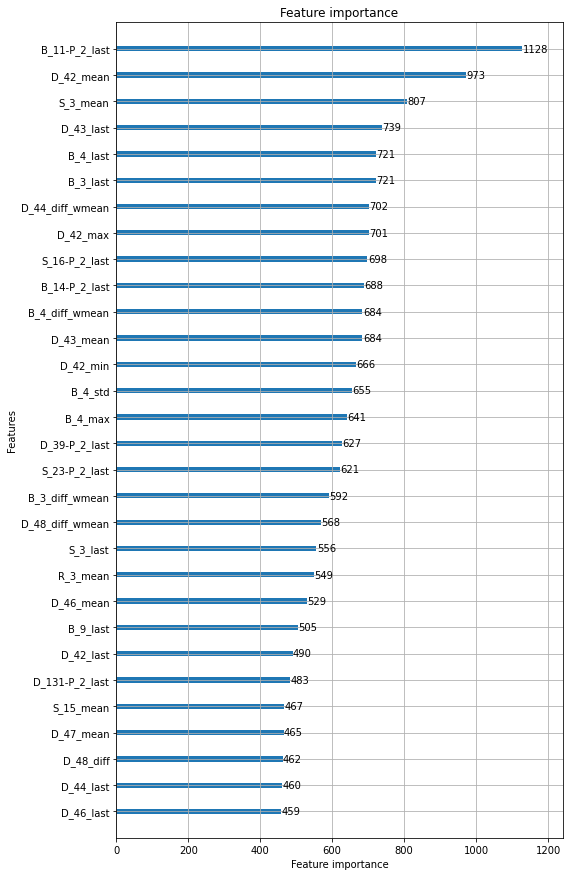

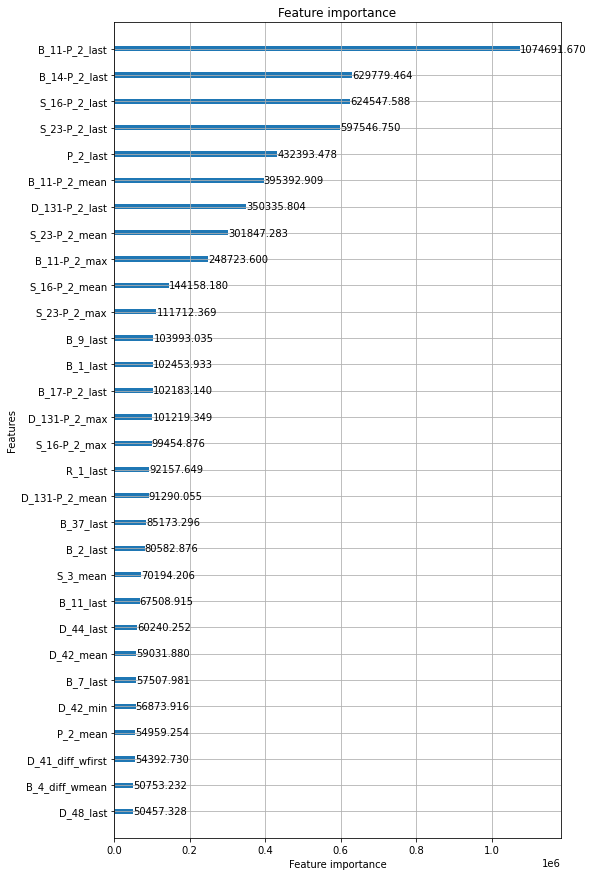

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.754058	valid_0's recall_at4: 0.606749	valid_0's norm_gini: 0.901366


[100]	valid_0's amex_metric: 0.761114	valid_0's recall_at4: 0.615585	valid_0's norm_gini: 0.906643


[150]	valid_0's amex_metric: 0.765683	valid_0's recall_at4: 0.62257	valid_0's norm_gini: 0.908795


[200]	valid_0's amex_metric: 0.767861	valid_0's recall_at4: 0.625347	valid_0's norm_gini: 0.910375


[250]	valid_0's amex_metric: 0.772021	valid_0's recall_at4: 0.631953	valid_0's norm_gini: 0.912088


[300]	valid_0's amex_metric: 0.774066	valid_0's recall_at4: 0.634478	valid_0's norm_gini: 0.913654


[350]	valid_0's amex_metric: 0.775561	valid_0's recall_at4: 0.636413	valid_0's norm_gini: 0.914709


[400]	valid_0's amex_metric: 0.777028	valid_0's recall_at4: 0.638601	valid_0's norm_gini: 0.915454


[450]	valid_0's amex_metric: 0.778907	valid_0's recall_at4: 0.64121	valid_0's norm_gini: 0.916605


[500]	valid_0's amex_metric: 0.78119	valid_0's recall_at4: 0.644534	valid_0's norm_gini: 0.917845


[550]	valid_0's amex_metric: 0.784742	valid_0's recall_at4: 0.650635	valid_0's norm_gini: 0.918849


[600]	valid_0's amex_metric: 0.787571	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.919751


[650]	valid_0's amex_metric: 0.787298	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.920174


[700]	valid_0's amex_metric: 0.787881	valid_0's recall_at4: 0.655096	valid_0's norm_gini: 0.920667


[750]	valid_0's amex_metric: 0.788878	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.92102


[800]	valid_0's amex_metric: 0.789404	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.921356


[850]	valid_0's amex_metric: 0.78949	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.921654


[900]	valid_0's amex_metric: 0.79018	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.921941


[950]	valid_0's amex_metric: 0.790766	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.922313


[1000]	valid_0's amex_metric: 0.791603	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922641


[1050]	valid_0's amex_metric: 0.792214	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.92302


[1100]	valid_0's amex_metric: 0.793497	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.92323


[1150]	valid_0's amex_metric: 0.794004	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.923403


[1200]	valid_0's amex_metric: 0.793899	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.92353


[1250]	valid_0's amex_metric: 0.794227	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.923723


[1300]	valid_0's amex_metric: 0.79428	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923786


[1350]	valid_0's amex_metric: 0.794878	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.923889


[1400]	valid_0's amex_metric: 0.795369	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924072


[1450]	valid_0's amex_metric: 0.795495	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.92424


[1500]	valid_0's amex_metric: 0.795795	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.924334


[1550]	valid_0's amex_metric: 0.796168	valid_0's recall_at4: 0.667845	valid_0's norm_gini: 0.924491


[1600]	valid_0's amex_metric: 0.795927	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.924598


[1650]	valid_0's amex_metric: 0.796099	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.92469


[1700]	valid_0's amex_metric: 0.796031	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.924764


[1750]	valid_0's amex_metric: 0.796094	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.924847


[1800]	valid_0's amex_metric: 0.796233	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.924916


[1850]	valid_0's amex_metric: 0.796384	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925007


[1900]	valid_0's amex_metric: 0.796644	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.925065


[1950]	valid_0's amex_metric: 0.796754	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.925115


[2000]	valid_0's amex_metric: 0.797334	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925183


[2050]	valid_0's amex_metric: 0.797121	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.925302


[2100]	valid_0's amex_metric: 0.798065	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.925382


[2150]	valid_0's amex_metric: 0.798068	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925472


[2200]	valid_0's amex_metric: 0.797726	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925502


[2250]	valid_0's amex_metric: 0.797826	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.925534


[2300]	valid_0's amex_metric: 0.797583	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.925554


[2350]	valid_0's amex_metric: 0.797929	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925615


[2400]	valid_0's amex_metric: 0.797822	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925652


[2450]	valid_0's amex_metric: 0.797836	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925681


[2500]	valid_0's amex_metric: 0.797654	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.925697


[2550]	valid_0's amex_metric: 0.797899	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925723


[2600]	valid_0's amex_metric: 0.798276	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925762


[2650]	valid_0's amex_metric: 0.798375	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925791


[2700]	valid_0's amex_metric: 0.798452	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925819


[2750]	valid_0's amex_metric: 0.798349	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925824


[2800]	valid_0's amex_metric: 0.797495	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925841


[2850]	valid_0's amex_metric: 0.798054	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925906


[2900]	valid_0's amex_metric: 0.797812	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.925929


[2950]	valid_0's amex_metric: 0.797919	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925932


[3000]	valid_0's amex_metric: 0.798363	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925935


[3050]	valid_0's amex_metric: 0.798127	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925969


[3100]	valid_0's amex_metric: 0.798591	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.925972


[3150]	valid_0's amex_metric: 0.798431	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925987


[3200]	valid_0's amex_metric: 0.798252	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.926009


[3250]	valid_0's amex_metric: 0.798782	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926058


[3300]	valid_0's amex_metric: 0.798463	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.926094


[3350]	valid_0's amex_metric: 0.798545	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.926089


[3400]	valid_0's amex_metric: 0.798146	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.92609


[3450]	valid_0's amex_metric: 0.798365	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.926108


[3500]	valid_0's amex_metric: 0.798321	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.926103


[3550]	valid_0's amex_metric: 0.798394	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926124


[3600]	valid_0's amex_metric: 0.798919	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926122


[3650]	valid_0's amex_metric: 0.797824	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.926121


[3700]	valid_0's amex_metric: 0.798806	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926106


[3750]	valid_0's amex_metric: 0.798489	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926103


[3800]	valid_0's amex_metric: 0.799078	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926146


[3850]	valid_0's amex_metric: 0.799097	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926184


[3900]	valid_0's amex_metric: 0.798906	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.92618


[3950]	valid_0's amex_metric: 0.798755	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.926173


[4000]	valid_0's amex_metric: 0.798711	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.926169


[4050]	valid_0's amex_metric: 0.799207	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926193


[4100]	valid_0's amex_metric: 0.799696	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926203


[4150]	valid_0's amex_metric: 0.799416	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.926191


[4200]	valid_0's amex_metric: 0.798953	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926189


[4250]	valid_0's amex_metric: 0.799487	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.926163


[4300]	valid_0's amex_metric: 0.799053	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926179


[4350]	valid_0's amex_metric: 0.798845	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926185


[4400]	valid_0's amex_metric: 0.798432	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.9262


[4450]	valid_0's amex_metric: 0.798661	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.926196


[4500]	valid_0's amex_metric: 0.798558	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.926199


[4550]	valid_0's amex_metric: 0.798784	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.92619


[4600]	valid_0's amex_metric: 0.799202	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926183


[4650]	valid_0's amex_metric: 0.798956	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926196


[4700]	valid_0's amex_metric: 0.798992	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926184


[4750]	valid_0's amex_metric: 0.798871	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.926194


[4800]	valid_0's amex_metric: 0.798641	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.926197


[4850]	valid_0's amex_metric: 0.798849	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926192


[4900]	valid_0's amex_metric: 0.799205	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926189


[4950]	valid_0's amex_metric: 0.799432	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.92618


[5000]	valid_0's amex_metric: 0.799317	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.926161


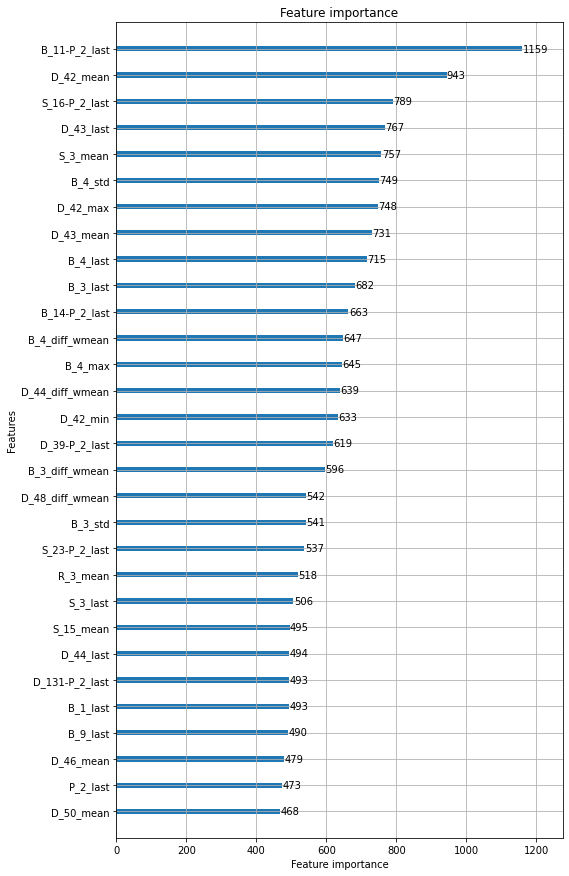

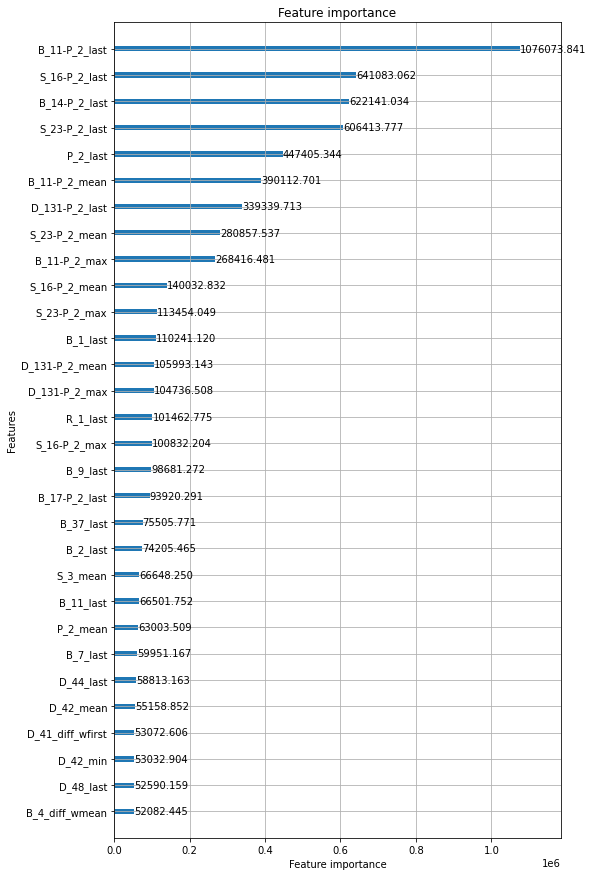

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.748023	valid_0's recall_at4: 0.595388	valid_0's norm_gini: 0.900658


[100]	valid_0's amex_metric: 0.757468	valid_0's recall_at4: 0.609148	valid_0's norm_gini: 0.905789


[150]	valid_0's amex_metric: 0.760682	valid_0's recall_at4: 0.613187	valid_0's norm_gini: 0.908178


[200]	valid_0's amex_metric: 0.762721	valid_0's recall_at4: 0.616006	valid_0's norm_gini: 0.909436


[250]	valid_0's amex_metric: 0.766919	valid_0's recall_at4: 0.622654	valid_0's norm_gini: 0.911185


[300]	valid_0's amex_metric: 0.76978	valid_0's recall_at4: 0.626904	valid_0's norm_gini: 0.912656


[350]	valid_0's amex_metric: 0.771675	valid_0's recall_at4: 0.629639	valid_0's norm_gini: 0.913712


[400]	valid_0's amex_metric: 0.771728	valid_0's recall_at4: 0.629218	valid_0's norm_gini: 0.914239


[450]	valid_0's amex_metric: 0.774096	valid_0's recall_at4: 0.632753	valid_0's norm_gini: 0.91544


[500]	valid_0's amex_metric: 0.777155	valid_0's recall_at4: 0.63776	valid_0's norm_gini: 0.916551


[550]	valid_0's amex_metric: 0.779804	valid_0's recall_at4: 0.642052	valid_0's norm_gini: 0.917555


[600]	valid_0's amex_metric: 0.781042	valid_0's recall_at4: 0.643609	valid_0's norm_gini: 0.918475


[650]	valid_0's amex_metric: 0.781585	valid_0's recall_at4: 0.644282	valid_0's norm_gini: 0.918889


[700]	valid_0's amex_metric: 0.782776	valid_0's recall_at4: 0.646133	valid_0's norm_gini: 0.919419


[750]	valid_0's amex_metric: 0.783301	valid_0's recall_at4: 0.646848	valid_0's norm_gini: 0.919754


[800]	valid_0's amex_metric: 0.783712	valid_0's recall_at4: 0.647353	valid_0's norm_gini: 0.920071


[850]	valid_0's amex_metric: 0.784821	valid_0's recall_at4: 0.649247	valid_0's norm_gini: 0.920396


[900]	valid_0's amex_metric: 0.784976	valid_0's recall_at4: 0.649247	valid_0's norm_gini: 0.920705


[950]	valid_0's amex_metric: 0.785316	valid_0's recall_at4: 0.649626	valid_0's norm_gini: 0.921007


[1000]	valid_0's amex_metric: 0.786454	valid_0's recall_at4: 0.651645	valid_0's norm_gini: 0.921263


[1050]	valid_0's amex_metric: 0.786411	valid_0's recall_at4: 0.651224	valid_0's norm_gini: 0.921597


[1100]	valid_0's amex_metric: 0.787411	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.921831


[1150]	valid_0's amex_metric: 0.78795	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.922025


[1200]	valid_0's amex_metric: 0.788123	valid_0's recall_at4: 0.654086	valid_0's norm_gini: 0.922161


[1250]	valid_0's amex_metric: 0.788742	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.922305


[1300]	valid_0's amex_metric: 0.788846	valid_0's recall_at4: 0.655348	valid_0's norm_gini: 0.922343


[1350]	valid_0's amex_metric: 0.789232	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.922443


[1400]	valid_0's amex_metric: 0.789048	valid_0's recall_at4: 0.655516	valid_0's norm_gini: 0.92258


[1450]	valid_0's amex_metric: 0.788877	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.9227


[1500]	valid_0's amex_metric: 0.78898	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.92278


[1550]	valid_0's amex_metric: 0.789	valid_0's recall_at4: 0.655096	valid_0's norm_gini: 0.922905


[1600]	valid_0's amex_metric: 0.789053	valid_0's recall_at4: 0.655096	valid_0's norm_gini: 0.923011


[1650]	valid_0's amex_metric: 0.789304	valid_0's recall_at4: 0.655516	valid_0's norm_gini: 0.923091


[1700]	valid_0's amex_metric: 0.789441	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.923155


[1750]	valid_0's amex_metric: 0.78943	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.923218


[1800]	valid_0's amex_metric: 0.789845	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.92329


[1850]	valid_0's amex_metric: 0.790051	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.923324


[1900]	valid_0's amex_metric: 0.790334	valid_0's recall_at4: 0.657283	valid_0's norm_gini: 0.923384


[1950]	valid_0's amex_metric: 0.790605	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923422


[2000]	valid_0's amex_metric: 0.790356	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.923513


[2050]	valid_0's amex_metric: 0.790765	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.923615


[2100]	valid_0's amex_metric: 0.790798	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.923681


[2150]	valid_0's amex_metric: 0.791063	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.923748


[2200]	valid_0's amex_metric: 0.791173	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.923799


[2250]	valid_0's amex_metric: 0.790818	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923847


[2300]	valid_0's amex_metric: 0.790962	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.923842


[2350]	valid_0's amex_metric: 0.791055	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.923858


[2400]	valid_0's amex_metric: 0.791187	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.923871


[2450]	valid_0's amex_metric: 0.79086	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923931


[2500]	valid_0's amex_metric: 0.790633	valid_0's recall_at4: 0.657283	valid_0's norm_gini: 0.923983


[2550]	valid_0's amex_metric: 0.790793	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.924008


[2600]	valid_0's amex_metric: 0.790578	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.923998


[2650]	valid_0's amex_metric: 0.790901	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.924014


[2700]	valid_0's amex_metric: 0.790212	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.924067


[2750]	valid_0's amex_metric: 0.789984	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.924116


[2800]	valid_0's amex_metric: 0.790292	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.924141


[2850]	valid_0's amex_metric: 0.790431	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.924168


[2900]	valid_0's amex_metric: 0.790496	valid_0's recall_at4: 0.656821	valid_0's norm_gini: 0.924171


[2950]	valid_0's amex_metric: 0.790601	valid_0's recall_at4: 0.657031	valid_0's norm_gini: 0.924171


[3000]	valid_0's amex_metric: 0.791116	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.924191


[3050]	valid_0's amex_metric: 0.791104	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.924251


[3100]	valid_0's amex_metric: 0.791112	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.924267


[3150]	valid_0's amex_metric: 0.791152	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.924263


[3200]	valid_0's amex_metric: 0.791165	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.924289


[3250]	valid_0's amex_metric: 0.791781	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.924343


[3300]	valid_0's amex_metric: 0.791785	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.924351


[3350]	valid_0's amex_metric: 0.791854	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.924362


[3400]	valid_0's amex_metric: 0.791572	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.924346


[3450]	valid_0's amex_metric: 0.791692	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.924375


[3500]	valid_0's amex_metric: 0.791552	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.92439


[3550]	valid_0's amex_metric: 0.791646	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.924409


[3600]	valid_0's amex_metric: 0.791648	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.924414


[3650]	valid_0's amex_metric: 0.792018	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.924437


[3700]	valid_0's amex_metric: 0.791957	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.924443


[3750]	valid_0's amex_metric: 0.791957	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.924443


[3800]	valid_0's amex_metric: 0.791812	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.924447


[3850]	valid_0's amex_metric: 0.79207	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.924459


[3900]	valid_0's amex_metric: 0.79197	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.924468


[3950]	valid_0's amex_metric: 0.792108	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924492


[4000]	valid_0's amex_metric: 0.791995	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.924518


[4050]	valid_0's amex_metric: 0.792133	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924542


[4100]	valid_0's amex_metric: 0.792103	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.924566


[4150]	valid_0's amex_metric: 0.792634	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.924576


[4200]	valid_0's amex_metric: 0.792651	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.92461


[4250]	valid_0's amex_metric: 0.79254	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.924599


[4300]	valid_0's amex_metric: 0.792934	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.92463


[4350]	valid_0's amex_metric: 0.792867	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.924622


[4400]	valid_0's amex_metric: 0.792894	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.924633


[4450]	valid_0's amex_metric: 0.792571	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.924618


[4500]	valid_0's amex_metric: 0.793201	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924616


[4550]	valid_0's amex_metric: 0.793424	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924599


[4600]	valid_0's amex_metric: 0.793665	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.924576


[4650]	valid_0's amex_metric: 0.793693	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.924549


[4700]	valid_0's amex_metric: 0.793158	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924531


[4750]	valid_0's amex_metric: 0.792555	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.924545


[4800]	valid_0's amex_metric: 0.79321	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.92455


[4850]	valid_0's amex_metric: 0.793255	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.924556


[4900]	valid_0's amex_metric: 0.793175	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924563


[4950]	valid_0's amex_metric: 0.793047	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.92456


[5000]	valid_0's amex_metric: 0.793215	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.924559


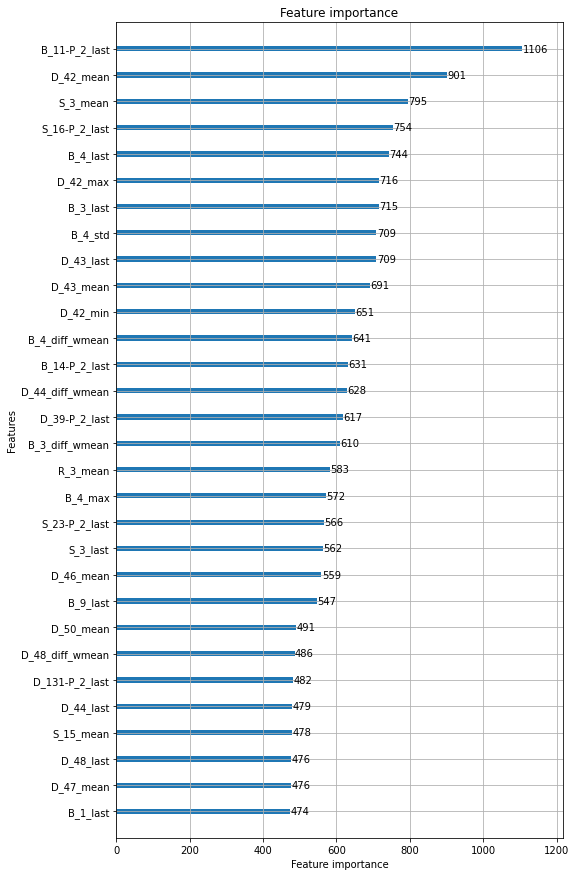

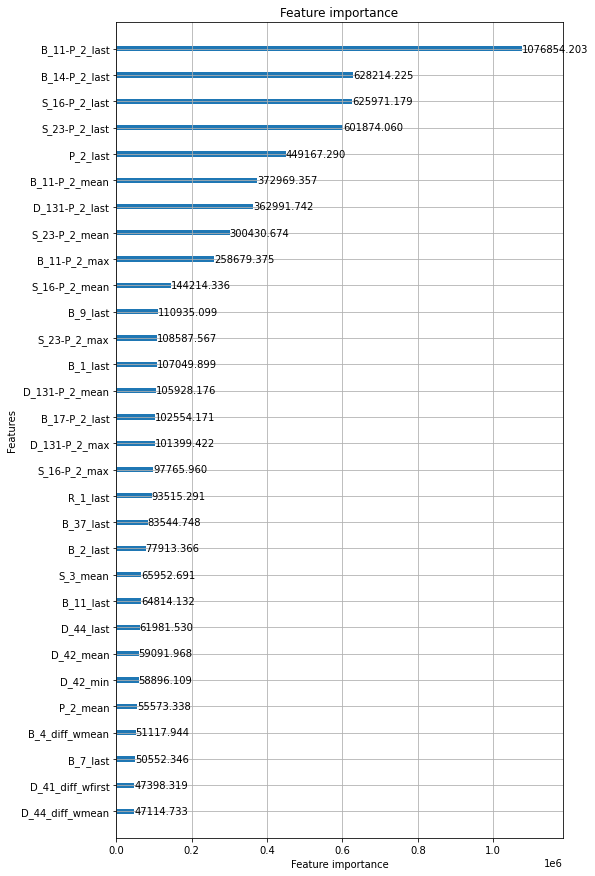

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.749367	valid_0's recall_at4: 0.598527	valid_0's norm_gini: 0.900207


[100]	valid_0's amex_metric: 0.757337	valid_0's recall_at4: 0.609089	valid_0's norm_gini: 0.905584


[150]	valid_0's amex_metric: 0.762349	valid_0's recall_at4: 0.616916	valid_0's norm_gini: 0.907782


[200]	valid_0's amex_metric: 0.765402	valid_0's recall_at4: 0.621544	valid_0's norm_gini: 0.90926


[250]	valid_0's amex_metric: 0.76722	valid_0's recall_at4: 0.623564	valid_0's norm_gini: 0.910876


[300]	valid_0's amex_metric: 0.770929	valid_0's recall_at4: 0.629371	valid_0's norm_gini: 0.912487


[350]	valid_0's amex_metric: 0.77321	valid_0's recall_at4: 0.632821	valid_0's norm_gini: 0.913598


[400]	valid_0's amex_metric: 0.774331	valid_0's recall_at4: 0.634462	valid_0's norm_gini: 0.9142


[450]	valid_0's amex_metric: 0.776231	valid_0's recall_at4: 0.637071	valid_0's norm_gini: 0.91539


[500]	valid_0's amex_metric: 0.777682	valid_0's recall_at4: 0.638712	valid_0's norm_gini: 0.916652


[550]	valid_0's amex_metric: 0.779371	valid_0's recall_at4: 0.641027	valid_0's norm_gini: 0.917716


[600]	valid_0's amex_metric: 0.78118	valid_0's recall_at4: 0.643762	valid_0's norm_gini: 0.918598


[650]	valid_0's amex_metric: 0.781399	valid_0's recall_at4: 0.643762	valid_0's norm_gini: 0.919037


[700]	valid_0's amex_metric: 0.782262	valid_0's recall_at4: 0.644982	valid_0's norm_gini: 0.919542


[750]	valid_0's amex_metric: 0.782418	valid_0's recall_at4: 0.644982	valid_0's norm_gini: 0.919854


[800]	valid_0's amex_metric: 0.783252	valid_0's recall_at4: 0.646287	valid_0's norm_gini: 0.920216


[850]	valid_0's amex_metric: 0.783521	valid_0's recall_at4: 0.646581	valid_0's norm_gini: 0.920462


[900]	valid_0's amex_metric: 0.78461	valid_0's recall_at4: 0.648433	valid_0's norm_gini: 0.920787


[950]	valid_0's amex_metric: 0.785666	valid_0's recall_at4: 0.650158	valid_0's norm_gini: 0.921175


[1000]	valid_0's amex_metric: 0.786344	valid_0's recall_at4: 0.651168	valid_0's norm_gini: 0.921519


[1050]	valid_0's amex_metric: 0.786404	valid_0's recall_at4: 0.650915	valid_0's norm_gini: 0.921893


[1100]	valid_0's amex_metric: 0.786491	valid_0's recall_at4: 0.650831	valid_0's norm_gini: 0.92215


[1150]	valid_0's amex_metric: 0.786842	valid_0's recall_at4: 0.651336	valid_0's norm_gini: 0.922348


[1200]	valid_0's amex_metric: 0.78706	valid_0's recall_at4: 0.651631	valid_0's norm_gini: 0.922489


[1250]	valid_0's amex_metric: 0.786601	valid_0's recall_at4: 0.650494	valid_0's norm_gini: 0.922707


[1300]	valid_0's amex_metric: 0.786954	valid_0's recall_at4: 0.651126	valid_0's norm_gini: 0.922783


[1350]	valid_0's amex_metric: 0.787017	valid_0's recall_at4: 0.651126	valid_0's norm_gini: 0.922909


[1400]	valid_0's amex_metric: 0.787298	valid_0's recall_at4: 0.651504	valid_0's norm_gini: 0.923093


[1450]	valid_0's amex_metric: 0.788123	valid_0's recall_at4: 0.653019	valid_0's norm_gini: 0.923227


[1500]	valid_0's amex_metric: 0.788666	valid_0's recall_at4: 0.653987	valid_0's norm_gini: 0.923345


[1550]	valid_0's amex_metric: 0.788062	valid_0's recall_at4: 0.652598	valid_0's norm_gini: 0.923525


[1600]	valid_0's amex_metric: 0.788329	valid_0's recall_at4: 0.653019	valid_0's norm_gini: 0.923638


[1650]	valid_0's amex_metric: 0.788561	valid_0's recall_at4: 0.653398	valid_0's norm_gini: 0.923724


[1700]	valid_0's amex_metric: 0.78875	valid_0's recall_at4: 0.65365	valid_0's norm_gini: 0.92385


[1750]	valid_0's amex_metric: 0.788731	valid_0's recall_at4: 0.653524	valid_0's norm_gini: 0.923937


[1800]	valid_0's amex_metric: 0.789133	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.924027


[1850]	valid_0's amex_metric: 0.78915	valid_0's recall_at4: 0.654197	valid_0's norm_gini: 0.924103


[1900]	valid_0's amex_metric: 0.789255	valid_0's recall_at4: 0.654366	valid_0's norm_gini: 0.924144


[1950]	valid_0's amex_metric: 0.789558	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.924204


[2000]	valid_0's amex_metric: 0.788694	valid_0's recall_at4: 0.653103	valid_0's norm_gini: 0.924285


[2050]	valid_0's amex_metric: 0.789842	valid_0's recall_at4: 0.655291	valid_0's norm_gini: 0.924392


[2100]	valid_0's amex_metric: 0.789783	valid_0's recall_at4: 0.655081	valid_0's norm_gini: 0.924485


[2150]	valid_0's amex_metric: 0.790068	valid_0's recall_at4: 0.655586	valid_0's norm_gini: 0.924551


[2200]	valid_0's amex_metric: 0.790226	valid_0's recall_at4: 0.655838	valid_0's norm_gini: 0.924614


[2250]	valid_0's amex_metric: 0.789656	valid_0's recall_at4: 0.65466	valid_0's norm_gini: 0.924652


[2300]	valid_0's amex_metric: 0.790054	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.924649


[2350]	valid_0's amex_metric: 0.790114	valid_0's recall_at4: 0.655544	valid_0's norm_gini: 0.924685


[2400]	valid_0's amex_metric: 0.789705	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.924707


[2450]	valid_0's amex_metric: 0.790089	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.924719


[2500]	valid_0's amex_metric: 0.790129	valid_0's recall_at4: 0.655502	valid_0's norm_gini: 0.924756


[2550]	valid_0's amex_metric: 0.790465	valid_0's recall_at4: 0.656133	valid_0's norm_gini: 0.924797


[2600]	valid_0's amex_metric: 0.790596	valid_0's recall_at4: 0.656343	valid_0's norm_gini: 0.924848


[2650]	valid_0's amex_metric: 0.790631	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.924877


[2700]	valid_0's amex_metric: 0.790512	valid_0's recall_at4: 0.656091	valid_0's norm_gini: 0.924934


[2750]	valid_0's amex_metric: 0.790356	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.924957


[2800]	valid_0's amex_metric: 0.790044	valid_0's recall_at4: 0.655123	valid_0's norm_gini: 0.924965


[2850]	valid_0's amex_metric: 0.789885	valid_0's recall_at4: 0.654786	valid_0's norm_gini: 0.924983


[2900]	valid_0's amex_metric: 0.790081	valid_0's recall_at4: 0.655165	valid_0's norm_gini: 0.924996


[2950]	valid_0's amex_metric: 0.790113	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.925019


[3000]	valid_0's amex_metric: 0.789849	valid_0's recall_at4: 0.65466	valid_0's norm_gini: 0.925039


[3050]	valid_0's amex_metric: 0.790207	valid_0's recall_at4: 0.655376	valid_0's norm_gini: 0.925038


[3100]	valid_0's amex_metric: 0.789952	valid_0's recall_at4: 0.654871	valid_0's norm_gini: 0.925033


[3150]	valid_0's amex_metric: 0.789911	valid_0's recall_at4: 0.654744	valid_0's norm_gini: 0.925077


[3200]	valid_0's amex_metric: 0.790048	valid_0's recall_at4: 0.654997	valid_0's norm_gini: 0.9251


[3250]	valid_0's amex_metric: 0.790157	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.925108


[3300]	valid_0's amex_metric: 0.789911	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.925119


[3350]	valid_0's amex_metric: 0.790087	valid_0's recall_at4: 0.655039	valid_0's norm_gini: 0.925136


[3400]	valid_0's amex_metric: 0.790379	valid_0's recall_at4: 0.655628	valid_0's norm_gini: 0.92513


[3450]	valid_0's amex_metric: 0.790702	valid_0's recall_at4: 0.656259	valid_0's norm_gini: 0.925145


[3500]	valid_0's amex_metric: 0.790752	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.925119


[3550]	valid_0's amex_metric: 0.79084	valid_0's recall_at4: 0.656554	valid_0's norm_gini: 0.925127


[3600]	valid_0's amex_metric: 0.790813	valid_0's recall_at4: 0.656512	valid_0's norm_gini: 0.925114


[3650]	valid_0's amex_metric: 0.790757	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.925128


[3700]	valid_0's amex_metric: 0.79115	valid_0's recall_at4: 0.657143	valid_0's norm_gini: 0.925156


[3750]	valid_0's amex_metric: 0.791093	valid_0's recall_at4: 0.657059	valid_0's norm_gini: 0.925128


[3800]	valid_0's amex_metric: 0.791361	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.925158


[3850]	valid_0's amex_metric: 0.791338	valid_0's recall_at4: 0.657522	valid_0's norm_gini: 0.925155


[3900]	valid_0's amex_metric: 0.791773	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.92514


[3950]	valid_0's amex_metric: 0.791179	valid_0's recall_at4: 0.657185	valid_0's norm_gini: 0.925173


[4000]	valid_0's amex_metric: 0.791314	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.925191


[4050]	valid_0's amex_metric: 0.791763	valid_0's recall_at4: 0.658321	valid_0's norm_gini: 0.925205


[4100]	valid_0's amex_metric: 0.791173	valid_0's recall_at4: 0.657143	valid_0's norm_gini: 0.925203


[4150]	valid_0's amex_metric: 0.791296	valid_0's recall_at4: 0.657395	valid_0's norm_gini: 0.925197


[4200]	valid_0's amex_metric: 0.790708	valid_0's recall_at4: 0.656217	valid_0's norm_gini: 0.925199


[4250]	valid_0's amex_metric: 0.79054	valid_0's recall_at4: 0.655881	valid_0's norm_gini: 0.9252


[4300]	valid_0's amex_metric: 0.791222	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.925217


[4350]	valid_0's amex_metric: 0.790612	valid_0's recall_at4: 0.656007	valid_0's norm_gini: 0.925218


[4400]	valid_0's amex_metric: 0.791053	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.925258


[4450]	valid_0's amex_metric: 0.791033	valid_0's recall_at4: 0.656806	valid_0's norm_gini: 0.92526


[4500]	valid_0's amex_metric: 0.790931	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.925266


[4550]	valid_0's amex_metric: 0.791358	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.925278


[4600]	valid_0's amex_metric: 0.791696	valid_0's recall_at4: 0.658111	valid_0's norm_gini: 0.925281


[4650]	valid_0's amex_metric: 0.791274	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.925279


[4700]	valid_0's amex_metric: 0.791224	valid_0's recall_at4: 0.657185	valid_0's norm_gini: 0.925263


[4750]	valid_0's amex_metric: 0.791633	valid_0's recall_at4: 0.657984	valid_0's norm_gini: 0.925282


[4800]	valid_0's amex_metric: 0.791487	valid_0's recall_at4: 0.65769	valid_0's norm_gini: 0.925285


[4850]	valid_0's amex_metric: 0.791388	valid_0's recall_at4: 0.657479	valid_0's norm_gini: 0.925296


[4900]	valid_0's amex_metric: 0.791466	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.925284


[4950]	valid_0's amex_metric: 0.791514	valid_0's recall_at4: 0.657774	valid_0's norm_gini: 0.925254


[5000]	valid_0's amex_metric: 0.791632	valid_0's recall_at4: 0.658027	valid_0's norm_gini: 0.925238


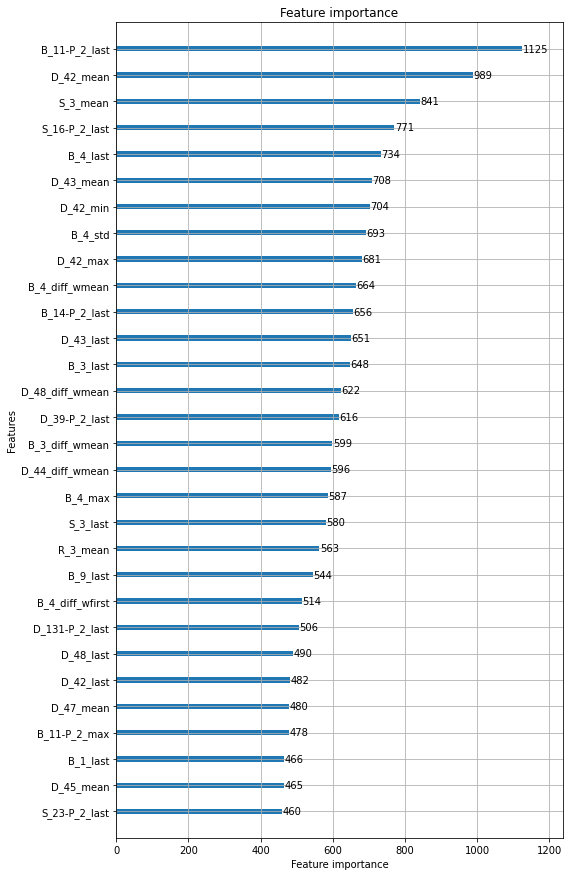

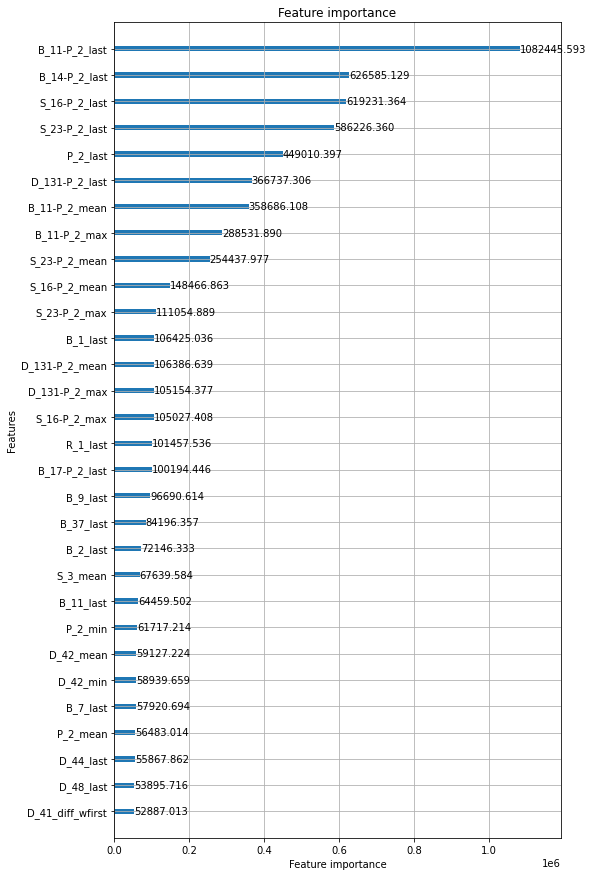

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.757825	valid_0's recall_at4: 0.611656	valid_0's norm_gini: 0.903994


[100]	valid_0's amex_metric: 0.765247	valid_0's recall_at4: 0.621544	valid_0's norm_gini: 0.90895


[150]	valid_0's amex_metric: 0.769103	valid_0's recall_at4: 0.62693	valid_0's norm_gini: 0.911276


[200]	valid_0's amex_metric: 0.771808	valid_0's recall_at4: 0.631054	valid_0's norm_gini: 0.912562


[250]	valid_0's amex_metric: 0.775876	valid_0's recall_at4: 0.63724	valid_0's norm_gini: 0.914512


[300]	valid_0's amex_metric: 0.777958	valid_0's recall_at4: 0.639933	valid_0's norm_gini: 0.915984


[350]	valid_0's amex_metric: 0.779474	valid_0's recall_at4: 0.641868	valid_0's norm_gini: 0.917079


[400]	valid_0's amex_metric: 0.780656	valid_0's recall_at4: 0.643551	valid_0's norm_gini: 0.917761


[450]	valid_0's amex_metric: 0.783475	valid_0's recall_at4: 0.648138	valid_0's norm_gini: 0.918813


[500]	valid_0's amex_metric: 0.785297	valid_0's recall_at4: 0.650536	valid_0's norm_gini: 0.920057


[550]	valid_0's amex_metric: 0.787963	valid_0's recall_at4: 0.654871	valid_0's norm_gini: 0.921056


[600]	valid_0's amex_metric: 0.789571	valid_0's recall_at4: 0.657185	valid_0's norm_gini: 0.921957


[650]	valid_0's amex_metric: 0.790501	valid_0's recall_at4: 0.658658	valid_0's norm_gini: 0.922345


[700]	valid_0's amex_metric: 0.791396	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.922831


[750]	valid_0's amex_metric: 0.791699	valid_0's recall_at4: 0.660215	valid_0's norm_gini: 0.923184


[800]	valid_0's amex_metric: 0.792175	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.923546


[850]	valid_0's amex_metric: 0.792976	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.923802


[900]	valid_0's amex_metric: 0.793623	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.924128


[950]	valid_0's amex_metric: 0.794604	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924534


[1000]	valid_0's amex_metric: 0.795274	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.924778


[1050]	valid_0's amex_metric: 0.795811	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925137


[1100]	valid_0's amex_metric: 0.796299	valid_0's recall_at4: 0.667242	valid_0's norm_gini: 0.925357


[1150]	valid_0's amex_metric: 0.796793	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.925503


[1200]	valid_0's amex_metric: 0.796595	valid_0's recall_at4: 0.667578	valid_0's norm_gini: 0.925611


[1250]	valid_0's amex_metric: 0.79636	valid_0's recall_at4: 0.666947	valid_0's norm_gini: 0.925773


[1300]	valid_0's amex_metric: 0.796957	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.92583


[1350]	valid_0's amex_metric: 0.796884	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.925936


[1400]	valid_0's amex_metric: 0.797557	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.926104


[1450]	valid_0's amex_metric: 0.797942	valid_0's recall_at4: 0.669682	valid_0's norm_gini: 0.926202


[1500]	valid_0's amex_metric: 0.798855	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.926303


[1550]	valid_0's amex_metric: 0.798776	valid_0's recall_at4: 0.671113	valid_0's norm_gini: 0.926439


[1600]	valid_0's amex_metric: 0.798865	valid_0's recall_at4: 0.671197	valid_0's norm_gini: 0.926532


[1650]	valid_0's amex_metric: 0.799252	valid_0's recall_at4: 0.67187	valid_0's norm_gini: 0.926634


[1700]	valid_0's amex_metric: 0.799181	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.926702


[1750]	valid_0's amex_metric: 0.799585	valid_0's recall_at4: 0.672375	valid_0's norm_gini: 0.926795


[1800]	valid_0's amex_metric: 0.799661	valid_0's recall_at4: 0.672459	valid_0's norm_gini: 0.926863


[1850]	valid_0's amex_metric: 0.800007	valid_0's recall_at4: 0.673049	valid_0's norm_gini: 0.926966


[1900]	valid_0's amex_metric: 0.800173	valid_0's recall_at4: 0.673343	valid_0's norm_gini: 0.927003


[1950]	valid_0's amex_metric: 0.80004	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.927074


[2000]	valid_0's amex_metric: 0.800195	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.927172


[2050]	valid_0's amex_metric: 0.800418	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.92724


[2100]	valid_0's amex_metric: 0.800352	valid_0's recall_at4: 0.673385	valid_0's norm_gini: 0.927318


[2150]	valid_0's amex_metric: 0.800728	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.927398


[2200]	valid_0's amex_metric: 0.801059	valid_0's recall_at4: 0.674648	valid_0's norm_gini: 0.927471


[2250]	valid_0's amex_metric: 0.801277	valid_0's recall_at4: 0.675068	valid_0's norm_gini: 0.927487


[2300]	valid_0's amex_metric: 0.80188	valid_0's recall_at4: 0.676247	valid_0's norm_gini: 0.927513


[2350]	valid_0's amex_metric: 0.801813	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.927548


[2400]	valid_0's amex_metric: 0.802159	valid_0's recall_at4: 0.676752	valid_0's norm_gini: 0.927566


[2450]	valid_0's amex_metric: 0.801866	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.927612


[2500]	valid_0's amex_metric: 0.802075	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.92761


[2550]	valid_0's amex_metric: 0.801767	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.927625


[2600]	valid_0's amex_metric: 0.802242	valid_0's recall_at4: 0.676836	valid_0's norm_gini: 0.927648


[2650]	valid_0's amex_metric: 0.80215	valid_0's recall_at4: 0.676625	valid_0's norm_gini: 0.927675


[2700]	valid_0's amex_metric: 0.802054	valid_0's recall_at4: 0.676415	valid_0's norm_gini: 0.927693


[2750]	valid_0's amex_metric: 0.80186	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.927727


[2800]	valid_0's amex_metric: 0.801807	valid_0's recall_at4: 0.675868	valid_0's norm_gini: 0.927747


[2850]	valid_0's amex_metric: 0.801381	valid_0's recall_at4: 0.674984	valid_0's norm_gini: 0.927777


[2900]	valid_0's amex_metric: 0.801672	valid_0's recall_at4: 0.675531	valid_0's norm_gini: 0.927813


[2950]	valid_0's amex_metric: 0.801987	valid_0's recall_at4: 0.676162	valid_0's norm_gini: 0.927811


[3000]	valid_0's amex_metric: 0.801401	valid_0's recall_at4: 0.674984	valid_0's norm_gini: 0.927818


[3050]	valid_0's amex_metric: 0.80132	valid_0's recall_at4: 0.674816	valid_0's norm_gini: 0.927823


[3100]	valid_0's amex_metric: 0.801621	valid_0's recall_at4: 0.675405	valid_0's norm_gini: 0.927838


[3150]	valid_0's amex_metric: 0.802058	valid_0's recall_at4: 0.676289	valid_0's norm_gini: 0.927827


[3200]	valid_0's amex_metric: 0.802251	valid_0's recall_at4: 0.676667	valid_0's norm_gini: 0.927834


[3250]	valid_0's amex_metric: 0.802225	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.927867


[3300]	valid_0's amex_metric: 0.802405	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.927889


[3350]	valid_0's amex_metric: 0.802085	valid_0's recall_at4: 0.676289	valid_0's norm_gini: 0.927882


[3400]	valid_0's amex_metric: 0.80227	valid_0's recall_at4: 0.676667	valid_0's norm_gini: 0.927874


[3450]	valid_0's amex_metric: 0.802345	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927895


[3500]	valid_0's amex_metric: 0.802805	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.927891


[3550]	valid_0's amex_metric: 0.802423	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.927883


[3600]	valid_0's amex_metric: 0.80185	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.927874


[3650]	valid_0's amex_metric: 0.801536	valid_0's recall_at4: 0.675195	valid_0's norm_gini: 0.927877


[3700]	valid_0's amex_metric: 0.80209	valid_0's recall_at4: 0.676289	valid_0's norm_gini: 0.927892


[3750]	valid_0's amex_metric: 0.802451	valid_0's recall_at4: 0.677004	valid_0's norm_gini: 0.927899


[3800]	valid_0's amex_metric: 0.801982	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.927885


[3850]	valid_0's amex_metric: 0.801876	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.927926


[3900]	valid_0's amex_metric: 0.802101	valid_0's recall_at4: 0.676289	valid_0's norm_gini: 0.927912


[3950]	valid_0's amex_metric: 0.802404	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.92793


[4000]	valid_0's amex_metric: 0.802682	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927939


[4050]	valid_0's amex_metric: 0.802239	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927936


[4100]	valid_0's amex_metric: 0.802076	valid_0's recall_at4: 0.676205	valid_0's norm_gini: 0.927947


[4150]	valid_0's amex_metric: 0.802162	valid_0's recall_at4: 0.676373	valid_0's norm_gini: 0.927952


[4200]	valid_0's amex_metric: 0.802378	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927963


[4250]	valid_0's amex_metric: 0.802593	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.927972


[4300]	valid_0's amex_metric: 0.802047	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.927974


[4350]	valid_0's amex_metric: 0.802445	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.92797


[4400]	valid_0's amex_metric: 0.802162	valid_0's recall_at4: 0.676373	valid_0's norm_gini: 0.927951


[4450]	valid_0's amex_metric: 0.801858	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.927974


[4500]	valid_0's amex_metric: 0.802281	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.927978


[4550]	valid_0's amex_metric: 0.802168	valid_0's recall_at4: 0.676373	valid_0's norm_gini: 0.927962


[4600]	valid_0's amex_metric: 0.802481	valid_0's recall_at4: 0.677004	valid_0's norm_gini: 0.927959


[4650]	valid_0's amex_metric: 0.80216	valid_0's recall_at4: 0.676373	valid_0's norm_gini: 0.927947


[4700]	valid_0's amex_metric: 0.801988	valid_0's recall_at4: 0.676036	valid_0's norm_gini: 0.92794


[4750]	valid_0's amex_metric: 0.802591	valid_0's recall_at4: 0.677256	valid_0's norm_gini: 0.927927


[4800]	valid_0's amex_metric: 0.80257	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.927926


[4850]	valid_0's amex_metric: 0.802667	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927909


[4900]	valid_0's amex_metric: 0.80273	valid_0's recall_at4: 0.677551	valid_0's norm_gini: 0.92791


[4950]	valid_0's amex_metric: 0.80243	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.927898


[5000]	valid_0's amex_metric: 0.802897	valid_0's recall_at4: 0.677888	valid_0's norm_gini: 0.927906


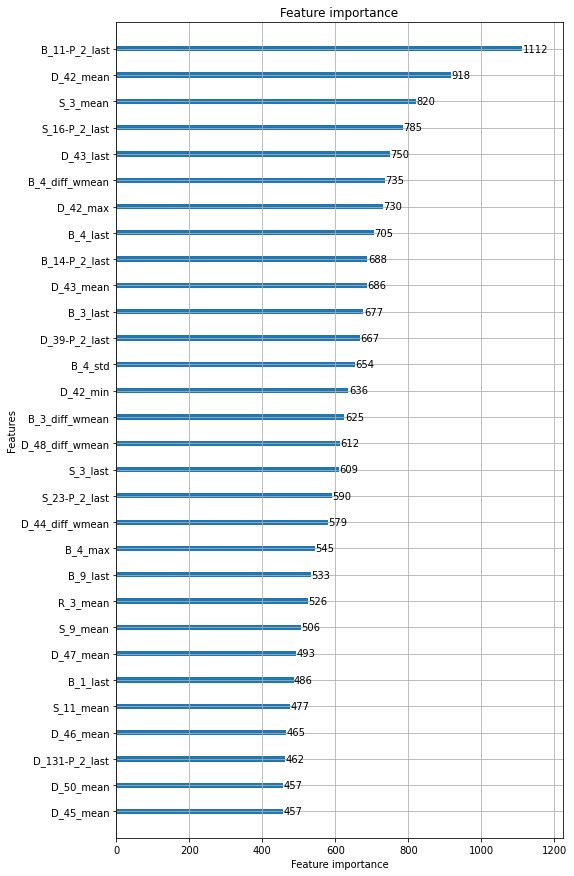

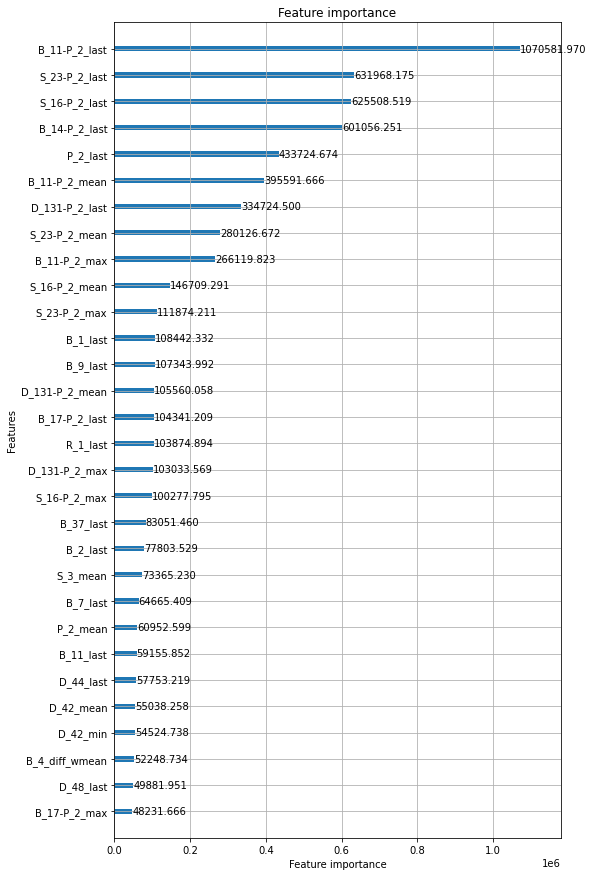

Training time: 124.01013604005178 min.
OOF recall_at4: 0.6685124718079913
OOF normalized_gini: 0.9256586883260924
OOF competition metric: 0.7970855800670419
Finished CV repeat 0 in: 124.0 min.


############################### repeated cross-validation step: 2/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.755309	valid_0's recall_at4: 0.608222	valid_0's norm_gini: 0.902396


[100]	valid_0's amex_metric: 0.763177	valid_0's recall_at4: 0.618741	valid_0's norm_gini: 0.907613


[150]	valid_0's amex_metric: 0.768482	valid_0's recall_at4: 0.627114	valid_0's norm_gini: 0.90985


[200]	valid_0's amex_metric: 0.771845	valid_0's recall_at4: 0.63229	valid_0's norm_gini: 0.911401


[250]	valid_0's amex_metric: 0.775444	valid_0's recall_at4: 0.637676	valid_0's norm_gini: 0.913212


[300]	valid_0's amex_metric: 0.778087	valid_0's recall_at4: 0.641463	valid_0's norm_gini: 0.914711


[350]	valid_0's amex_metric: 0.778731	valid_0's recall_at4: 0.641757	valid_0's norm_gini: 0.915705


[400]	valid_0's amex_metric: 0.780229	valid_0's recall_at4: 0.643987	valid_0's norm_gini: 0.916472


[450]	valid_0's amex_metric: 0.781999	valid_0's recall_at4: 0.646428	valid_0's norm_gini: 0.91757


[500]	valid_0's amex_metric: 0.784659	valid_0's recall_at4: 0.650467	valid_0's norm_gini: 0.918852


[550]	valid_0's amex_metric: 0.786942	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.919841


[600]	valid_0's amex_metric: 0.790013	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.920807


[650]	valid_0's amex_metric: 0.790799	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.921285


[700]	valid_0's amex_metric: 0.791375	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.921807


[750]	valid_0's amex_metric: 0.791158	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.922128


[800]	valid_0's amex_metric: 0.791358	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.922444


[850]	valid_0's amex_metric: 0.792043	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.922721


[900]	valid_0's amex_metric: 0.792639	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.92303


[950]	valid_0's amex_metric: 0.792946	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.923391


[1000]	valid_0's amex_metric: 0.79388	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.923701


[1050]	valid_0's amex_metric: 0.794722	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.924081


[1100]	valid_0's amex_metric: 0.795114	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924361


[1150]	valid_0's amex_metric: 0.796336	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.924575


[1200]	valid_0's amex_metric: 0.796809	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.924679


[1250]	valid_0's amex_metric: 0.796492	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.924845


[1300]	valid_0's amex_metric: 0.79618	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.924894


[1350]	valid_0's amex_metric: 0.79606	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924991


[1400]	valid_0's amex_metric: 0.796624	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.92515


[1450]	valid_0's amex_metric: 0.797374	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925263


[1500]	valid_0's amex_metric: 0.797377	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925353


[1550]	valid_0's amex_metric: 0.797667	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925512


[1600]	valid_0's amex_metric: 0.797419	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.925605


[1650]	valid_0's amex_metric: 0.797355	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.925688


[1700]	valid_0's amex_metric: 0.797454	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925759


[1750]	valid_0's amex_metric: 0.796928	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925842


[1800]	valid_0's amex_metric: 0.797656	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925868


[1850]	valid_0's amex_metric: 0.79788	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925937


[1900]	valid_0's amex_metric: 0.797616	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.925956


[1950]	valid_0's amex_metric: 0.797699	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925997


[2000]	valid_0's amex_metric: 0.798658	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.926105


[2050]	valid_0's amex_metric: 0.798206	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.926169


[2100]	valid_0's amex_metric: 0.798868	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926231


[2150]	valid_0's amex_metric: 0.799022	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926285


[2200]	valid_0's amex_metric: 0.799816	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926317


[2250]	valid_0's amex_metric: 0.80028	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926362


[2300]	valid_0's amex_metric: 0.800411	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.926371


[2350]	valid_0's amex_metric: 0.800251	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.926387


[2400]	valid_0's amex_metric: 0.800234	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926437


[2450]	valid_0's amex_metric: 0.800359	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926477


[2500]	valid_0's amex_metric: 0.800101	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.926509


[2550]	valid_0's amex_metric: 0.799844	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926542


[2600]	valid_0's amex_metric: 0.799991	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926583


[2650]	valid_0's amex_metric: 0.800104	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926598


[2700]	valid_0's amex_metric: 0.800392	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926628


[2750]	valid_0's amex_metric: 0.80029	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.926675


[2800]	valid_0's amex_metric: 0.799897	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.926689


[2850]	valid_0's amex_metric: 0.80037	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926709


[2900]	valid_0's amex_metric: 0.799971	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.92667


[2950]	valid_0's amex_metric: 0.799594	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926674


[3000]	valid_0's amex_metric: 0.799907	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926668


[3050]	valid_0's amex_metric: 0.799529	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.92671


[3100]	valid_0's amex_metric: 0.799565	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926741


[3150]	valid_0's amex_metric: 0.799898	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926734


[3200]	valid_0's amex_metric: 0.799962	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926735


[3250]	valid_0's amex_metric: 0.800161	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926755


[3300]	valid_0's amex_metric: 0.799991	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926752


[3350]	valid_0's amex_metric: 0.799609	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.926745


[3400]	valid_0's amex_metric: 0.800395	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.92676


[3450]	valid_0's amex_metric: 0.800762	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926779


[3500]	valid_0's amex_metric: 0.800389	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.92679


[3550]	valid_0's amex_metric: 0.800543	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926804


[3600]	valid_0's amex_metric: 0.799998	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926808


[3650]	valid_0's amex_metric: 0.799578	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.92681


[3700]	valid_0's amex_metric: 0.799594	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926798


[3750]	valid_0's amex_metric: 0.80031	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.926801


[3800]	valid_0's amex_metric: 0.800158	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926791


[3850]	valid_0's amex_metric: 0.800696	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926814


[3900]	valid_0's amex_metric: 0.800386	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926826


[3950]	valid_0's amex_metric: 0.800002	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926816


[4000]	valid_0's amex_metric: 0.799988	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926829


[4050]	valid_0's amex_metric: 0.800123	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926847


[4100]	valid_0's amex_metric: 0.799995	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926843


[4150]	valid_0's amex_metric: 0.799317	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926834


[4200]	valid_0's amex_metric: 0.799595	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926844


[4250]	valid_0's amex_metric: 0.799492	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926847


[4300]	valid_0's amex_metric: 0.799614	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926838


[4350]	valid_0's amex_metric: 0.799216	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.926843


[4400]	valid_0's amex_metric: 0.799806	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.926843


[4450]	valid_0's amex_metric: 0.800006	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926866


[4500]	valid_0's amex_metric: 0.799781	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926879


[4550]	valid_0's amex_metric: 0.799901	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.926866


[4600]	valid_0's amex_metric: 0.799959	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926855


[4650]	valid_0's amex_metric: 0.799912	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.926846


[4700]	valid_0's amex_metric: 0.799877	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926859


[4750]	valid_0's amex_metric: 0.800184	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926842


[4800]	valid_0's amex_metric: 0.79947	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926845


[4850]	valid_0's amex_metric: 0.799328	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.926814


[4900]	valid_0's amex_metric: 0.799525	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926828


[4950]	valid_0's amex_metric: 0.799775	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926824


[5000]	valid_0's amex_metric: 0.799812	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.926813


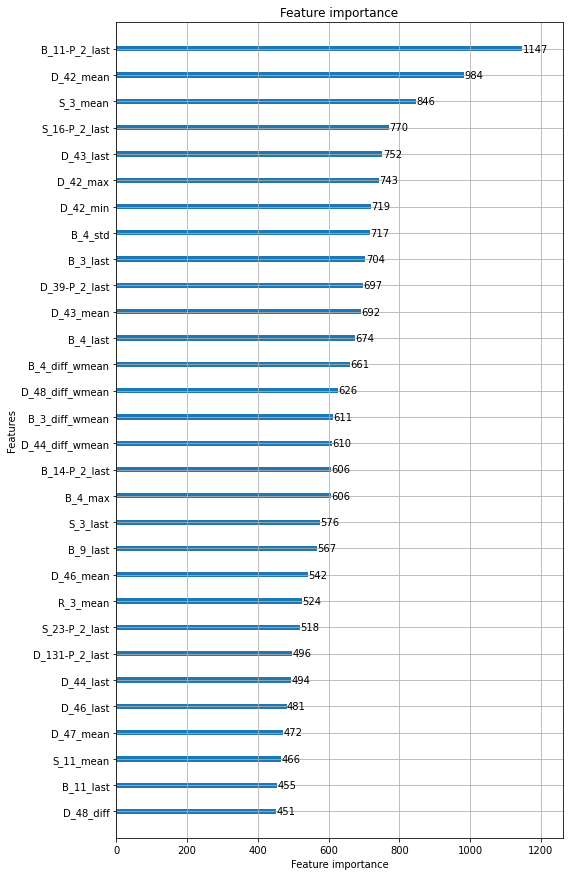

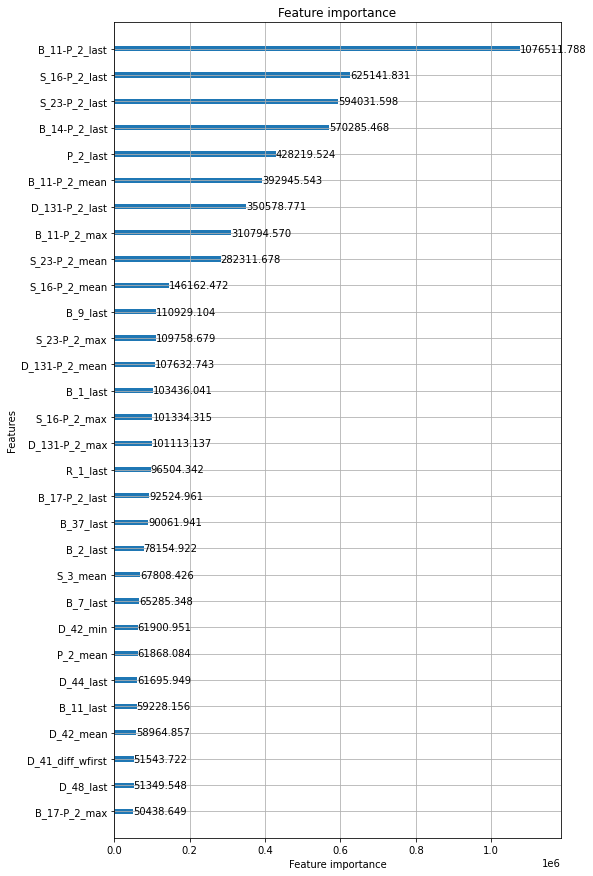

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.75071	valid_0's recall_at4: 0.600017	valid_0's norm_gini: 0.901403


[100]	valid_0's amex_metric: 0.759102	valid_0's recall_at4: 0.611756	valid_0's norm_gini: 0.906447


[150]	valid_0's amex_metric: 0.762827	valid_0's recall_at4: 0.616848	valid_0's norm_gini: 0.908807


[200]	valid_0's amex_metric: 0.765112	valid_0's recall_at4: 0.620088	valid_0's norm_gini: 0.910137


[250]	valid_0's amex_metric: 0.769369	valid_0's recall_at4: 0.626694	valid_0's norm_gini: 0.912045


[300]	valid_0's amex_metric: 0.771504	valid_0's recall_at4: 0.629429	valid_0's norm_gini: 0.913579


[350]	valid_0's amex_metric: 0.773685	valid_0's recall_at4: 0.632795	valid_0's norm_gini: 0.914575


[400]	valid_0's amex_metric: 0.774386	valid_0's recall_at4: 0.633426	valid_0's norm_gini: 0.915346


[450]	valid_0's amex_metric: 0.776719	valid_0's recall_at4: 0.637087	valid_0's norm_gini: 0.916351


[500]	valid_0's amex_metric: 0.779562	valid_0's recall_at4: 0.641547	valid_0's norm_gini: 0.917578


[550]	valid_0's amex_metric: 0.780314	valid_0's recall_at4: 0.642094	valid_0's norm_gini: 0.918533


[600]	valid_0's amex_metric: 0.781956	valid_0's recall_at4: 0.644492	valid_0's norm_gini: 0.91942


[650]	valid_0's amex_metric: 0.783399	valid_0's recall_at4: 0.646975	valid_0's norm_gini: 0.919823


[700]	valid_0's amex_metric: 0.784216	valid_0's recall_at4: 0.648111	valid_0's norm_gini: 0.920321


[750]	valid_0's amex_metric: 0.784537	valid_0's recall_at4: 0.648447	valid_0's norm_gini: 0.920628


[800]	valid_0's amex_metric: 0.785294	valid_0's recall_at4: 0.649626	valid_0's norm_gini: 0.920962


[850]	valid_0's amex_metric: 0.785395	valid_0's recall_at4: 0.649541	valid_0's norm_gini: 0.921248


[900]	valid_0's amex_metric: 0.786069	valid_0's recall_at4: 0.650635	valid_0's norm_gini: 0.921502


[950]	valid_0's amex_metric: 0.786843	valid_0's recall_at4: 0.651898	valid_0's norm_gini: 0.921789


[1000]	valid_0's amex_metric: 0.787693	valid_0's recall_at4: 0.653286	valid_0's norm_gini: 0.9221


[1050]	valid_0's amex_metric: 0.787982	valid_0's recall_at4: 0.653497	valid_0's norm_gini: 0.922467


[1100]	valid_0's amex_metric: 0.789374	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.922685


[1150]	valid_0's amex_metric: 0.789596	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.922876


[1200]	valid_0's amex_metric: 0.789761	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.923038


[1250]	valid_0's amex_metric: 0.791131	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.92321


[1300]	valid_0's amex_metric: 0.79082	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.923263


[1350]	valid_0's amex_metric: 0.790314	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.923387


[1400]	valid_0's amex_metric: 0.790484	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.923517


[1450]	valid_0's amex_metric: 0.79132	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.923674


[1500]	valid_0's amex_metric: 0.791671	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.923787


[1550]	valid_0's amex_metric: 0.791942	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.92395


[1600]	valid_0's amex_metric: 0.791904	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924083


[1650]	valid_0's amex_metric: 0.791933	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924142


[1700]	valid_0's amex_metric: 0.792316	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.924193


[1750]	valid_0's amex_metric: 0.792607	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.924269


[1800]	valid_0's amex_metric: 0.792662	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.924338


[1850]	valid_0's amex_metric: 0.792717	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.924406


[1900]	valid_0's amex_metric: 0.792683	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.924463


[1950]	valid_0's amex_metric: 0.792964	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924521


[2000]	valid_0's amex_metric: 0.792957	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.924591


[2050]	valid_0's amex_metric: 0.792801	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.9247


[2100]	valid_0's amex_metric: 0.79277	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.924806


[2150]	valid_0's amex_metric: 0.792752	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.924854


[2200]	valid_0's amex_metric: 0.792754	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.9249


[2250]	valid_0's amex_metric: 0.793313	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924924


[2300]	valid_0's amex_metric: 0.793221	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.924951


[2350]	valid_0's amex_metric: 0.793222	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.924996


[2400]	valid_0's amex_metric: 0.792859	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.925026


[2450]	valid_0's amex_metric: 0.793035	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.925041


[2500]	valid_0's amex_metric: 0.793542	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.925088


[2550]	valid_0's amex_metric: 0.793789	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925119


[2600]	valid_0's amex_metric: 0.793913	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.925157


[2650]	valid_0's amex_metric: 0.79431	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.925194


[2700]	valid_0's amex_metric: 0.794973	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.925216


[2750]	valid_0's amex_metric: 0.795035	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.925255


[2800]	valid_0's amex_metric: 0.794786	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.925304


[2850]	valid_0's amex_metric: 0.794357	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.925329


[2900]	valid_0's amex_metric: 0.79463	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.925329


[2950]	valid_0's amex_metric: 0.794564	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.925323


[3000]	valid_0's amex_metric: 0.794679	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.925341


[3050]	valid_0's amex_metric: 0.794413	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.925356


[3100]	valid_0's amex_metric: 0.794163	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.925362


[3150]	valid_0's amex_metric: 0.794747	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.925395


[3200]	valid_0's amex_metric: 0.795241	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.925414


[3250]	valid_0's amex_metric: 0.794996	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.92543


[3300]	valid_0's amex_metric: 0.795026	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.925447


[3350]	valid_0's amex_metric: 0.794949	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.92542


[3400]	valid_0's amex_metric: 0.795464	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.925397


[3450]	valid_0's amex_metric: 0.794933	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.925387


[3500]	valid_0's amex_metric: 0.79486	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.92541


[3550]	valid_0's amex_metric: 0.795129	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.9254


[3600]	valid_0's amex_metric: 0.794963	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.925406


[3650]	valid_0's amex_metric: 0.794786	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.925388


[3700]	valid_0's amex_metric: 0.795105	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.925394


[3750]	valid_0's amex_metric: 0.795121	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.925386


[3800]	valid_0's amex_metric: 0.794945	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.925411


[3850]	valid_0's amex_metric: 0.794711	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.925405


[3900]	valid_0's amex_metric: 0.794633	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.925376


[3950]	valid_0's amex_metric: 0.794747	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.925394


[4000]	valid_0's amex_metric: 0.794241	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925391


[4050]	valid_0's amex_metric: 0.794576	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.925431


[4100]	valid_0's amex_metric: 0.794582	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.925443


[4150]	valid_0's amex_metric: 0.794726	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.925436


[4200]	valid_0's amex_metric: 0.794513	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.925432


[4250]	valid_0's amex_metric: 0.79445	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.925432


[4300]	valid_0's amex_metric: 0.794025	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.925423


[4350]	valid_0's amex_metric: 0.794263	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925435


[4400]	valid_0's amex_metric: 0.794781	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925419


[4450]	valid_0's amex_metric: 0.794366	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925431


[4500]	valid_0's amex_metric: 0.794248	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925406


[4550]	valid_0's amex_metric: 0.79411	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.925425


[4600]	valid_0's amex_metric: 0.794686	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.92544


[4650]	valid_0's amex_metric: 0.794263	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925436


[4700]	valid_0's amex_metric: 0.794775	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.92545


[4750]	valid_0's amex_metric: 0.794678	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.925425


[4800]	valid_0's amex_metric: 0.794612	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.925418


[4850]	valid_0's amex_metric: 0.794492	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.925431


[4900]	valid_0's amex_metric: 0.794799	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.925415


[4950]	valid_0's amex_metric: 0.794239	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925388


[5000]	valid_0's amex_metric: 0.793716	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.925395


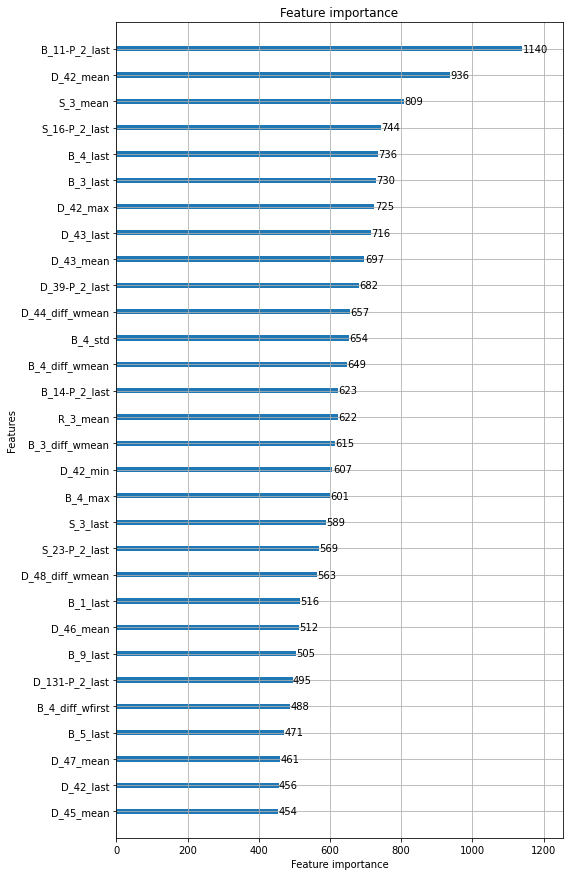

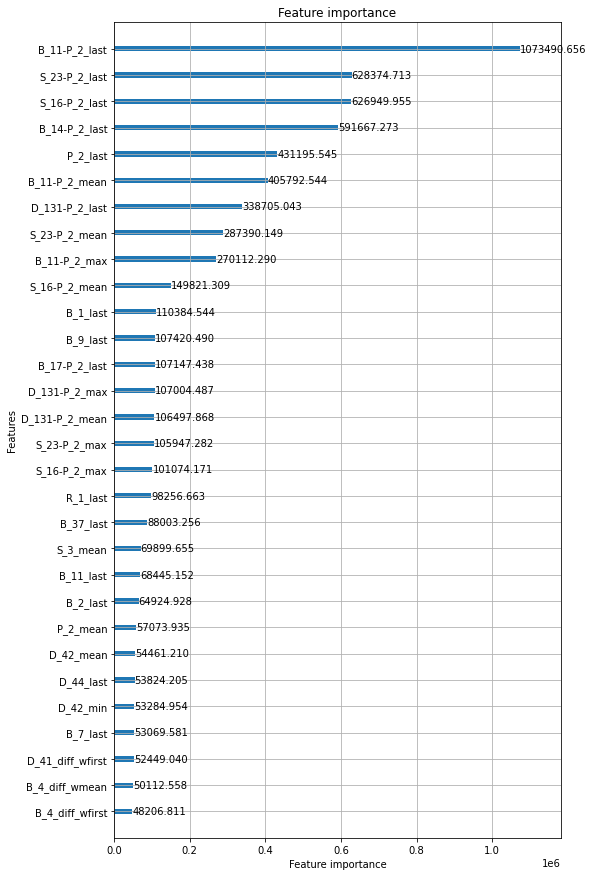

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.748797	valid_0's recall_at4: 0.597618	valid_0's norm_gini: 0.899977


[100]	valid_0's amex_metric: 0.757249	valid_0's recall_at4: 0.6094	valid_0's norm_gini: 0.905099


[150]	valid_0's amex_metric: 0.761087	valid_0's recall_at4: 0.61487	valid_0's norm_gini: 0.907303


[200]	valid_0's amex_metric: 0.762693	valid_0's recall_at4: 0.616595	valid_0's norm_gini: 0.908792


[250]	valid_0's amex_metric: 0.765907	valid_0's recall_at4: 0.621182	valid_0's norm_gini: 0.910633


[300]	valid_0's amex_metric: 0.768837	valid_0's recall_at4: 0.625347	valid_0's norm_gini: 0.912327


[350]	valid_0's amex_metric: 0.770231	valid_0's recall_at4: 0.626946	valid_0's norm_gini: 0.913515


[400]	valid_0's amex_metric: 0.770966	valid_0's recall_at4: 0.627746	valid_0's norm_gini: 0.914187


[450]	valid_0's amex_metric: 0.77209	valid_0's recall_at4: 0.628839	valid_0's norm_gini: 0.91534


[500]	valid_0's amex_metric: 0.775325	valid_0's recall_at4: 0.633973	valid_0's norm_gini: 0.916677


[550]	valid_0's amex_metric: 0.777998	valid_0's recall_at4: 0.638265	valid_0's norm_gini: 0.917731


[600]	valid_0's amex_metric: 0.780246	valid_0's recall_at4: 0.641841	valid_0's norm_gini: 0.918651


[650]	valid_0's amex_metric: 0.780881	valid_0's recall_at4: 0.642641	valid_0's norm_gini: 0.919122


[700]	valid_0's amex_metric: 0.782674	valid_0's recall_at4: 0.645712	valid_0's norm_gini: 0.919636


[750]	valid_0's amex_metric: 0.783827	valid_0's recall_at4: 0.647648	valid_0's norm_gini: 0.920005


[800]	valid_0's amex_metric: 0.783832	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.920352


[850]	valid_0's amex_metric: 0.784641	valid_0's recall_at4: 0.648616	valid_0's norm_gini: 0.920667


[900]	valid_0's amex_metric: 0.784677	valid_0's recall_at4: 0.648405	valid_0's norm_gini: 0.920949


[950]	valid_0's amex_metric: 0.785121	valid_0's recall_at4: 0.64891	valid_0's norm_gini: 0.921333


[1000]	valid_0's amex_metric: 0.786468	valid_0's recall_at4: 0.651309	valid_0's norm_gini: 0.921628


[1050]	valid_0's amex_metric: 0.787082	valid_0's recall_at4: 0.65215	valid_0's norm_gini: 0.922013


[1100]	valid_0's amex_metric: 0.787361	valid_0's recall_at4: 0.652487	valid_0's norm_gini: 0.922235


[1150]	valid_0's amex_metric: 0.78857	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.922465


[1200]	valid_0's amex_metric: 0.788633	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.922591


[1250]	valid_0's amex_metric: 0.788738	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.922801


[1300]	valid_0's amex_metric: 0.789485	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.922823


[1350]	valid_0's amex_metric: 0.790023	valid_0's recall_at4: 0.657073	valid_0's norm_gini: 0.922972


[1400]	valid_0's amex_metric: 0.790772	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.923167


[1450]	valid_0's amex_metric: 0.79067	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.923298


[1500]	valid_0's amex_metric: 0.790859	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.923424


[1550]	valid_0's amex_metric: 0.791898	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.923568


[1600]	valid_0's amex_metric: 0.792057	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923717


[1650]	valid_0's amex_metric: 0.79243	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923874


[1700]	valid_0's amex_metric: 0.792087	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.923988


[1750]	valid_0's amex_metric: 0.792207	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.924059


[1800]	valid_0's amex_metric: 0.792243	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.924173


[1850]	valid_0's amex_metric: 0.79274	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.924283


[1900]	valid_0's amex_metric: 0.793517	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924323


[1950]	valid_0's amex_metric: 0.793505	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924383


[2000]	valid_0's amex_metric: 0.793536	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.924486


[2050]	valid_0's amex_metric: 0.7933	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924604


[2100]	valid_0's amex_metric: 0.793132	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924689


[2150]	valid_0's amex_metric: 0.792846	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.924749


[2200]	valid_0's amex_metric: 0.792778	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.924823


[2250]	valid_0's amex_metric: 0.792717	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.924869


[2300]	valid_0's amex_metric: 0.793414	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.924916


[2350]	valid_0's amex_metric: 0.793478	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924959


[2400]	valid_0's amex_metric: 0.793611	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924973


[2450]	valid_0's amex_metric: 0.793639	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.924987


[2500]	valid_0's amex_metric: 0.794057	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925023


[2550]	valid_0's amex_metric: 0.793843	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.925059


[2600]	valid_0's amex_metric: 0.793284	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.925076


[2650]	valid_0's amex_metric: 0.792933	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.925091


[2700]	valid_0's amex_metric: 0.793161	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.925083


[2750]	valid_0's amex_metric: 0.792635	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.925124


[2800]	valid_0's amex_metric: 0.793062	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.925138


[2850]	valid_0's amex_metric: 0.793135	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.925157


[2900]	valid_0's amex_metric: 0.792639	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.925175


[2950]	valid_0's amex_metric: 0.792783	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.925168


[3000]	valid_0's amex_metric: 0.793048	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.925194


[3050]	valid_0's amex_metric: 0.793162	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.925211


[3100]	valid_0's amex_metric: 0.792776	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.92524


[3150]	valid_0's amex_metric: 0.792992	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.92525


[3200]	valid_0's amex_metric: 0.792877	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.925273


[3250]	valid_0's amex_metric: 0.792754	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.925279


[3300]	valid_0's amex_metric: 0.792952	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.925296


[3350]	valid_0's amex_metric: 0.792911	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.925299


[3400]	valid_0's amex_metric: 0.792439	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.925279


[3450]	valid_0's amex_metric: 0.792569	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.925287


[3500]	valid_0's amex_metric: 0.79326	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.925281


[3550]	valid_0's amex_metric: 0.793091	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.925237


[3600]	valid_0's amex_metric: 0.792962	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.925232


[3650]	valid_0's amex_metric: 0.792299	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.925254


[3700]	valid_0's amex_metric: 0.792494	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.925265


[3750]	valid_0's amex_metric: 0.792633	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.925247


[3800]	valid_0's amex_metric: 0.792918	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.925271


[3850]	valid_0's amex_metric: 0.793334	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.925302


[3900]	valid_0's amex_metric: 0.793479	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.925299


[3950]	valid_0's amex_metric: 0.793779	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.925309


[4000]	valid_0's amex_metric: 0.793447	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.925319


[4050]	valid_0's amex_metric: 0.79347	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.925323


[4100]	valid_0's amex_metric: 0.793515	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.925329


[4150]	valid_0's amex_metric: 0.793359	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.925311


[4200]	valid_0's amex_metric: 0.793082	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.925304


[4250]	valid_0's amex_metric: 0.79327	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.925301


[4300]	valid_0's amex_metric: 0.793371	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.925292


[4350]	valid_0's amex_metric: 0.793209	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.925305


[4400]	valid_0's amex_metric: 0.793674	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.92531


[4450]	valid_0's amex_metric: 0.793607	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.925303


[4500]	valid_0's amex_metric: 0.793314	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.925306


[4550]	valid_0's amex_metric: 0.793479	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.925298


[4600]	valid_0's amex_metric: 0.79317	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.92527


[4650]	valid_0's amex_metric: 0.792775	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.925238


[4700]	valid_0's amex_metric: 0.79306	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.92526


[4750]	valid_0's amex_metric: 0.792941	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.925275


[4800]	valid_0's amex_metric: 0.792793	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.925274


[4850]	valid_0's amex_metric: 0.79315	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.925272


[4900]	valid_0's amex_metric: 0.792932	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.925257


[4950]	valid_0's amex_metric: 0.793161	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.925251


[5000]	valid_0's amex_metric: 0.792912	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.925258


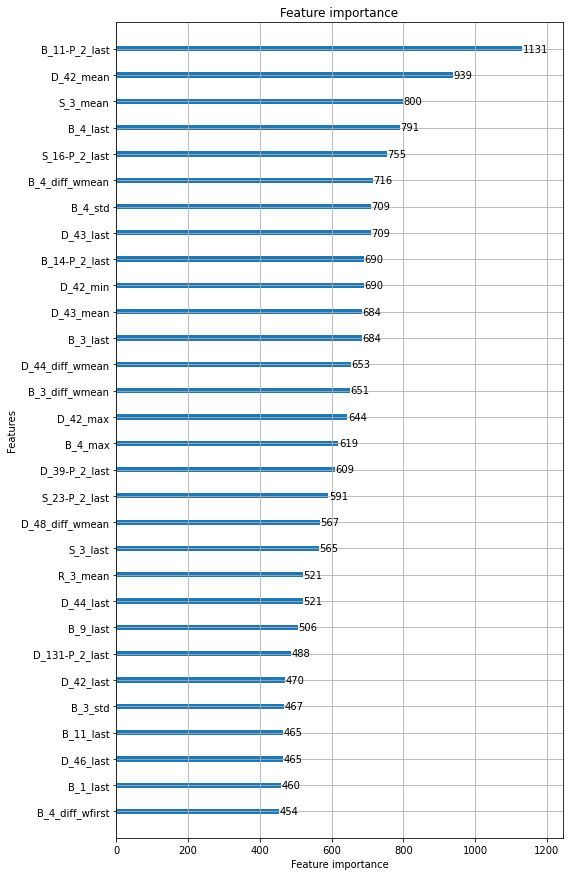

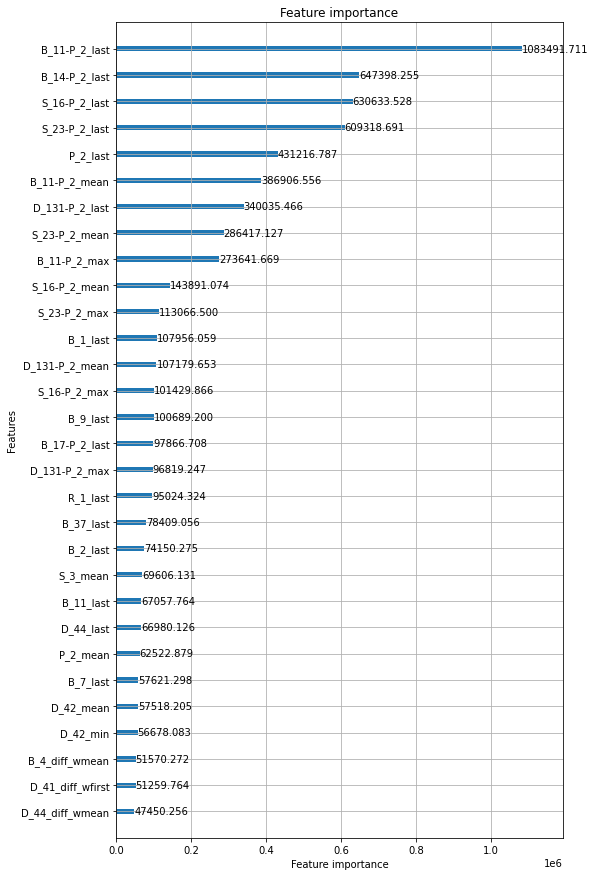

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.755508	valid_0's recall_at4: 0.608584	valid_0's norm_gini: 0.902432


[100]	valid_0's amex_metric: 0.763565	valid_0's recall_at4: 0.619482	valid_0's norm_gini: 0.907647


[150]	valid_0's amex_metric: 0.768458	valid_0's recall_at4: 0.627015	valid_0's norm_gini: 0.909901


[200]	valid_0's amex_metric: 0.768991	valid_0's recall_at4: 0.626804	valid_0's norm_gini: 0.911178


[250]	valid_0's amex_metric: 0.77211	valid_0's recall_at4: 0.631264	valid_0's norm_gini: 0.912957


[300]	valid_0's amex_metric: 0.775649	valid_0's recall_at4: 0.636777	valid_0's norm_gini: 0.914522


[350]	valid_0's amex_metric: 0.777611	valid_0's recall_at4: 0.639512	valid_0's norm_gini: 0.91571


[400]	valid_0's amex_metric: 0.778347	valid_0's recall_at4: 0.640396	valid_0's norm_gini: 0.916299


[450]	valid_0's amex_metric: 0.780841	valid_0's recall_at4: 0.644225	valid_0's norm_gini: 0.917456


[500]	valid_0's amex_metric: 0.784131	valid_0's recall_at4: 0.649653	valid_0's norm_gini: 0.918608


[550]	valid_0's amex_metric: 0.786271	valid_0's recall_at4: 0.653019	valid_0's norm_gini: 0.919522


[600]	valid_0's amex_metric: 0.78704	valid_0's recall_at4: 0.653692	valid_0's norm_gini: 0.920387


[650]	valid_0's amex_metric: 0.78828	valid_0's recall_at4: 0.655796	valid_0's norm_gini: 0.920763


[700]	valid_0's amex_metric: 0.788864	valid_0's recall_at4: 0.656428	valid_0's norm_gini: 0.921301


[750]	valid_0's amex_metric: 0.789734	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.921653


[800]	valid_0's amex_metric: 0.79002	valid_0's recall_at4: 0.658111	valid_0's norm_gini: 0.92193


[850]	valid_0's amex_metric: 0.790779	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.922226


[900]	valid_0's amex_metric: 0.790951	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.922486


[950]	valid_0's amex_metric: 0.792075	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.922841


[1000]	valid_0's amex_metric: 0.7932	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.923114


[1050]	valid_0's amex_metric: 0.79413	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.923458


[1100]	valid_0's amex_metric: 0.793902	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.923633


[1150]	valid_0's amex_metric: 0.794284	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.923808


[1200]	valid_0's amex_metric: 0.793982	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.923962


[1250]	valid_0's amex_metric: 0.79358	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.924084


[1300]	valid_0's amex_metric: 0.794158	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924146


[1350]	valid_0's amex_metric: 0.794787	valid_0's recall_at4: 0.665306	valid_0's norm_gini: 0.924269


[1400]	valid_0's amex_metric: 0.794531	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924387


[1450]	valid_0's amex_metric: 0.795069	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924495


[1500]	valid_0's amex_metric: 0.796106	valid_0's recall_at4: 0.66762	valid_0's norm_gini: 0.924592


[1550]	valid_0's amex_metric: 0.796093	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.924734


[1600]	valid_0's amex_metric: 0.796541	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.924831


[1650]	valid_0's amex_metric: 0.795585	valid_0's recall_at4: 0.666274	valid_0's norm_gini: 0.924897


[1700]	valid_0's amex_metric: 0.796279	valid_0's recall_at4: 0.66762	valid_0's norm_gini: 0.924938


[1750]	valid_0's amex_metric: 0.796164	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925003


[1800]	valid_0's amex_metric: 0.796906	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.925054


[1850]	valid_0's amex_metric: 0.796751	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925124


[1900]	valid_0's amex_metric: 0.796974	valid_0's recall_at4: 0.668799	valid_0's norm_gini: 0.925149


[1950]	valid_0's amex_metric: 0.796878	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.925209


[2000]	valid_0's amex_metric: 0.797441	valid_0's recall_at4: 0.669598	valid_0's norm_gini: 0.925284


[2050]	valid_0's amex_metric: 0.796773	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.925379


[2100]	valid_0's amex_metric: 0.796809	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.925451


[2150]	valid_0's amex_metric: 0.797374	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925528


[2200]	valid_0's amex_metric: 0.796948	valid_0's recall_at4: 0.668294	valid_0's norm_gini: 0.925603


[2250]	valid_0's amex_metric: 0.797314	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.92562


[2300]	valid_0's amex_metric: 0.797237	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925634


[2350]	valid_0's amex_metric: 0.797624	valid_0's recall_at4: 0.669598	valid_0's norm_gini: 0.925649


[2400]	valid_0's amex_metric: 0.797251	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925662


[2450]	valid_0's amex_metric: 0.797817	valid_0's recall_at4: 0.669935	valid_0's norm_gini: 0.9257


[2500]	valid_0's amex_metric: 0.797525	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.925746


[2550]	valid_0's amex_metric: 0.797777	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.925787


[2600]	valid_0's amex_metric: 0.797595	valid_0's recall_at4: 0.669388	valid_0's norm_gini: 0.925803


[2650]	valid_0's amex_metric: 0.797688	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.925861


[2700]	valid_0's amex_metric: 0.797359	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925877


[2750]	valid_0's amex_metric: 0.797586	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.92591


[2800]	valid_0's amex_metric: 0.798176	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.925913


[2850]	valid_0's amex_metric: 0.798322	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.925952


[2900]	valid_0's amex_metric: 0.79851	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.925949


[2950]	valid_0's amex_metric: 0.798428	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925954


[3000]	valid_0's amex_metric: 0.798337	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.925981


[3050]	valid_0's amex_metric: 0.798563	valid_0's recall_at4: 0.671113	valid_0's norm_gini: 0.926012


[3100]	valid_0's amex_metric: 0.798757	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.926022


[3150]	valid_0's amex_metric: 0.798799	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.926064


[3200]	valid_0's amex_metric: 0.799206	valid_0's recall_at4: 0.672333	valid_0's norm_gini: 0.926078


[3250]	valid_0's amex_metric: 0.798861	valid_0's recall_at4: 0.671618	valid_0's norm_gini: 0.926105


[3300]	valid_0's amex_metric: 0.798414	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.926137


[3350]	valid_0's amex_metric: 0.799187	valid_0's recall_at4: 0.672249	valid_0's norm_gini: 0.926125


[3400]	valid_0's amex_metric: 0.799077	valid_0's recall_at4: 0.672039	valid_0's norm_gini: 0.926114


[3450]	valid_0's amex_metric: 0.799606	valid_0's recall_at4: 0.673049	valid_0's norm_gini: 0.926164


[3500]	valid_0's amex_metric: 0.799001	valid_0's recall_at4: 0.671828	valid_0's norm_gini: 0.926173


[3550]	valid_0's amex_metric: 0.79927	valid_0's recall_at4: 0.672375	valid_0's norm_gini: 0.926165


[3600]	valid_0's amex_metric: 0.8	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.926193


[3650]	valid_0's amex_metric: 0.799881	valid_0's recall_at4: 0.673511	valid_0's norm_gini: 0.92625


[3700]	valid_0's amex_metric: 0.799998	valid_0's recall_at4: 0.673722	valid_0's norm_gini: 0.926275


[3750]	valid_0's amex_metric: 0.800207	valid_0's recall_at4: 0.674101	valid_0's norm_gini: 0.926314


[3800]	valid_0's amex_metric: 0.799843	valid_0's recall_at4: 0.673343	valid_0's norm_gini: 0.926343


[3850]	valid_0's amex_metric: 0.800358	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926363


[3900]	valid_0's amex_metric: 0.799966	valid_0's recall_at4: 0.673554	valid_0's norm_gini: 0.926379


[3950]	valid_0's amex_metric: 0.800298	valid_0's recall_at4: 0.674227	valid_0's norm_gini: 0.926369


[4000]	valid_0's amex_metric: 0.800212	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.926365


[4050]	valid_0's amex_metric: 0.800128	valid_0's recall_at4: 0.67389	valid_0's norm_gini: 0.926365


[4100]	valid_0's amex_metric: 0.800242	valid_0's recall_at4: 0.674101	valid_0's norm_gini: 0.926383


[4150]	valid_0's amex_metric: 0.800221	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.926384


[4200]	valid_0's amex_metric: 0.800084	valid_0's recall_at4: 0.673764	valid_0's norm_gini: 0.926405


[4250]	valid_0's amex_metric: 0.799838	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.926418


[4300]	valid_0's amex_metric: 0.800028	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.926418


[4350]	valid_0's amex_metric: 0.800403	valid_0's recall_at4: 0.674395	valid_0's norm_gini: 0.92641


[4400]	valid_0's amex_metric: 0.800725	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.926423


[4450]	valid_0's amex_metric: 0.800306	valid_0's recall_at4: 0.674185	valid_0's norm_gini: 0.926427


[4500]	valid_0's amex_metric: 0.80008	valid_0's recall_at4: 0.673722	valid_0's norm_gini: 0.926438


[4550]	valid_0's amex_metric: 0.800483	valid_0's recall_at4: 0.674521	valid_0's norm_gini: 0.926444


[4600]	valid_0's amex_metric: 0.800603	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.926431


[4650]	valid_0's amex_metric: 0.800967	valid_0's recall_at4: 0.675489	valid_0's norm_gini: 0.926445


[4700]	valid_0's amex_metric: 0.80054	valid_0's recall_at4: 0.674648	valid_0's norm_gini: 0.926433


[4750]	valid_0's amex_metric: 0.801129	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.926433


[4800]	valid_0's amex_metric: 0.801223	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.926453


[4850]	valid_0's amex_metric: 0.801267	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.926457


[4900]	valid_0's amex_metric: 0.800858	valid_0's recall_at4: 0.675279	valid_0's norm_gini: 0.926437


[4950]	valid_0's amex_metric: 0.801212	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.92643


[5000]	valid_0's amex_metric: 0.801288	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.926456


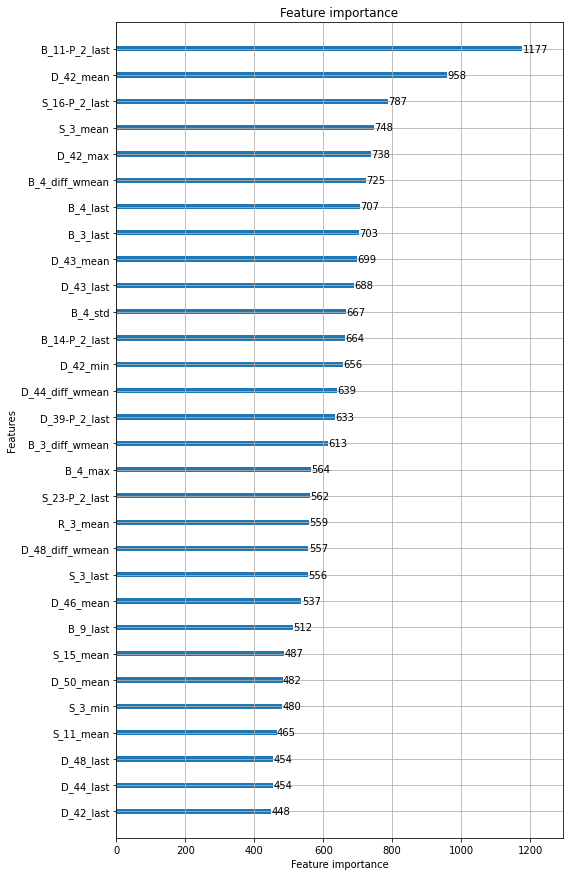

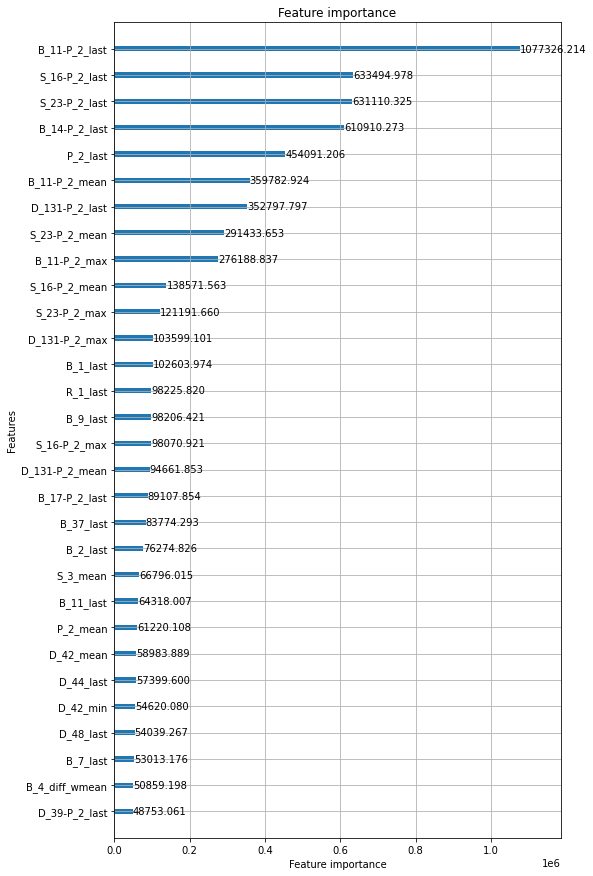

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.755712	valid_0's recall_at4: 0.608668	valid_0's norm_gini: 0.902756


[100]	valid_0's amex_metric: 0.763056	valid_0's recall_at4: 0.618388	valid_0's norm_gini: 0.907723


[150]	valid_0's amex_metric: 0.767918	valid_0's recall_at4: 0.625878	valid_0's norm_gini: 0.909958


[200]	valid_0's amex_metric: 0.770847	valid_0's recall_at4: 0.630297	valid_0's norm_gini: 0.911397


[250]	valid_0's amex_metric: 0.774114	valid_0's recall_at4: 0.635052	valid_0's norm_gini: 0.913177


[300]	valid_0's amex_metric: 0.77745	valid_0's recall_at4: 0.640227	valid_0's norm_gini: 0.914674


[350]	valid_0's amex_metric: 0.778596	valid_0's recall_at4: 0.641447	valid_0's norm_gini: 0.915744


[400]	valid_0's amex_metric: 0.779704	valid_0's recall_at4: 0.643089	valid_0's norm_gini: 0.916319


[450]	valid_0's amex_metric: 0.781015	valid_0's recall_at4: 0.644603	valid_0's norm_gini: 0.917426


[500]	valid_0's amex_metric: 0.783891	valid_0's recall_at4: 0.649232	valid_0's norm_gini: 0.91855


[550]	valid_0's amex_metric: 0.784247	valid_0's recall_at4: 0.648938	valid_0's norm_gini: 0.919556


[600]	valid_0's amex_metric: 0.785983	valid_0's recall_at4: 0.651462	valid_0's norm_gini: 0.920503


[650]	valid_0's amex_metric: 0.78661	valid_0's recall_at4: 0.652262	valid_0's norm_gini: 0.920958


[700]	valid_0's amex_metric: 0.787342	valid_0's recall_at4: 0.653187	valid_0's norm_gini: 0.921496


[750]	valid_0's amex_metric: 0.788717	valid_0's recall_at4: 0.655628	valid_0's norm_gini: 0.921806


[800]	valid_0's amex_metric: 0.788987	valid_0's recall_at4: 0.655838	valid_0's norm_gini: 0.922135


[850]	valid_0's amex_metric: 0.789527	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.922458


[900]	valid_0's amex_metric: 0.790212	valid_0's recall_at4: 0.65769	valid_0's norm_gini: 0.922734


[950]	valid_0's amex_metric: 0.79066	valid_0's recall_at4: 0.658237	valid_0's norm_gini: 0.923083


[1000]	valid_0's amex_metric: 0.790776	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.923357


[1050]	valid_0's amex_metric: 0.791489	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.92373


[1100]	valid_0's amex_metric: 0.791767	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.923993


[1150]	valid_0's amex_metric: 0.792277	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.924214


[1200]	valid_0's amex_metric: 0.7925	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.924364


[1250]	valid_0's amex_metric: 0.792149	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.924504


[1300]	valid_0's amex_metric: 0.792571	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.924507


[1350]	valid_0's amex_metric: 0.792476	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.924612


[1400]	valid_0's amex_metric: 0.792287	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.92478


[1450]	valid_0's amex_metric: 0.792326	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.924901


[1500]	valid_0's amex_metric: 0.792813	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.92499


[1550]	valid_0's amex_metric: 0.793511	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.925125


[1600]	valid_0's amex_metric: 0.794045	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.925225


[1650]	valid_0's amex_metric: 0.794032	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.925325


[1700]	valid_0's amex_metric: 0.794404	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.925396


[1750]	valid_0's amex_metric: 0.794112	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.925484


[1800]	valid_0's amex_metric: 0.79449	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.925525


[1850]	valid_0's amex_metric: 0.7945	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.925629


[1900]	valid_0's amex_metric: 0.795021	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.925662


[1950]	valid_0's amex_metric: 0.795234	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.925709


[2000]	valid_0's amex_metric: 0.794891	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.925823


[2050]	valid_0's amex_metric: 0.795181	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.925898


[2100]	valid_0's amex_metric: 0.795349	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.925981


[2150]	valid_0's amex_metric: 0.795955	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.926057


[2200]	valid_0's amex_metric: 0.796023	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.926108


[2250]	valid_0's amex_metric: 0.795942	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.926115


[2300]	valid_0's amex_metric: 0.795826	valid_0's recall_at4: 0.665516	valid_0's norm_gini: 0.926135


[2350]	valid_0's amex_metric: 0.796753	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.92618


[2400]	valid_0's amex_metric: 0.796645	valid_0's recall_at4: 0.667073	valid_0's norm_gini: 0.926217


[2450]	valid_0's amex_metric: 0.796461	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.926227


[2500]	valid_0's amex_metric: 0.796617	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.926245


[2550]	valid_0's amex_metric: 0.796535	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.92629


[2600]	valid_0's amex_metric: 0.79588	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.926286


[2650]	valid_0's amex_metric: 0.796575	valid_0's recall_at4: 0.666821	valid_0's norm_gini: 0.926329


[2700]	valid_0's amex_metric: 0.79627	valid_0's recall_at4: 0.66619	valid_0's norm_gini: 0.92635


[2750]	valid_0's amex_metric: 0.796013	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.926383


[2800]	valid_0's amex_metric: 0.796347	valid_0's recall_at4: 0.666274	valid_0's norm_gini: 0.92642


[2850]	valid_0's amex_metric: 0.796654	valid_0's recall_at4: 0.666863	valid_0's norm_gini: 0.926445


[2900]	valid_0's amex_metric: 0.796718	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.926447


[2950]	valid_0's amex_metric: 0.796988	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.92644


[3000]	valid_0's amex_metric: 0.797313	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.926459


[3050]	valid_0's amex_metric: 0.797014	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.926493


[3100]	valid_0's amex_metric: 0.79689	valid_0's recall_at4: 0.667242	valid_0's norm_gini: 0.926537


[3150]	valid_0's amex_metric: 0.797378	valid_0's recall_at4: 0.66821	valid_0's norm_gini: 0.926547


[3200]	valid_0's amex_metric: 0.797639	valid_0's recall_at4: 0.668715	valid_0's norm_gini: 0.926563


[3250]	valid_0's amex_metric: 0.797364	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.926561


[3300]	valid_0's amex_metric: 0.797031	valid_0's recall_at4: 0.667494	valid_0's norm_gini: 0.926567


[3350]	valid_0's amex_metric: 0.797294	valid_0's recall_at4: 0.667999	valid_0's norm_gini: 0.926588


[3400]	valid_0's amex_metric: 0.797591	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.926594


[3450]	valid_0's amex_metric: 0.797461	valid_0's recall_at4: 0.668294	valid_0's norm_gini: 0.926628


[3500]	valid_0's amex_metric: 0.797817	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.926625


[3550]	valid_0's amex_metric: 0.797369	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.926655


[3600]	valid_0's amex_metric: 0.797704	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.926651


[3650]	valid_0's amex_metric: 0.79777	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.926699


[3700]	valid_0's amex_metric: 0.797715	valid_0's recall_at4: 0.668715	valid_0's norm_gini: 0.926715


[3750]	valid_0's amex_metric: 0.797808	valid_0's recall_at4: 0.668925	valid_0's norm_gini: 0.926691


[3800]	valid_0's amex_metric: 0.797856	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.926702


[3850]	valid_0's amex_metric: 0.797775	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.926709


[3900]	valid_0's amex_metric: 0.798103	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.926734


[3950]	valid_0's amex_metric: 0.79744	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.926713


[4000]	valid_0's amex_metric: 0.797774	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.926706


[4050]	valid_0's amex_metric: 0.79821	valid_0's recall_at4: 0.669682	valid_0's norm_gini: 0.926738


[4100]	valid_0's amex_metric: 0.798264	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.926762


[4150]	valid_0's amex_metric: 0.798094	valid_0's recall_at4: 0.66943	valid_0's norm_gini: 0.926758


[4200]	valid_0's amex_metric: 0.798283	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.926757


[4250]	valid_0's amex_metric: 0.797668	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.926749


[4300]	valid_0's amex_metric: 0.798231	valid_0's recall_at4: 0.669724	valid_0's norm_gini: 0.926737


[4350]	valid_0's amex_metric: 0.797835	valid_0's recall_at4: 0.668925	valid_0's norm_gini: 0.926745


[4400]	valid_0's amex_metric: 0.798009	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.926757


[4450]	valid_0's amex_metric: 0.798466	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.926746


[4500]	valid_0's amex_metric: 0.798542	valid_0's recall_at4: 0.670356	valid_0's norm_gini: 0.926728


[4550]	valid_0's amex_metric: 0.798715	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.926739


[4600]	valid_0's amex_metric: 0.797905	valid_0's recall_at4: 0.669093	valid_0's norm_gini: 0.926717


[4650]	valid_0's amex_metric: 0.797861	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.926713


[4700]	valid_0's amex_metric: 0.798571	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.926744


[4750]	valid_0's amex_metric: 0.797894	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.926737


[4800]	valid_0's amex_metric: 0.797771	valid_0's recall_at4: 0.668799	valid_0's norm_gini: 0.926744


[4850]	valid_0's amex_metric: 0.797868	valid_0's recall_at4: 0.668967	valid_0's norm_gini: 0.926769


[4900]	valid_0's amex_metric: 0.797884	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.92676


[4950]	valid_0's amex_metric: 0.797643	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.92674


[5000]	valid_0's amex_metric: 0.797873	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.926737


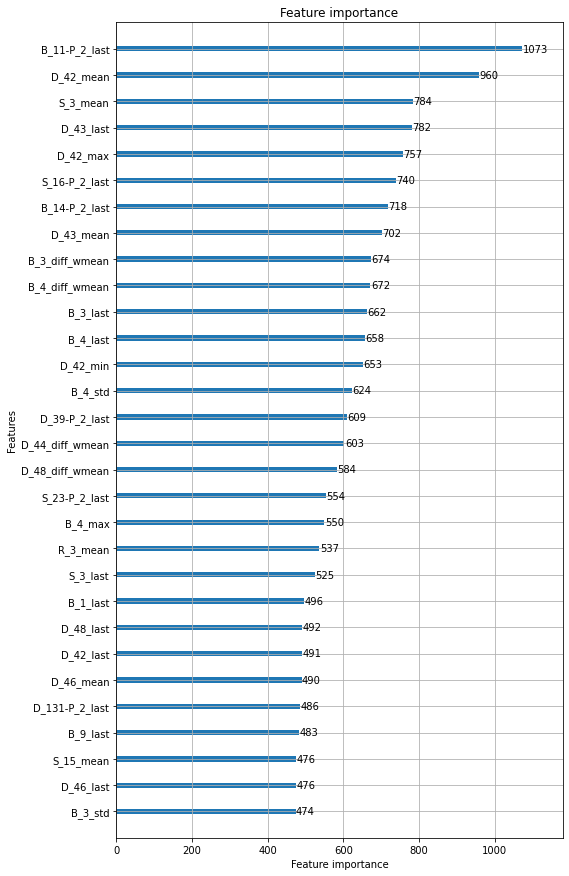

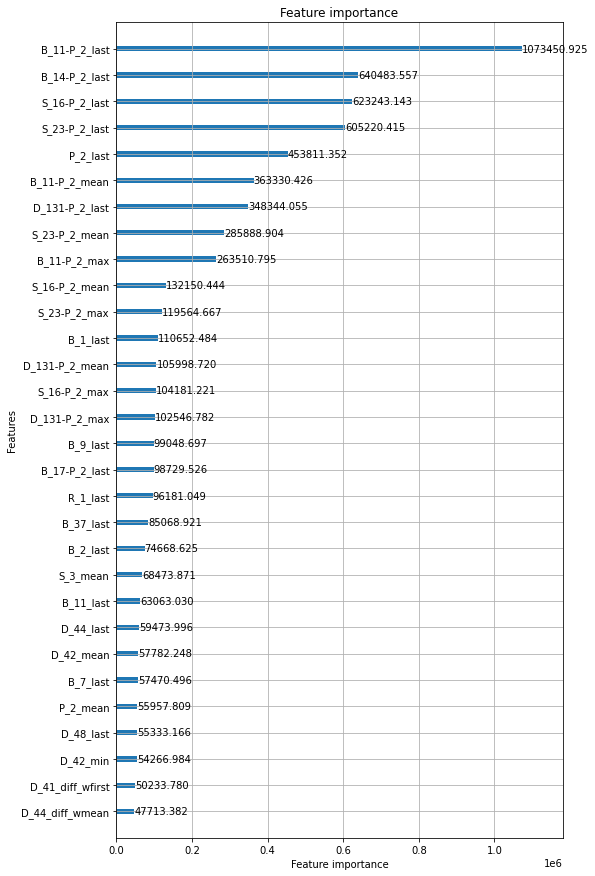

Training time: 122.25155348777771 min.
OOF recall_at4: 0.668335745783822
OOF normalized_gini: 0.9256660375690212
OOF competition metric: 0.7970008916764216
Finished CV repeat 1 in: 122.0 min.


############################### repeated cross-validation step: 3/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.750405	valid_0's recall_at4: 0.60048	valid_0's norm_gini: 0.90033


[100]	valid_0's amex_metric: 0.757526	valid_0's recall_at4: 0.609274	valid_0's norm_gini: 0.905778


[150]	valid_0's amex_metric: 0.761822	valid_0's recall_at4: 0.615754	valid_0's norm_gini: 0.907889


[200]	valid_0's amex_metric: 0.763915	valid_0's recall_at4: 0.618489	valid_0's norm_gini: 0.909341


[250]	valid_0's amex_metric: 0.767697	valid_0's recall_at4: 0.624211	valid_0's norm_gini: 0.911183


[300]	valid_0's amex_metric: 0.770726	valid_0's recall_at4: 0.628755	valid_0's norm_gini: 0.912697


[350]	valid_0's amex_metric: 0.772271	valid_0's recall_at4: 0.630775	valid_0's norm_gini: 0.913766


[400]	valid_0's amex_metric: 0.77366	valid_0's recall_at4: 0.632879	valid_0's norm_gini: 0.914442


[450]	valid_0's amex_metric: 0.775503	valid_0's recall_at4: 0.635488	valid_0's norm_gini: 0.915518


[500]	valid_0's amex_metric: 0.77858	valid_0's recall_at4: 0.640369	valid_0's norm_gini: 0.916792


[550]	valid_0's amex_metric: 0.780406	valid_0's recall_at4: 0.643019	valid_0's norm_gini: 0.917793


[600]	valid_0's amex_metric: 0.781685	valid_0's recall_at4: 0.644702	valid_0's norm_gini: 0.918667


[650]	valid_0's amex_metric: 0.782543	valid_0's recall_at4: 0.645965	valid_0's norm_gini: 0.919122


[700]	valid_0's amex_metric: 0.784599	valid_0's recall_at4: 0.649583	valid_0's norm_gini: 0.919615


[750]	valid_0's amex_metric: 0.784847	valid_0's recall_at4: 0.649752	valid_0's norm_gini: 0.919942


[800]	valid_0's amex_metric: 0.785423	valid_0's recall_at4: 0.650635	valid_0's norm_gini: 0.92021


[850]	valid_0's amex_metric: 0.786188	valid_0's recall_at4: 0.651856	valid_0's norm_gini: 0.92052


[900]	valid_0's amex_metric: 0.786901	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.92081


[950]	valid_0's amex_metric: 0.787944	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.921213


[1000]	valid_0's amex_metric: 0.788347	valid_0's recall_at4: 0.655222	valid_0's norm_gini: 0.921472


[1050]	valid_0's amex_metric: 0.788704	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.921765


[1100]	valid_0's amex_metric: 0.788905	valid_0's recall_at4: 0.655811	valid_0's norm_gini: 0.921999


[1150]	valid_0's amex_metric: 0.789358	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922148


[1200]	valid_0's amex_metric: 0.789541	valid_0's recall_at4: 0.656821	valid_0's norm_gini: 0.922262


[1250]	valid_0's amex_metric: 0.789873	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.92242


[1300]	valid_0's amex_metric: 0.790082	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.922501


[1350]	valid_0's amex_metric: 0.790417	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.922625


[1400]	valid_0's amex_metric: 0.79124	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.922798


[1450]	valid_0's amex_metric: 0.791095	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.922886


[1500]	valid_0's amex_metric: 0.791376	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.922985


[1550]	valid_0's amex_metric: 0.791837	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923108


[1600]	valid_0's amex_metric: 0.792234	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.92323


[1650]	valid_0's amex_metric: 0.792365	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.923282


[1700]	valid_0's amex_metric: 0.791668	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.923318


[1750]	valid_0's amex_metric: 0.792146	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.923433


[1800]	valid_0's amex_metric: 0.791653	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.923498


[1850]	valid_0's amex_metric: 0.79248	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.923595


[1900]	valid_0's amex_metric: 0.792289	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.923635


[1950]	valid_0's amex_metric: 0.792566	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923724


[2000]	valid_0's amex_metric: 0.792723	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.923787


[2050]	valid_0's amex_metric: 0.793233	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.923881


[2100]	valid_0's amex_metric: 0.793543	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.923953


[2150]	valid_0's amex_metric: 0.793481	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.923998


[2200]	valid_0's amex_metric: 0.79358	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.92407


[2250]	valid_0's amex_metric: 0.794445	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924116


[2300]	valid_0's amex_metric: 0.794248	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.924144


[2350]	valid_0's amex_metric: 0.793993	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.924181


[2400]	valid_0's amex_metric: 0.793875	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.924198


[2450]	valid_0's amex_metric: 0.79392	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.924246


[2500]	valid_0's amex_metric: 0.793992	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.924263


[2550]	valid_0's amex_metric: 0.794445	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.924285


[2600]	valid_0's amex_metric: 0.794112	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924334


[2650]	valid_0's amex_metric: 0.794152	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924331


[2700]	valid_0's amex_metric: 0.794017	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.924355


[2750]	valid_0's amex_metric: 0.794365	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.924378


[2800]	valid_0's amex_metric: 0.793852	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924403


[2850]	valid_0's amex_metric: 0.793946	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.924423


[2900]	valid_0's amex_metric: 0.793968	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.924426


[2950]	valid_0's amex_metric: 0.79384	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924422


[3000]	valid_0's amex_metric: 0.793878	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.924413


[3050]	valid_0's amex_metric: 0.794029	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924421


[3100]	valid_0's amex_metric: 0.794059	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.924439


[3150]	valid_0's amex_metric: 0.794184	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924478


[3200]	valid_0's amex_metric: 0.794176	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924462


[3250]	valid_0's amex_metric: 0.794453	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924512


[3300]	valid_0's amex_metric: 0.794368	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.92451


[3350]	valid_0's amex_metric: 0.794074	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924512


[3400]	valid_0's amex_metric: 0.794194	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924498


[3450]	valid_0's amex_metric: 0.794227	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924522


[3500]	valid_0's amex_metric: 0.794225	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924518


[3550]	valid_0's amex_metric: 0.794389	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.92451


[3600]	valid_0's amex_metric: 0.794603	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.924518


[3650]	valid_0's amex_metric: 0.794059	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.924523


[3700]	valid_0's amex_metric: 0.793784	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.92452


[3750]	valid_0's amex_metric: 0.794269	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.924522


[3800]	valid_0's amex_metric: 0.794268	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.92452


[3850]	valid_0's amex_metric: 0.794644	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924516


[3900]	valid_0's amex_metric: 0.794614	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.924539


[3950]	valid_0's amex_metric: 0.794823	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.924535


[4000]	valid_0's amex_metric: 0.794653	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924533


[4050]	valid_0's amex_metric: 0.794552	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.92454


[4100]	valid_0's amex_metric: 0.794657	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.92454


[4150]	valid_0's amex_metric: 0.794437	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.924522


[4200]	valid_0's amex_metric: 0.794218	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924504


[4250]	valid_0's amex_metric: 0.794006	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.924501


[4300]	valid_0's amex_metric: 0.793966	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.924506


[4350]	valid_0's amex_metric: 0.793735	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924507


[4400]	valid_0's amex_metric: 0.793584	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924541


[4450]	valid_0's amex_metric: 0.793822	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924553


[4500]	valid_0's amex_metric: 0.793834	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924579


[4550]	valid_0's amex_metric: 0.794107	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924577


[4600]	valid_0's amex_metric: 0.793805	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924563


[4650]	valid_0's amex_metric: 0.793795	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924541


[4700]	valid_0's amex_metric: 0.793854	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.924533


[4750]	valid_0's amex_metric: 0.793775	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.924545


[4800]	valid_0's amex_metric: 0.793848	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.924521


[4850]	valid_0's amex_metric: 0.794073	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.92451


[4900]	valid_0's amex_metric: 0.794514	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.924507


[4950]	valid_0's amex_metric: 0.793853	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.924489


[5000]	valid_0's amex_metric: 0.794119	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924475


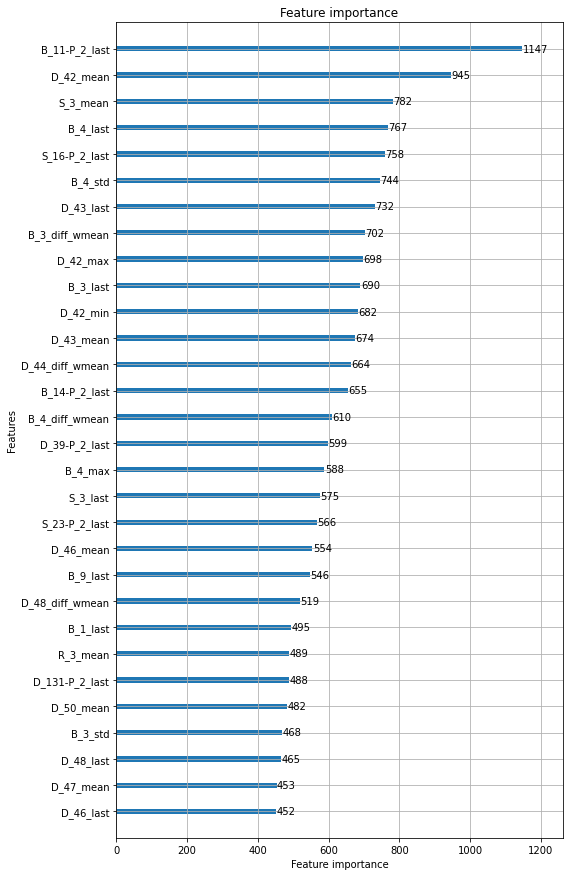

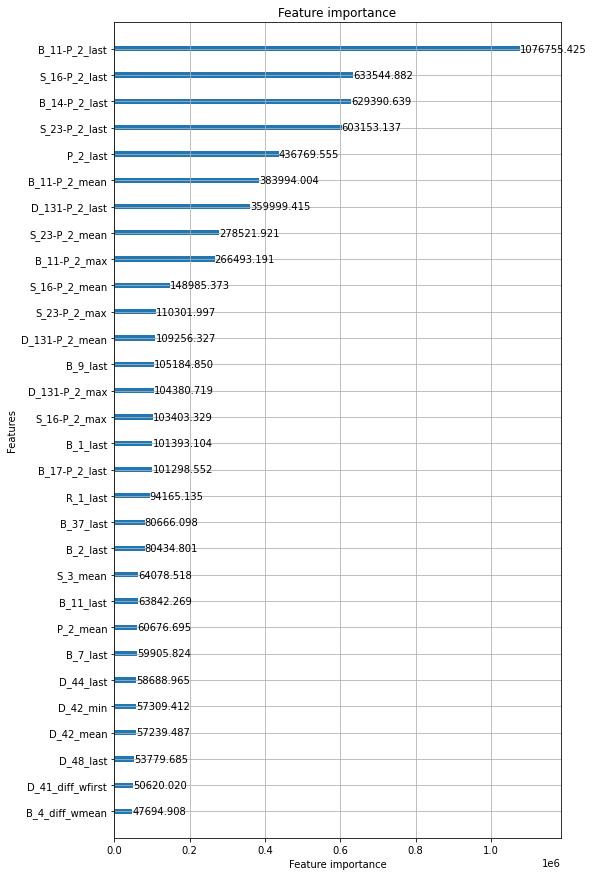

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.751514	valid_0's recall_at4: 0.6009	valid_0's norm_gini: 0.902128


[100]	valid_0's amex_metric: 0.757617	valid_0's recall_at4: 0.608432	valid_0's norm_gini: 0.906801


[150]	valid_0's amex_metric: 0.762975	valid_0's recall_at4: 0.616848	valid_0's norm_gini: 0.909102


[200]	valid_0's amex_metric: 0.763282	valid_0's recall_at4: 0.616216	valid_0's norm_gini: 0.910348


[250]	valid_0's amex_metric: 0.766965	valid_0's recall_at4: 0.621771	valid_0's norm_gini: 0.912159


[300]	valid_0's amex_metric: 0.770523	valid_0's recall_at4: 0.627325	valid_0's norm_gini: 0.913721


[350]	valid_0's amex_metric: 0.773082	valid_0's recall_at4: 0.631406	valid_0's norm_gini: 0.914758


[400]	valid_0's amex_metric: 0.773987	valid_0's recall_at4: 0.632626	valid_0's norm_gini: 0.915348


[450]	valid_0's amex_metric: 0.775998	valid_0's recall_at4: 0.63553	valid_0's norm_gini: 0.916466


[500]	valid_0's amex_metric: 0.777614	valid_0's recall_at4: 0.637634	valid_0's norm_gini: 0.917595


[550]	valid_0's amex_metric: 0.779853	valid_0's recall_at4: 0.641084	valid_0's norm_gini: 0.918621


[600]	valid_0's amex_metric: 0.781453	valid_0's recall_at4: 0.643314	valid_0's norm_gini: 0.919593


[650]	valid_0's amex_metric: 0.781275	valid_0's recall_at4: 0.642557	valid_0's norm_gini: 0.919993


[700]	valid_0's amex_metric: 0.782926	valid_0's recall_at4: 0.645334	valid_0's norm_gini: 0.920518


[750]	valid_0's amex_metric: 0.782716	valid_0's recall_at4: 0.644576	valid_0's norm_gini: 0.920855


[800]	valid_0's amex_metric: 0.782941	valid_0's recall_at4: 0.644745	valid_0's norm_gini: 0.921137


[850]	valid_0's amex_metric: 0.783536	valid_0's recall_at4: 0.645628	valid_0's norm_gini: 0.921443


[900]	valid_0's amex_metric: 0.783502	valid_0's recall_at4: 0.64525	valid_0's norm_gini: 0.921755


[950]	valid_0's amex_metric: 0.784333	valid_0's recall_at4: 0.646554	valid_0's norm_gini: 0.922112


[1000]	valid_0's amex_metric: 0.784714	valid_0's recall_at4: 0.647017	valid_0's norm_gini: 0.922411


[1050]	valid_0's amex_metric: 0.785894	valid_0's recall_at4: 0.649036	valid_0's norm_gini: 0.922751


[1100]	valid_0's amex_metric: 0.786396	valid_0's recall_at4: 0.649794	valid_0's norm_gini: 0.922998


[1150]	valid_0's amex_metric: 0.786946	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.923215


[1200]	valid_0's amex_metric: 0.787728	valid_0's recall_at4: 0.652108	valid_0's norm_gini: 0.923349


[1250]	valid_0's amex_metric: 0.787794	valid_0's recall_at4: 0.652066	valid_0's norm_gini: 0.923522


[1300]	valid_0's amex_metric: 0.787733	valid_0's recall_at4: 0.651898	valid_0's norm_gini: 0.923568


[1350]	valid_0's amex_metric: 0.788592	valid_0's recall_at4: 0.653497	valid_0's norm_gini: 0.923687


[1400]	valid_0's amex_metric: 0.788905	valid_0's recall_at4: 0.653959	valid_0's norm_gini: 0.92385


[1450]	valid_0's amex_metric: 0.7885	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.924008


[1500]	valid_0's amex_metric: 0.788649	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.924096


[1550]	valid_0's amex_metric: 0.789077	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.924237


[1600]	valid_0's amex_metric: 0.789681	valid_0's recall_at4: 0.655011	valid_0's norm_gini: 0.92435


[1650]	valid_0's amex_metric: 0.790031	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.924419


[1700]	valid_0's amex_metric: 0.789947	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.924503


[1750]	valid_0's amex_metric: 0.790002	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.924614


[1800]	valid_0's amex_metric: 0.790329	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.924678


[1850]	valid_0's amex_metric: 0.790591	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.924781


[1900]	valid_0's amex_metric: 0.790775	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.924814


[1950]	valid_0's amex_metric: 0.790306	valid_0's recall_at4: 0.655769	valid_0's norm_gini: 0.924842


[2000]	valid_0's amex_metric: 0.78999	valid_0's recall_at4: 0.655011	valid_0's norm_gini: 0.924968


[2050]	valid_0's amex_metric: 0.790426	valid_0's recall_at4: 0.655769	valid_0's norm_gini: 0.925084


[2100]	valid_0's amex_metric: 0.791302	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.925152


[2150]	valid_0's amex_metric: 0.791075	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.925245


[2200]	valid_0's amex_metric: 0.791675	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.925308


[2250]	valid_0's amex_metric: 0.791451	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.925366


[2300]	valid_0's amex_metric: 0.79208	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.925403


[2350]	valid_0's amex_metric: 0.792018	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.925406


[2400]	valid_0's amex_metric: 0.791787	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.925408


[2450]	valid_0's amex_metric: 0.792183	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.925442


[2500]	valid_0's amex_metric: 0.792154	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.925468


[2550]	valid_0's amex_metric: 0.792337	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.925497


[2600]	valid_0's amex_metric: 0.792106	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.92554


[2650]	valid_0's amex_metric: 0.792288	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.925566


[2700]	valid_0's amex_metric: 0.79266	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.925595


[2750]	valid_0's amex_metric: 0.792081	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.925617


[2800]	valid_0's amex_metric: 0.792494	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.925643


[2850]	valid_0's amex_metric: 0.792859	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.925658


[2900]	valid_0's amex_metric: 0.79249	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.925676


[2950]	valid_0's amex_metric: 0.792073	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.925685


[3000]	valid_0's amex_metric: 0.792356	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.925703


[3050]	valid_0's amex_metric: 0.791905	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.925728


[3100]	valid_0's amex_metric: 0.792013	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.925775


[3150]	valid_0's amex_metric: 0.791971	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.925775


[3200]	valid_0's amex_metric: 0.792355	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.925786


[3250]	valid_0's amex_metric: 0.792395	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.925824


[3300]	valid_0's amex_metric: 0.792268	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.925823


[3350]	valid_0's amex_metric: 0.792418	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.925828


[3400]	valid_0's amex_metric: 0.791819	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.92585


[3450]	valid_0's amex_metric: 0.791891	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.92591


[3500]	valid_0's amex_metric: 0.791951	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.925904


[3550]	valid_0's amex_metric: 0.792269	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.925908


[3600]	valid_0's amex_metric: 0.792388	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.925936


[3650]	valid_0's amex_metric: 0.792205	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.925948


[3700]	valid_0's amex_metric: 0.792243	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.92594


[3750]	valid_0's amex_metric: 0.791805	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.925948


[3800]	valid_0's amex_metric: 0.792211	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.925918


[3850]	valid_0's amex_metric: 0.79139	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.925917


[3900]	valid_0's amex_metric: 0.791452	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.925914


[3950]	valid_0's amex_metric: 0.791691	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.92593


[4000]	valid_0's amex_metric: 0.791887	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.925943


[4050]	valid_0's amex_metric: 0.792234	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.925965


[4100]	valid_0's amex_metric: 0.791755	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.925973


[4150]	valid_0's amex_metric: 0.791728	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.925963


[4200]	valid_0's amex_metric: 0.791685	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.92596


[4250]	valid_0's amex_metric: 0.792338	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.925963


[4300]	valid_0's amex_metric: 0.792276	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.925964


[4350]	valid_0's amex_metric: 0.791796	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.925973


[4400]	valid_0's amex_metric: 0.79249	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.925972


[4450]	valid_0's amex_metric: 0.792594	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.925969


[4500]	valid_0's amex_metric: 0.792112	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.925973


[4550]	valid_0's amex_metric: 0.791881	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.925973


[4600]	valid_0's amex_metric: 0.792007	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.925973


[4650]	valid_0's amex_metric: 0.792074	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.92598


[4700]	valid_0's amex_metric: 0.791756	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.925975


[4750]	valid_0's amex_metric: 0.792008	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.925976


[4800]	valid_0's amex_metric: 0.791886	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.925984


[4850]	valid_0's amex_metric: 0.792003	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.925965


[4900]	valid_0's amex_metric: 0.792019	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.925997


[4950]	valid_0's amex_metric: 0.792097	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.925985


[5000]	valid_0's amex_metric: 0.792005	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.925969


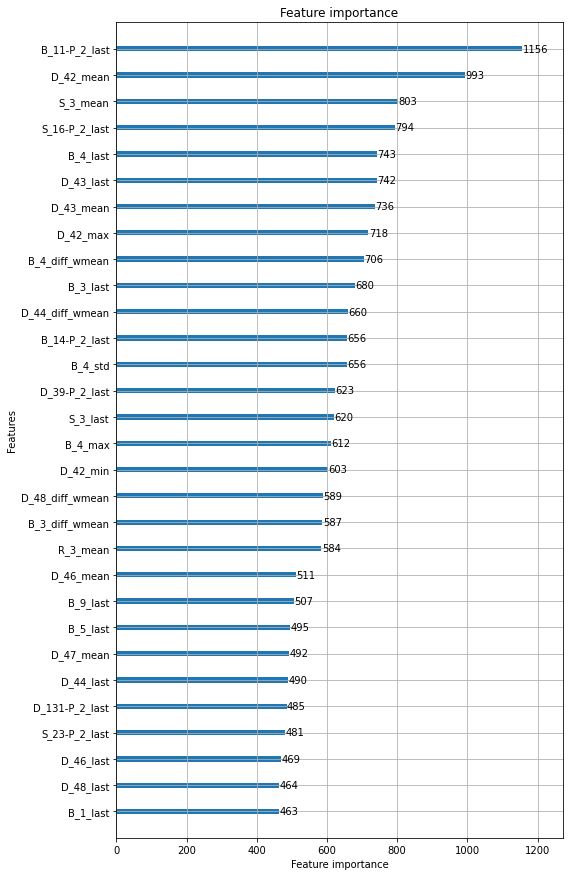

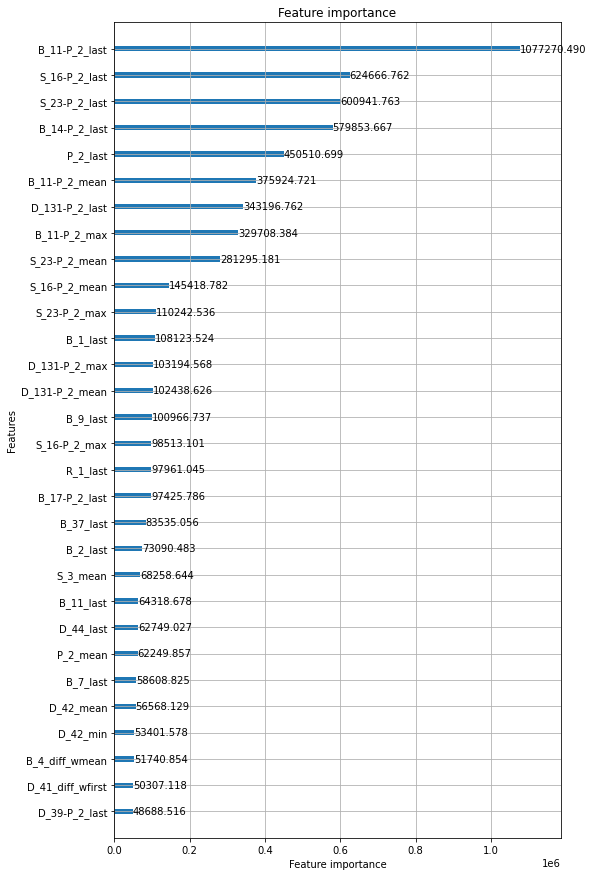

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.75359	valid_0's recall_at4: 0.606749	valid_0's norm_gini: 0.900431


[100]	valid_0's amex_metric: 0.762397	valid_0's recall_at4: 0.618741	valid_0's norm_gini: 0.906053


[150]	valid_0's amex_metric: 0.767095	valid_0's recall_at4: 0.625852	valid_0's norm_gini: 0.908337


[200]	valid_0's amex_metric: 0.769053	valid_0's recall_at4: 0.628208	valid_0's norm_gini: 0.909898


[250]	valid_0's amex_metric: 0.772296	valid_0's recall_at4: 0.632795	valid_0's norm_gini: 0.911798


[300]	valid_0's amex_metric: 0.775223	valid_0's recall_at4: 0.637129	valid_0's norm_gini: 0.913318


[350]	valid_0's amex_metric: 0.777591	valid_0's recall_at4: 0.640789	valid_0's norm_gini: 0.914392


[400]	valid_0's amex_metric: 0.777949	valid_0's recall_at4: 0.640747	valid_0's norm_gini: 0.91515


[450]	valid_0's amex_metric: 0.780647	valid_0's recall_at4: 0.644955	valid_0's norm_gini: 0.91634


[500]	valid_0's amex_metric: 0.782943	valid_0's recall_at4: 0.648237	valid_0's norm_gini: 0.917649


[550]	valid_0's amex_metric: 0.784039	valid_0's recall_at4: 0.649415	valid_0's norm_gini: 0.918663


[600]	valid_0's amex_metric: 0.785992	valid_0's recall_at4: 0.652318	valid_0's norm_gini: 0.919665


[650]	valid_0's amex_metric: 0.786172	valid_0's recall_at4: 0.652192	valid_0's norm_gini: 0.920151


[700]	valid_0's amex_metric: 0.786679	valid_0's recall_at4: 0.652655	valid_0's norm_gini: 0.920703


[750]	valid_0's amex_metric: 0.788696	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.921034


[800]	valid_0's amex_metric: 0.789888	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.921399


[850]	valid_0's amex_metric: 0.790319	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.921756


[900]	valid_0's amex_metric: 0.790864	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.922047


[950]	valid_0's amex_metric: 0.791512	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922458


[1000]	valid_0's amex_metric: 0.792407	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.922776


[1050]	valid_0's amex_metric: 0.793108	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.923168


[1100]	valid_0's amex_metric: 0.793483	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923455


[1150]	valid_0's amex_metric: 0.79389	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.923597


[1200]	valid_0's amex_metric: 0.794653	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.923692


[1250]	valid_0's amex_metric: 0.794913	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.923876


[1300]	valid_0's amex_metric: 0.794661	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.923918


[1350]	valid_0's amex_metric: 0.794878	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924016


[1400]	valid_0's amex_metric: 0.794958	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.924216


[1450]	valid_0's amex_metric: 0.794978	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924341


[1500]	valid_0's amex_metric: 0.795596	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924441


[1550]	valid_0's amex_metric: 0.796398	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.924573


[1600]	valid_0's amex_metric: 0.796985	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.924652


[1650]	valid_0's amex_metric: 0.797223	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.924749


[1700]	valid_0's amex_metric: 0.797433	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924833


[1750]	valid_0's amex_metric: 0.797501	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.924928


[1800]	valid_0's amex_metric: 0.798465	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925003


[1850]	valid_0's amex_metric: 0.798486	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925087


[1900]	valid_0's amex_metric: 0.798422	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925128


[1950]	valid_0's amex_metric: 0.798754	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925161


[2000]	valid_0's amex_metric: 0.798602	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925278


[2050]	valid_0's amex_metric: 0.799085	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.92536


[2100]	valid_0's amex_metric: 0.799382	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.925449


[2150]	valid_0's amex_metric: 0.799245	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.925512


[2200]	valid_0's amex_metric: 0.798867	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925556


[2250]	valid_0's amex_metric: 0.799401	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925614


[2300]	valid_0's amex_metric: 0.798991	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925634


[2350]	valid_0's amex_metric: 0.798976	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925689


[2400]	valid_0's amex_metric: 0.799282	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925712


[2450]	valid_0's amex_metric: 0.799307	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925762


[2500]	valid_0's amex_metric: 0.799085	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925824


[2550]	valid_0's amex_metric: 0.798975	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.925855


[2600]	valid_0's amex_metric: 0.799361	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.92587


[2650]	valid_0's amex_metric: 0.79904	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925902


[2700]	valid_0's amex_metric: 0.799203	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925933


[2750]	valid_0's amex_metric: 0.799617	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.92596


[2800]	valid_0's amex_metric: 0.799315	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.925947


[2850]	valid_0's amex_metric: 0.798814	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925955


[2900]	valid_0's amex_metric: 0.799321	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.926001


[2950]	valid_0's amex_metric: 0.79918	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926013


[3000]	valid_0's amex_metric: 0.799019	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926027


[3050]	valid_0's amex_metric: 0.799117	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926055


[3100]	valid_0's amex_metric: 0.799084	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926074


[3150]	valid_0's amex_metric: 0.798657	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.926102


[3200]	valid_0's amex_metric: 0.798878	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.926123


[3250]	valid_0's amex_metric: 0.798783	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.926144


[3300]	valid_0's amex_metric: 0.798791	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.926162


[3350]	valid_0's amex_metric: 0.798837	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926168


[3400]	valid_0's amex_metric: 0.799035	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926185


[3450]	valid_0's amex_metric: 0.799252	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926198


[3500]	valid_0's amex_metric: 0.798871	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.926194


[3550]	valid_0's amex_metric: 0.798978	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926198


[3600]	valid_0's amex_metric: 0.798962	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926209


[3650]	valid_0's amex_metric: 0.798794	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.92621


[3700]	valid_0's amex_metric: 0.799077	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926227


[3750]	valid_0's amex_metric: 0.798549	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926223


[3800]	valid_0's amex_metric: 0.798625	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.926249


[3850]	valid_0's amex_metric: 0.798479	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926294


[3900]	valid_0's amex_metric: 0.798474	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926284


[3950]	valid_0's amex_metric: 0.798669	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.926296


[4000]	valid_0's amex_metric: 0.798677	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.92631


[4050]	valid_0's amex_metric: 0.798681	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.926319


[4100]	valid_0's amex_metric: 0.798786	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.926319


[4150]	valid_0's amex_metric: 0.798868	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.926314


[4200]	valid_0's amex_metric: 0.799591	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926331


[4250]	valid_0's amex_metric: 0.798697	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.926309


[4300]	valid_0's amex_metric: 0.799154	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926298


[4350]	valid_0's amex_metric: 0.79899	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.926307


[4400]	valid_0's amex_metric: 0.799097	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926309


[4450]	valid_0's amex_metric: 0.799743	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926298


[4500]	valid_0's amex_metric: 0.799769	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926308


[4550]	valid_0's amex_metric: 0.799815	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926315


[4600]	valid_0's amex_metric: 0.799385	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.926296


[4650]	valid_0's amex_metric: 0.799189	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926284


[4700]	valid_0's amex_metric: 0.799116	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926306


[4750]	valid_0's amex_metric: 0.799252	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926326


[4800]	valid_0's amex_metric: 0.799061	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926321


[4850]	valid_0's amex_metric: 0.799693	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926323


[4900]	valid_0's amex_metric: 0.799991	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.92633


[4950]	valid_0's amex_metric: 0.800015	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.926336


[5000]	valid_0's amex_metric: 0.79987	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926341


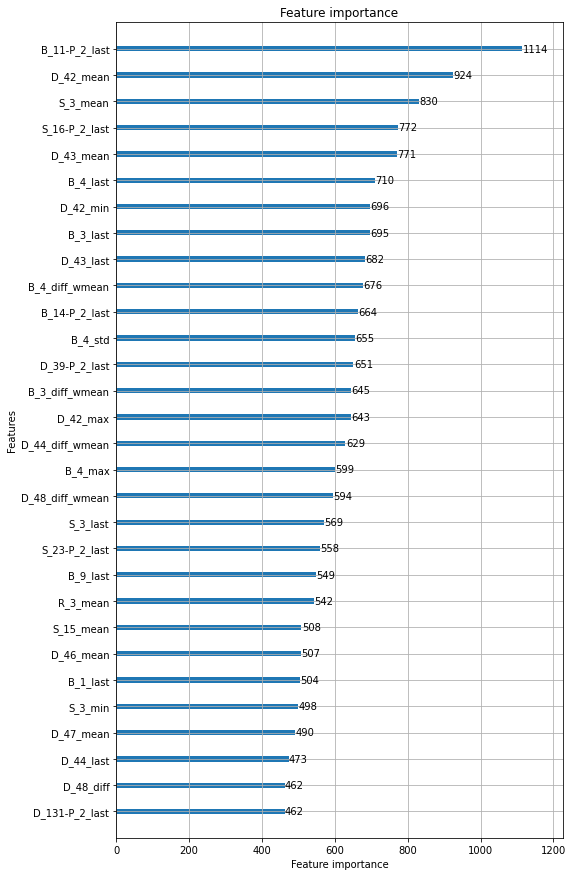

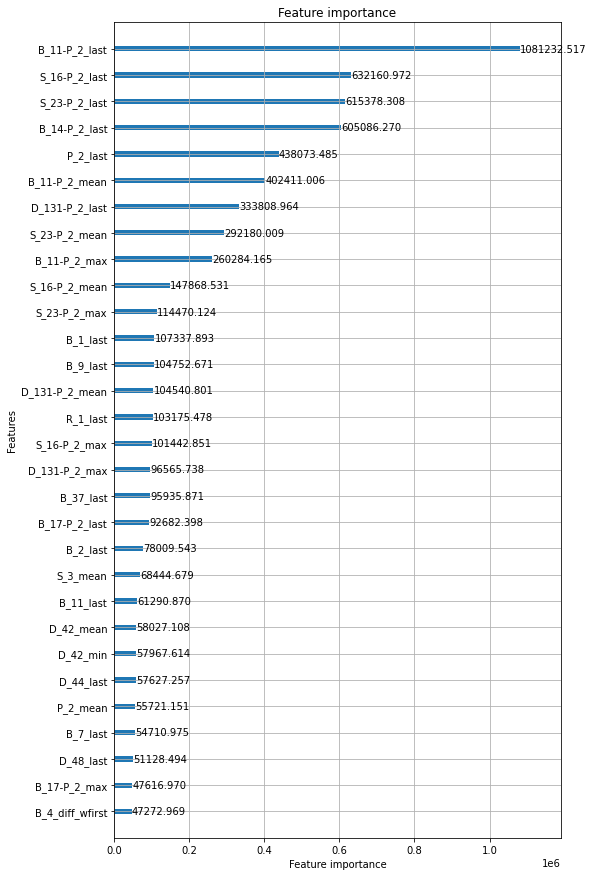

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.757693	valid_0's recall_at4: 0.610688	valid_0's norm_gini: 0.904697


[100]	valid_0's amex_metric: 0.767305	valid_0's recall_at4: 0.624742	valid_0's norm_gini: 0.909867


[150]	valid_0's amex_metric: 0.771481	valid_0's recall_at4: 0.630886	valid_0's norm_gini: 0.912076


[200]	valid_0's amex_metric: 0.773958	valid_0's recall_at4: 0.634504	valid_0's norm_gini: 0.913411


[250]	valid_0's amex_metric: 0.777092	valid_0's recall_at4: 0.639007	valid_0's norm_gini: 0.915176


[300]	valid_0's amex_metric: 0.779368	valid_0's recall_at4: 0.642121	valid_0's norm_gini: 0.916615


[350]	valid_0's amex_metric: 0.780693	valid_0's recall_at4: 0.643636	valid_0's norm_gini: 0.91775


[400]	valid_0's amex_metric: 0.781921	valid_0's recall_at4: 0.645445	valid_0's norm_gini: 0.918398


[450]	valid_0's amex_metric: 0.784069	valid_0's recall_at4: 0.648643	valid_0's norm_gini: 0.919495


[500]	valid_0's amex_metric: 0.78621	valid_0's recall_at4: 0.651631	valid_0's norm_gini: 0.92079


[550]	valid_0's amex_metric: 0.789542	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.921814


[600]	valid_0's amex_metric: 0.791343	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.922724


[650]	valid_0's amex_metric: 0.792923	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.923191


[700]	valid_0's amex_metric: 0.792941	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.923731


[750]	valid_0's amex_metric: 0.793739	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.924065


[800]	valid_0's amex_metric: 0.793905	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.924398


[850]	valid_0's amex_metric: 0.794462	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.924669


[900]	valid_0's amex_metric: 0.79463	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.925007


[950]	valid_0's amex_metric: 0.795021	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.925325


[1000]	valid_0's amex_metric: 0.795918	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.925603


[1050]	valid_0's amex_metric: 0.797361	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.925965


[1100]	valid_0's amex_metric: 0.797307	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.926236


[1150]	valid_0's amex_metric: 0.798125	valid_0's recall_at4: 0.669851	valid_0's norm_gini: 0.926399


[1200]	valid_0's amex_metric: 0.798911	valid_0's recall_at4: 0.671281	valid_0's norm_gini: 0.926541


[1250]	valid_0's amex_metric: 0.799018	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.926713


[1300]	valid_0's amex_metric: 0.798869	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.926751


[1350]	valid_0's amex_metric: 0.798887	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.926829


[1400]	valid_0's amex_metric: 0.798845	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.926998


[1450]	valid_0's amex_metric: 0.798924	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.927155


[1500]	valid_0's amex_metric: 0.799847	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.927277


[1550]	valid_0's amex_metric: 0.799435	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.927378


[1600]	valid_0's amex_metric: 0.799501	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.927467


[1650]	valid_0's amex_metric: 0.799813	valid_0's recall_at4: 0.672081	valid_0's norm_gini: 0.927545


[1700]	valid_0's amex_metric: 0.799764	valid_0's recall_at4: 0.671912	valid_0's norm_gini: 0.927616


[1750]	valid_0's amex_metric: 0.800619	valid_0's recall_at4: 0.673511	valid_0's norm_gini: 0.927727


[1800]	valid_0's amex_metric: 0.801027	valid_0's recall_at4: 0.674227	valid_0's norm_gini: 0.927826


[1850]	valid_0's amex_metric: 0.801404	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927908


[1900]	valid_0's amex_metric: 0.80142	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.92794


[1950]	valid_0's amex_metric: 0.801624	valid_0's recall_at4: 0.675279	valid_0's norm_gini: 0.92797


[2000]	valid_0's amex_metric: 0.801516	valid_0's recall_at4: 0.674984	valid_0's norm_gini: 0.928048


[2050]	valid_0's amex_metric: 0.801639	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.928167


[2100]	valid_0's amex_metric: 0.802109	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.928225


[2150]	valid_0's amex_metric: 0.802597	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.928317


[2200]	valid_0's amex_metric: 0.802967	valid_0's recall_at4: 0.677551	valid_0's norm_gini: 0.928383


[2250]	valid_0's amex_metric: 0.802563	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.928417


[2300]	valid_0's amex_metric: 0.802207	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.928419


[2350]	valid_0's amex_metric: 0.802178	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.928446


[2400]	valid_0's amex_metric: 0.802732	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.928502


[2450]	valid_0's amex_metric: 0.802393	valid_0's recall_at4: 0.676247	valid_0's norm_gini: 0.928539


[2500]	valid_0's amex_metric: 0.802843	valid_0's recall_at4: 0.67713	valid_0's norm_gini: 0.928556


[2550]	valid_0's amex_metric: 0.802738	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.928557


[2600]	valid_0's amex_metric: 0.802413	valid_0's recall_at4: 0.676247	valid_0's norm_gini: 0.928579


[2650]	valid_0's amex_metric: 0.802602	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.928621


[2700]	valid_0's amex_metric: 0.802622	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.928661


[2750]	valid_0's amex_metric: 0.801879	valid_0's recall_at4: 0.675068	valid_0's norm_gini: 0.928689


[2800]	valid_0's amex_metric: 0.802962	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.928709


[2850]	valid_0's amex_metric: 0.802826	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.928733


[2900]	valid_0's amex_metric: 0.803331	valid_0's recall_at4: 0.677888	valid_0's norm_gini: 0.928774


[2950]	valid_0's amex_metric: 0.803293	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.928782


[3000]	valid_0's amex_metric: 0.803035	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.928772


[3050]	valid_0's amex_metric: 0.803255	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.928748


[3100]	valid_0's amex_metric: 0.803417	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.928778


[3150]	valid_0's amex_metric: 0.803426	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.928797


[3200]	valid_0's amex_metric: 0.803451	valid_0's recall_at4: 0.678098	valid_0's norm_gini: 0.928805


[3250]	valid_0's amex_metric: 0.803602	valid_0's recall_at4: 0.678393	valid_0's norm_gini: 0.928812


[3300]	valid_0's amex_metric: 0.803531	valid_0's recall_at4: 0.678224	valid_0's norm_gini: 0.928838


[3350]	valid_0's amex_metric: 0.803584	valid_0's recall_at4: 0.678308	valid_0's norm_gini: 0.928859


[3400]	valid_0's amex_metric: 0.803415	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.928858


[3450]	valid_0's amex_metric: 0.803777	valid_0's recall_at4: 0.678687	valid_0's norm_gini: 0.928868


[3500]	valid_0's amex_metric: 0.803928	valid_0's recall_at4: 0.678982	valid_0's norm_gini: 0.928874


[3550]	valid_0's amex_metric: 0.803814	valid_0's recall_at4: 0.678729	valid_0's norm_gini: 0.928899


[3600]	valid_0's amex_metric: 0.803922	valid_0's recall_at4: 0.67894	valid_0's norm_gini: 0.928904


[3650]	valid_0's amex_metric: 0.804849	valid_0's recall_at4: 0.680791	valid_0's norm_gini: 0.928907


[3700]	valid_0's amex_metric: 0.804472	valid_0's recall_at4: 0.680034	valid_0's norm_gini: 0.92891


[3750]	valid_0's amex_metric: 0.804707	valid_0's recall_at4: 0.680497	valid_0's norm_gini: 0.928918


[3800]	valid_0's amex_metric: 0.80423	valid_0's recall_at4: 0.679529	valid_0's norm_gini: 0.928931


[3850]	valid_0's amex_metric: 0.805165	valid_0's recall_at4: 0.68138	valid_0's norm_gini: 0.92895


[3900]	valid_0's amex_metric: 0.804953	valid_0's recall_at4: 0.680959	valid_0's norm_gini: 0.928946


[3950]	valid_0's amex_metric: 0.805286	valid_0's recall_at4: 0.681633	valid_0's norm_gini: 0.92894


[4000]	valid_0's amex_metric: 0.804865	valid_0's recall_at4: 0.680791	valid_0's norm_gini: 0.928939


[4050]	valid_0's amex_metric: 0.804865	valid_0's recall_at4: 0.680791	valid_0's norm_gini: 0.928939


[4100]	valid_0's amex_metric: 0.804937	valid_0's recall_at4: 0.680917	valid_0's norm_gini: 0.928958


[4150]	valid_0's amex_metric: 0.804864	valid_0's recall_at4: 0.680749	valid_0's norm_gini: 0.928978


[4200]	valid_0's amex_metric: 0.805121	valid_0's recall_at4: 0.681254	valid_0's norm_gini: 0.928987


[4250]	valid_0's amex_metric: 0.804786	valid_0's recall_at4: 0.680581	valid_0's norm_gini: 0.928991


[4300]	valid_0's amex_metric: 0.804868	valid_0's recall_at4: 0.680749	valid_0's norm_gini: 0.928987


[4350]	valid_0's amex_metric: 0.804947	valid_0's recall_at4: 0.680917	valid_0's norm_gini: 0.928976


[4400]	valid_0's amex_metric: 0.804907	valid_0's recall_at4: 0.680833	valid_0's norm_gini: 0.928981


[4450]	valid_0's amex_metric: 0.804777	valid_0's recall_at4: 0.680581	valid_0's norm_gini: 0.928974


[4500]	valid_0's amex_metric: 0.804823	valid_0's recall_at4: 0.680665	valid_0's norm_gini: 0.928981


[4550]	valid_0's amex_metric: 0.804648	valid_0's recall_at4: 0.680328	valid_0's norm_gini: 0.928968


[4600]	valid_0's amex_metric: 0.804755	valid_0's recall_at4: 0.680539	valid_0's norm_gini: 0.928971


[4650]	valid_0's amex_metric: 0.804686	valid_0's recall_at4: 0.680412	valid_0's norm_gini: 0.928961


[4700]	valid_0's amex_metric: 0.804732	valid_0's recall_at4: 0.680497	valid_0's norm_gini: 0.928968


[4750]	valid_0's amex_metric: 0.804448	valid_0's recall_at4: 0.67995	valid_0's norm_gini: 0.928946


[4800]	valid_0's amex_metric: 0.804671	valid_0's recall_at4: 0.68037	valid_0's norm_gini: 0.928971


[4850]	valid_0's amex_metric: 0.804189	valid_0's recall_at4: 0.679402	valid_0's norm_gini: 0.928976


[4900]	valid_0's amex_metric: 0.804005	valid_0's recall_at4: 0.679024	valid_0's norm_gini: 0.928987


[4950]	valid_0's amex_metric: 0.804314	valid_0's recall_at4: 0.679655	valid_0's norm_gini: 0.928972


[5000]	valid_0's amex_metric: 0.804889	valid_0's recall_at4: 0.680791	valid_0's norm_gini: 0.928987


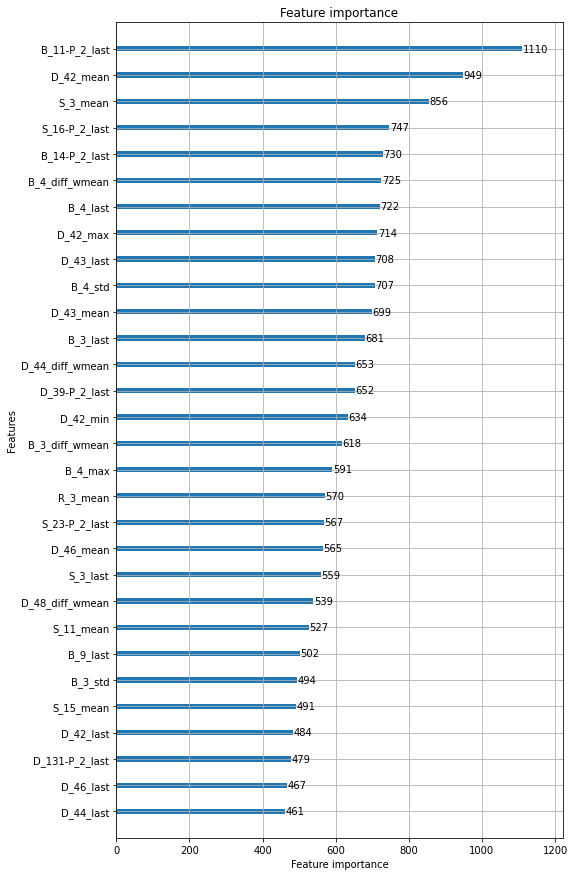

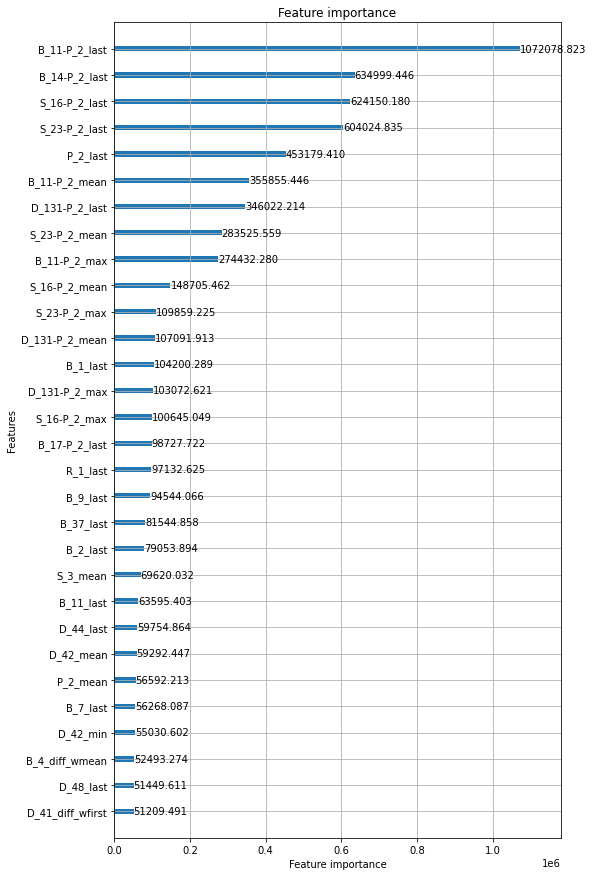

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.753914	valid_0's recall_at4: 0.606775	valid_0's norm_gini: 0.901054


[100]	valid_0's amex_metric: 0.76303	valid_0's recall_at4: 0.619651	valid_0's norm_gini: 0.906409


[150]	valid_0's amex_metric: 0.767368	valid_0's recall_at4: 0.626089	valid_0's norm_gini: 0.908648


[200]	valid_0's amex_metric: 0.768817	valid_0's recall_at4: 0.627688	valid_0's norm_gini: 0.909946


[250]	valid_0's amex_metric: 0.771978	valid_0's recall_at4: 0.63219	valid_0's norm_gini: 0.911766


[300]	valid_0's amex_metric: 0.77392	valid_0's recall_at4: 0.634504	valid_0's norm_gini: 0.913336


[350]	valid_0's amex_metric: 0.774894	valid_0's recall_at4: 0.635388	valid_0's norm_gini: 0.9144


[400]	valid_0's amex_metric: 0.777033	valid_0's recall_at4: 0.639007	valid_0's norm_gini: 0.915058


[450]	valid_0's amex_metric: 0.778112	valid_0's recall_at4: 0.640059	valid_0's norm_gini: 0.916165


[500]	valid_0's amex_metric: 0.780986	valid_0's recall_at4: 0.644646	valid_0's norm_gini: 0.917327


[550]	valid_0's amex_metric: 0.781896	valid_0's recall_at4: 0.645445	valid_0's norm_gini: 0.918346


[600]	valid_0's amex_metric: 0.783684	valid_0's recall_at4: 0.64818	valid_0's norm_gini: 0.919187


[650]	valid_0's amex_metric: 0.784827	valid_0's recall_at4: 0.650116	valid_0's norm_gini: 0.919539


[700]	valid_0's amex_metric: 0.785913	valid_0's recall_at4: 0.651799	valid_0's norm_gini: 0.920027


[750]	valid_0's amex_metric: 0.78713	valid_0's recall_at4: 0.653861	valid_0's norm_gini: 0.9204


[800]	valid_0's amex_metric: 0.786968	valid_0's recall_at4: 0.653187	valid_0's norm_gini: 0.920749


[850]	valid_0's amex_metric: 0.787779	valid_0's recall_at4: 0.654534	valid_0's norm_gini: 0.921025


[900]	valid_0's amex_metric: 0.788019	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.921336


[950]	valid_0's amex_metric: 0.788442	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.921677


[1000]	valid_0's amex_metric: 0.78944	valid_0's recall_at4: 0.65689	valid_0's norm_gini: 0.921989


[1050]	valid_0's amex_metric: 0.790085	valid_0's recall_at4: 0.657858	valid_0's norm_gini: 0.922311


[1100]	valid_0's amex_metric: 0.79074	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.922528


[1150]	valid_0's amex_metric: 0.791116	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.92269


[1200]	valid_0's amex_metric: 0.791328	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.922821


[1250]	valid_0's amex_metric: 0.791637	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.923016


[1300]	valid_0's amex_metric: 0.791501	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923039


[1350]	valid_0's amex_metric: 0.792289	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.923144


[1400]	valid_0's amex_metric: 0.792083	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.92332


[1450]	valid_0's amex_metric: 0.792821	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.92345


[1500]	valid_0's amex_metric: 0.792908	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.923541


[1550]	valid_0's amex_metric: 0.79229	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.92365


[1600]	valid_0's amex_metric: 0.792296	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.923789


[1650]	valid_0's amex_metric: 0.792322	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.923882


[1700]	valid_0's amex_metric: 0.792262	valid_0's recall_at4: 0.660551	valid_0's norm_gini: 0.923973


[1750]	valid_0's amex_metric: 0.792558	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.92406


[1800]	valid_0's amex_metric: 0.792781	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.924128


[1850]	valid_0's amex_metric: 0.793239	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.924243


[1900]	valid_0's amex_metric: 0.792863	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.924292


[1950]	valid_0's amex_metric: 0.793313	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924351


[2000]	valid_0's amex_metric: 0.793288	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.924426


[2050]	valid_0's amex_metric: 0.793621	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.924503


[2100]	valid_0's amex_metric: 0.793419	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924561


[2150]	valid_0's amex_metric: 0.793894	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.924669


[2200]	valid_0's amex_metric: 0.793458	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.924725


[2250]	valid_0's amex_metric: 0.793879	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.924766


[2300]	valid_0's amex_metric: 0.794177	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.924815


[2350]	valid_0's amex_metric: 0.794255	valid_0's recall_at4: 0.663707	valid_0's norm_gini: 0.924803


[2400]	valid_0's amex_metric: 0.794211	valid_0's recall_at4: 0.663581	valid_0's norm_gini: 0.924841


[2450]	valid_0's amex_metric: 0.793852	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.92488


[2500]	valid_0's amex_metric: 0.793657	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.924912


[2550]	valid_0's amex_metric: 0.793917	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924927


[2600]	valid_0's amex_metric: 0.793893	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.924963


[2650]	valid_0's amex_metric: 0.794331	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.924996


[2700]	valid_0's amex_metric: 0.794057	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.925038


[2750]	valid_0's amex_metric: 0.794646	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.925038


[2800]	valid_0's amex_metric: 0.794563	valid_0's recall_at4: 0.664044	valid_0's norm_gini: 0.925082


[2850]	valid_0's amex_metric: 0.794436	valid_0's recall_at4: 0.663791	valid_0's norm_gini: 0.925082


[2900]	valid_0's amex_metric: 0.794934	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.925109


[2950]	valid_0's amex_metric: 0.79524	valid_0's recall_at4: 0.665348	valid_0's norm_gini: 0.925133


[3000]	valid_0's amex_metric: 0.794671	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.925172


[3050]	valid_0's amex_metric: 0.795036	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.925186


[3100]	valid_0's amex_metric: 0.795429	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925214


[3150]	valid_0's amex_metric: 0.795626	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.92523


[3200]	valid_0's amex_metric: 0.795498	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.925228


[3250]	valid_0's amex_metric: 0.795668	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.925273


[3300]	valid_0's amex_metric: 0.795704	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.925261


[3350]	valid_0's amex_metric: 0.795641	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.925261


[3400]	valid_0's amex_metric: 0.795477	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.92527


[3450]	valid_0's amex_metric: 0.795886	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925288


[3500]	valid_0's amex_metric: 0.795746	valid_0's recall_at4: 0.66619	valid_0's norm_gini: 0.925302


[3550]	valid_0's amex_metric: 0.795775	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.925319


[3600]	valid_0's amex_metric: 0.79573	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.925313


[3650]	valid_0's amex_metric: 0.795568	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.925324


[3700]	valid_0's amex_metric: 0.795897	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925311


[3750]	valid_0's amex_metric: 0.795578	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.925303


[3800]	valid_0's amex_metric: 0.796156	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.925323


[3850]	valid_0's amex_metric: 0.796101	valid_0's recall_at4: 0.666863	valid_0's norm_gini: 0.92534


[3900]	valid_0's amex_metric: 0.796062	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.925346


[3950]	valid_0's amex_metric: 0.796335	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925343


[4000]	valid_0's amex_metric: 0.796219	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.925322


[4050]	valid_0's amex_metric: 0.796319	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925313


[4100]	valid_0's amex_metric: 0.796298	valid_0's recall_at4: 0.667284	valid_0's norm_gini: 0.925312


[4150]	valid_0's amex_metric: 0.795696	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925286


[4200]	valid_0's amex_metric: 0.795459	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925276


[4250]	valid_0's amex_metric: 0.79572	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.925292


[4300]	valid_0's amex_metric: 0.795442	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.925284


[4350]	valid_0's amex_metric: 0.795856	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.92527


[4400]	valid_0's amex_metric: 0.795225	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.925271


[4450]	valid_0's amex_metric: 0.795461	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925279


[4500]	valid_0's amex_metric: 0.795604	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.92527


[4550]	valid_0's amex_metric: 0.795102	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.925235


[4600]	valid_0's amex_metric: 0.795144	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.925234


[4650]	valid_0's amex_metric: 0.795499	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.92523


[4700]	valid_0's amex_metric: 0.795946	valid_0's recall_at4: 0.666653	valid_0's norm_gini: 0.925239


[4750]	valid_0's amex_metric: 0.795585	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.925232


[4800]	valid_0's amex_metric: 0.795324	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.925216


[4850]	valid_0's amex_metric: 0.795498	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.925227


[4900]	valid_0's amex_metric: 0.795692	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.925236


[4950]	valid_0's amex_metric: 0.79597	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.925244


[5000]	valid_0's amex_metric: 0.795817	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.925235


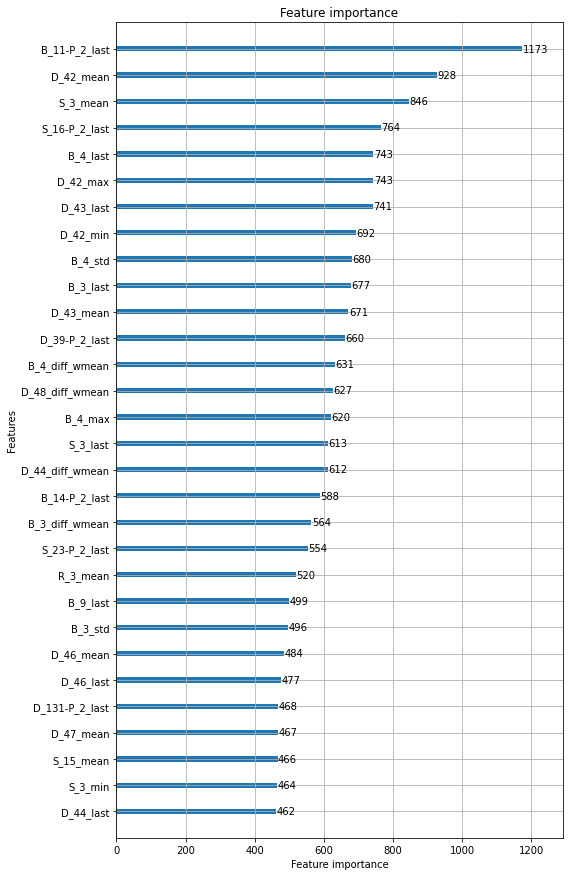

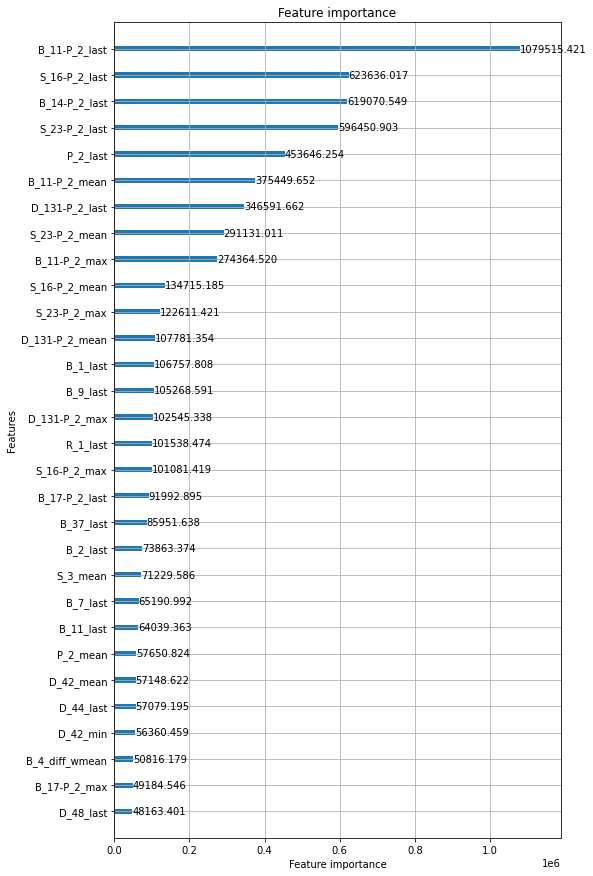

Training time: 119.91763844490052 min.
OOF recall_at4: 0.6681758508095735
OOF normalized_gini: 0.9257366348825123
OOF competition metric: 0.7969562428460429
Finished CV repeat 2 in: 119.0 min.


############################### repeated cross-validation step: 4/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.750146	valid_0's recall_at4: 0.600396	valid_0's norm_gini: 0.899897


[100]	valid_0's amex_metric: 0.759671	valid_0's recall_at4: 0.614197	valid_0's norm_gini: 0.905145


[150]	valid_0's amex_metric: 0.764216	valid_0's recall_at4: 0.620971	valid_0's norm_gini: 0.907461


[200]	valid_0's amex_metric: 0.765676	valid_0's recall_at4: 0.622612	valid_0's norm_gini: 0.90874


[250]	valid_0's amex_metric: 0.76916	valid_0's recall_at4: 0.627788	valid_0's norm_gini: 0.910533


[300]	valid_0's amex_metric: 0.771023	valid_0's recall_at4: 0.629934	valid_0's norm_gini: 0.912113


[350]	valid_0's amex_metric: 0.772352	valid_0's recall_at4: 0.631448	valid_0's norm_gini: 0.913256


[400]	valid_0's amex_metric: 0.773687	valid_0's recall_at4: 0.633468	valid_0's norm_gini: 0.913906


[450]	valid_0's amex_metric: 0.775162	valid_0's recall_at4: 0.635235	valid_0's norm_gini: 0.915089


[500]	valid_0's amex_metric: 0.778019	valid_0's recall_at4: 0.639737	valid_0's norm_gini: 0.916301


[550]	valid_0's amex_metric: 0.779212	valid_0's recall_at4: 0.641126	valid_0's norm_gini: 0.917297


[600]	valid_0's amex_metric: 0.782599	valid_0's recall_at4: 0.646891	valid_0's norm_gini: 0.918308


[650]	valid_0's amex_metric: 0.782657	valid_0's recall_at4: 0.646638	valid_0's norm_gini: 0.918676


[700]	valid_0's amex_metric: 0.784417	valid_0's recall_at4: 0.649626	valid_0's norm_gini: 0.919208


[750]	valid_0's amex_metric: 0.785002	valid_0's recall_at4: 0.650467	valid_0's norm_gini: 0.919537


[800]	valid_0's amex_metric: 0.78475	valid_0's recall_at4: 0.649626	valid_0's norm_gini: 0.919874


[850]	valid_0's amex_metric: 0.785222	valid_0's recall_at4: 0.650299	valid_0's norm_gini: 0.920145


[900]	valid_0's amex_metric: 0.785579	valid_0's recall_at4: 0.65072	valid_0's norm_gini: 0.920439


[950]	valid_0's amex_metric: 0.786218	valid_0's recall_at4: 0.651645	valid_0's norm_gini: 0.92079


[1000]	valid_0's amex_metric: 0.786618	valid_0's recall_at4: 0.652108	valid_0's norm_gini: 0.921129


[1050]	valid_0's amex_metric: 0.787241	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.921491


[1100]	valid_0's amex_metric: 0.78697	valid_0's recall_at4: 0.652276	valid_0's norm_gini: 0.921663


[1150]	valid_0's amex_metric: 0.78757	valid_0's recall_at4: 0.653286	valid_0's norm_gini: 0.921853


[1200]	valid_0's amex_metric: 0.788272	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.921996


[1250]	valid_0's amex_metric: 0.788071	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.922098


[1300]	valid_0's amex_metric: 0.788581	valid_0's recall_at4: 0.655011	valid_0's norm_gini: 0.922151


[1350]	valid_0's amex_metric: 0.788881	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.922288


[1400]	valid_0's amex_metric: 0.789103	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.92248


[1450]	valid_0's amex_metric: 0.789149	valid_0's recall_at4: 0.655685	valid_0's norm_gini: 0.922614


[1500]	valid_0's amex_metric: 0.789589	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.922694


[1550]	valid_0's amex_metric: 0.790049	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.922856


[1600]	valid_0's amex_metric: 0.790484	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.922969


[1650]	valid_0's amex_metric: 0.790328	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.923035


[1700]	valid_0's amex_metric: 0.790529	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.923143


[1750]	valid_0's amex_metric: 0.790555	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.923237


[1800]	valid_0's amex_metric: 0.791015	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.923315


[1850]	valid_0's amex_metric: 0.791159	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.923393


[1900]	valid_0's amex_metric: 0.791552	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923422


[1950]	valid_0's amex_metric: 0.79163	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.923452


[2000]	valid_0's amex_metric: 0.791467	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.923546


[2050]	valid_0's amex_metric: 0.791688	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.923653


[2100]	valid_0's amex_metric: 0.791845	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923714


[2150]	valid_0's amex_metric: 0.792569	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923731


[2200]	valid_0's amex_metric: 0.792287	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923797


[2250]	valid_0's amex_metric: 0.793053	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.923857


[2300]	valid_0's amex_metric: 0.793149	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.923881


[2350]	valid_0's amex_metric: 0.793205	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.923908


[2400]	valid_0's amex_metric: 0.79293	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.923947


[2450]	valid_0's amex_metric: 0.793109	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.92397


[2500]	valid_0's amex_metric: 0.793326	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.923984


[2550]	valid_0's amex_metric: 0.79297	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.924028


[2600]	valid_0's amex_metric: 0.792915	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.924085


[2650]	valid_0's amex_metric: 0.793328	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.924113


[2700]	valid_0's amex_metric: 0.793324	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.924147


[2750]	valid_0's amex_metric: 0.793183	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.924158


[2800]	valid_0's amex_metric: 0.793063	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.924173


[2850]	valid_0's amex_metric: 0.79293	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.9242


[2900]	valid_0's amex_metric: 0.792946	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.924233


[2950]	valid_0's amex_metric: 0.792825	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924242


[3000]	valid_0's amex_metric: 0.793146	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.924253


[3050]	valid_0's amex_metric: 0.793652	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924213


[3100]	valid_0's amex_metric: 0.792831	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924254


[3150]	valid_0's amex_metric: 0.793303	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.924273


[3200]	valid_0's amex_metric: 0.79364	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.924275


[3250]	valid_0's amex_metric: 0.793706	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924281


[3300]	valid_0's amex_metric: 0.793872	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.924276


[3350]	valid_0's amex_metric: 0.793858	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.92429


[3400]	valid_0's amex_metric: 0.794102	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924273


[3450]	valid_0's amex_metric: 0.794342	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924289


[3500]	valid_0's amex_metric: 0.793959	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924281


[3550]	valid_0's amex_metric: 0.794097	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924304


[3600]	valid_0's amex_metric: 0.793594	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924309


[3650]	valid_0's amex_metric: 0.793833	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.924323


[3700]	valid_0's amex_metric: 0.793851	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.924318


[3750]	valid_0's amex_metric: 0.794577	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.924338


[3800]	valid_0's amex_metric: 0.793712	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924335


[3850]	valid_0's amex_metric: 0.794067	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.92437


[3900]	valid_0's amex_metric: 0.793308	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924367


[3950]	valid_0's amex_metric: 0.793813	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924368


[4000]	valid_0's amex_metric: 0.793648	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.924374


[4050]	valid_0's amex_metric: 0.793831	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924403


[4100]	valid_0's amex_metric: 0.794259	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.924417


[4150]	valid_0's amex_metric: 0.793945	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.924421


[4200]	valid_0's amex_metric: 0.794043	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.924406


[4250]	valid_0's amex_metric: 0.794158	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924384


[4300]	valid_0's amex_metric: 0.793767	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.92436


[4350]	valid_0's amex_metric: 0.793909	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.924391


[4400]	valid_0's amex_metric: 0.793834	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924409


[4450]	valid_0's amex_metric: 0.793992	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.92443


[4500]	valid_0's amex_metric: 0.794034	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924432


[4550]	valid_0's amex_metric: 0.793911	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.924437


[4600]	valid_0's amex_metric: 0.793408	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924442


[4650]	valid_0's amex_metric: 0.793277	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.924431


[4700]	valid_0's amex_metric: 0.793855	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924452


[4750]	valid_0's amex_metric: 0.793791	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924449


[4800]	valid_0's amex_metric: 0.793469	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.924437


[4850]	valid_0's amex_metric: 0.793642	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.924445


[4900]	valid_0's amex_metric: 0.793403	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924431


[4950]	valid_0's amex_metric: 0.793672	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.924422


[5000]	valid_0's amex_metric: 0.793092	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.92444


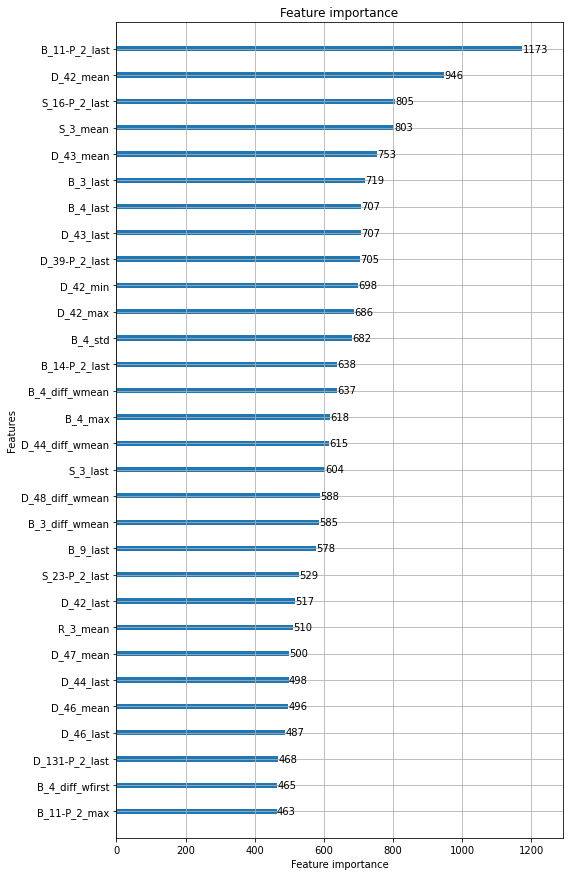

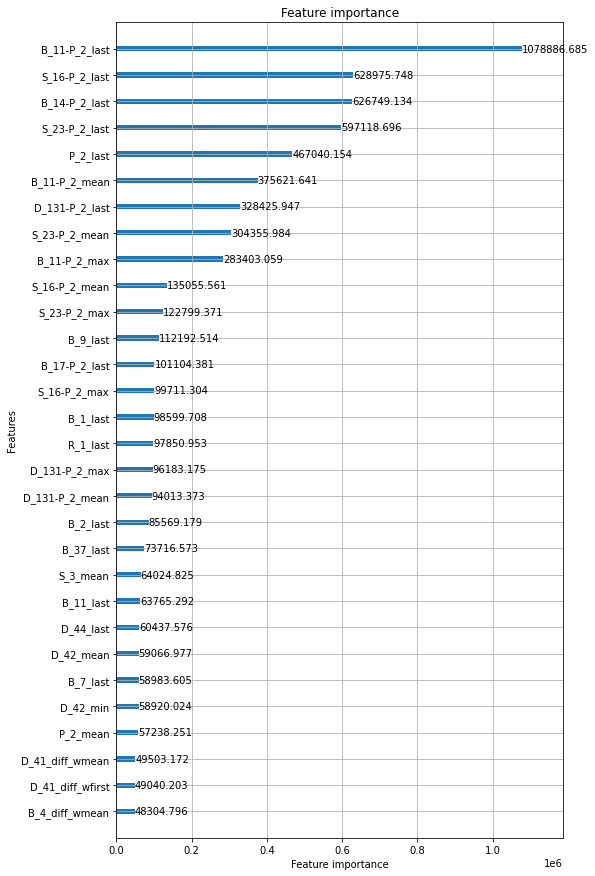

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.755611	valid_0's recall_at4: 0.607927	valid_0's norm_gini: 0.903296


[100]	valid_0's amex_metric: 0.763124	valid_0's recall_at4: 0.618362	valid_0's norm_gini: 0.907885


[150]	valid_0's amex_metric: 0.766958	valid_0's recall_at4: 0.623664	valid_0's norm_gini: 0.910251


[200]	valid_0's amex_metric: 0.769695	valid_0's recall_at4: 0.627703	valid_0's norm_gini: 0.911687


[250]	valid_0's amex_metric: 0.773195	valid_0's recall_at4: 0.633089	valid_0's norm_gini: 0.913301


[300]	valid_0's amex_metric: 0.775773	valid_0's recall_at4: 0.63675	valid_0's norm_gini: 0.914796


[350]	valid_0's amex_metric: 0.777683	valid_0's recall_at4: 0.639527	valid_0's norm_gini: 0.91584


[400]	valid_0's amex_metric: 0.778167	valid_0's recall_at4: 0.63978	valid_0's norm_gini: 0.916555


[450]	valid_0's amex_metric: 0.78117	valid_0's recall_at4: 0.644576	valid_0's norm_gini: 0.917764


[500]	valid_0's amex_metric: 0.782786	valid_0's recall_at4: 0.646638	valid_0's norm_gini: 0.918934


[550]	valid_0's amex_metric: 0.785369	valid_0's recall_at4: 0.650762	valid_0's norm_gini: 0.919975


[600]	valid_0's amex_metric: 0.787652	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.920882


[650]	valid_0's amex_metric: 0.788343	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.921296


[700]	valid_0's amex_metric: 0.789413	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.921838


[750]	valid_0's amex_metric: 0.790259	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.92214


[800]	valid_0's amex_metric: 0.79045	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.922437


[850]	valid_0's amex_metric: 0.791179	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.922761


[900]	valid_0's amex_metric: 0.792506	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.923058


[950]	valid_0's amex_metric: 0.792046	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.9234


[1000]	valid_0's amex_metric: 0.792834	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.923672


[1050]	valid_0's amex_metric: 0.793549	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924008


[1100]	valid_0's amex_metric: 0.794064	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924196


[1150]	valid_0's amex_metric: 0.794981	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.92439


[1200]	valid_0's amex_metric: 0.795209	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924509


[1250]	valid_0's amex_metric: 0.795288	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924708


[1300]	valid_0's amex_metric: 0.795594	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924732


[1350]	valid_0's amex_metric: 0.795973	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924817


[1400]	valid_0's amex_metric: 0.796131	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.924963


[1450]	valid_0's amex_metric: 0.796522	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.925116


[1500]	valid_0's amex_metric: 0.796683	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925226


[1550]	valid_0's amex_metric: 0.797614	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925405


[1600]	valid_0's amex_metric: 0.797292	valid_0's recall_at4: 0.669065	valid_0's norm_gini: 0.925519


[1650]	valid_0's amex_metric: 0.797733	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.925601


[1700]	valid_0's amex_metric: 0.797748	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925674


[1750]	valid_0's amex_metric: 0.798262	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.925776


[1800]	valid_0's amex_metric: 0.798374	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925831


[1850]	valid_0's amex_metric: 0.798236	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.925892


[1900]	valid_0's amex_metric: 0.798031	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.925945


[1950]	valid_0's amex_metric: 0.798113	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.926025


[2000]	valid_0's amex_metric: 0.798403	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926141


[2050]	valid_0's amex_metric: 0.798221	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.926242


[2100]	valid_0's amex_metric: 0.798672	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.926302


[2150]	valid_0's amex_metric: 0.799364	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926382


[2200]	valid_0's amex_metric: 0.799179	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926431


[2250]	valid_0's amex_metric: 0.798931	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.926441


[2300]	valid_0's amex_metric: 0.799497	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926478


[2350]	valid_0's amex_metric: 0.799081	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.926488


[2400]	valid_0's amex_metric: 0.798839	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.926551


[2450]	valid_0's amex_metric: 0.799556	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926555


[2500]	valid_0's amex_metric: 0.799438	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.92657


[2550]	valid_0's amex_metric: 0.799718	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.926625


[2600]	valid_0's amex_metric: 0.799752	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926652


[2650]	valid_0's amex_metric: 0.800067	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926651


[2700]	valid_0's amex_metric: 0.799544	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926657


[2750]	valid_0's amex_metric: 0.799301	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926676


[2800]	valid_0's amex_metric: 0.799719	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926713


[2850]	valid_0's amex_metric: 0.799977	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926724


[2900]	valid_0's amex_metric: 0.800188	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926725


[2950]	valid_0's amex_metric: 0.800503	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926723


[3000]	valid_0's amex_metric: 0.800381	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926732


[3050]	valid_0's amex_metric: 0.800888	valid_0's recall_at4: 0.67504	valid_0's norm_gini: 0.926737


[3100]	valid_0's amex_metric: 0.801279	valid_0's recall_at4: 0.675797	valid_0's norm_gini: 0.92676


[3150]	valid_0's amex_metric: 0.801752	valid_0's recall_at4: 0.676681	valid_0's norm_gini: 0.926823


[3200]	valid_0's amex_metric: 0.801225	valid_0's recall_at4: 0.675629	valid_0's norm_gini: 0.926821


[3250]	valid_0's amex_metric: 0.800848	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.926824


[3300]	valid_0's amex_metric: 0.800523	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926848


[3350]	valid_0's amex_metric: 0.801069	valid_0's recall_at4: 0.675292	valid_0's norm_gini: 0.926845


[3400]	valid_0's amex_metric: 0.801093	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.926852


[3450]	valid_0's amex_metric: 0.800801	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926857


[3500]	valid_0's amex_metric: 0.800841	valid_0's recall_at4: 0.67483	valid_0's norm_gini: 0.926853


[3550]	valid_0's amex_metric: 0.800423	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926857


[3600]	valid_0's amex_metric: 0.80055	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.92686


[3650]	valid_0's amex_metric: 0.800466	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.92686


[3700]	valid_0's amex_metric: 0.800135	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.92687


[3750]	valid_0's amex_metric: 0.800027	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926865


[3800]	valid_0's amex_metric: 0.800517	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926877


[3850]	valid_0's amex_metric: 0.801	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.926876


[3900]	valid_0's amex_metric: 0.800633	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.926857


[3950]	valid_0's amex_metric: 0.801043	valid_0's recall_at4: 0.675208	valid_0's norm_gini: 0.926878


[4000]	valid_0's amex_metric: 0.800884	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.926897


[4050]	valid_0's amex_metric: 0.800627	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.926929


[4100]	valid_0's amex_metric: 0.801214	valid_0's recall_at4: 0.675503	valid_0's norm_gini: 0.926924


[4150]	valid_0's amex_metric: 0.80075	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926924


[4200]	valid_0's amex_metric: 0.80036	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926943


[4250]	valid_0's amex_metric: 0.800509	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926946


[4300]	valid_0's amex_metric: 0.800614	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926945


[4350]	valid_0's amex_metric: 0.800063	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926937


[4400]	valid_0's amex_metric: 0.800597	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926953


[4450]	valid_0's amex_metric: 0.80049	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.92695


[4500]	valid_0's amex_metric: 0.799905	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926958


[4550]	valid_0's amex_metric: 0.800067	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926945


[4600]	valid_0's amex_metric: 0.800258	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926948


[4650]	valid_0's amex_metric: 0.800233	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926941


[4700]	valid_0's amex_metric: 0.800073	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926958


[4750]	valid_0's amex_metric: 0.800585	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926971


[4800]	valid_0's amex_metric: 0.800464	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926941


[4850]	valid_0's amex_metric: 0.800372	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.926924


[4900]	valid_0's amex_metric: 0.800232	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926897


[4950]	valid_0's amex_metric: 0.800332	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926886


[5000]	valid_0's amex_metric: 0.800226	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926884


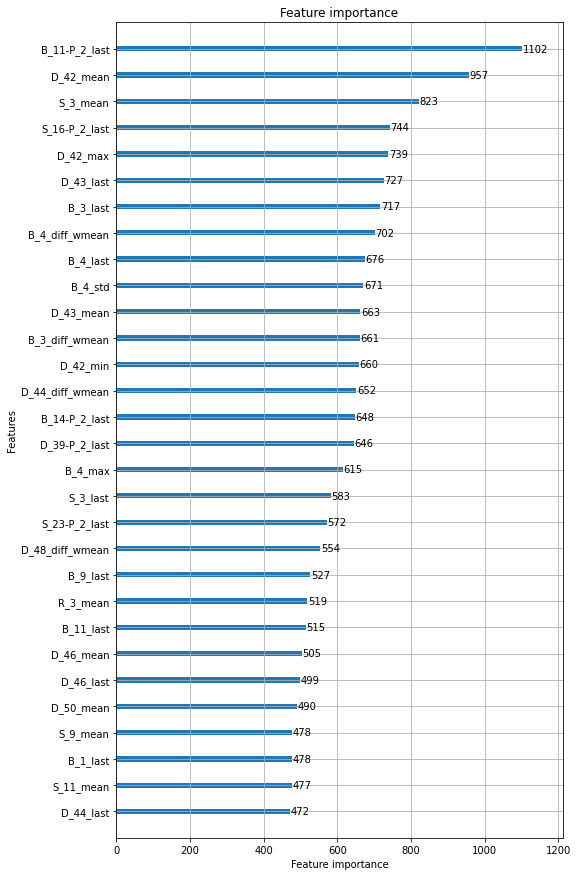

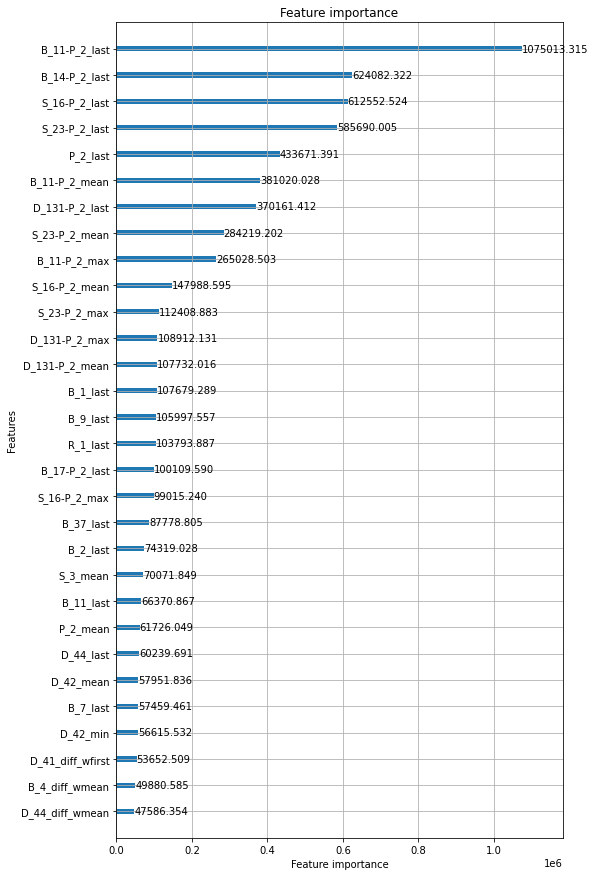

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] [LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.755163	valid_0's recall_at4: 0.607422	valid_0's norm_gini: 0.902904


[100]	valid_0's amex_metric: 0.763017	valid_0's recall_at4: 0.617773	valid_0's norm_gini: 0.908261


[150]	valid_0's amex_metric: 0.768762	valid_0's recall_at4: 0.626736	valid_0's norm_gini: 0.910788


[200]	valid_0's amex_metric: 0.771364	valid_0's recall_at4: 0.630438	valid_0's norm_gini: 0.91229


[250]	valid_0's amex_metric: 0.775629	valid_0's recall_at4: 0.637297	valid_0's norm_gini: 0.913962


[300]	valid_0's amex_metric: 0.777439	valid_0's recall_at4: 0.639401	valid_0's norm_gini: 0.915476


[350]	valid_0's amex_metric: 0.779743	valid_0's recall_at4: 0.642893	valid_0's norm_gini: 0.916593


[400]	valid_0's amex_metric: 0.780971	valid_0's recall_at4: 0.644618	valid_0's norm_gini: 0.917323


[450]	valid_0's amex_metric: 0.783862	valid_0's recall_at4: 0.649289	valid_0's norm_gini: 0.918434


[500]	valid_0's amex_metric: 0.785722	valid_0's recall_at4: 0.651814	valid_0's norm_gini: 0.91963


[550]	valid_0's amex_metric: 0.787413	valid_0's recall_at4: 0.654128	valid_0's norm_gini: 0.920697


[600]	valid_0's amex_metric: 0.788959	valid_0's recall_at4: 0.656274	valid_0's norm_gini: 0.921643


[650]	valid_0's amex_metric: 0.790151	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.922008


[700]	valid_0's amex_metric: 0.790588	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.922546


[750]	valid_0's amex_metric: 0.791503	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.922862


[800]	valid_0's amex_metric: 0.791576	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923175


[850]	valid_0's amex_metric: 0.791802	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.923459


[900]	valid_0's amex_metric: 0.792229	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.923724


[950]	valid_0's amex_metric: 0.793161	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.924116


[1000]	valid_0's amex_metric: 0.794216	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924459


[1050]	valid_0's amex_metric: 0.795041	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.924846


[1100]	valid_0's amex_metric: 0.795013	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.925042


[1150]	valid_0's amex_metric: 0.795984	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.925218


[1200]	valid_0's amex_metric: 0.79614	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.925361


[1250]	valid_0's amex_metric: 0.796832	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925524


[1300]	valid_0's amex_metric: 0.79725	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925603


[1350]	valid_0's amex_metric: 0.797637	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.925663


[1400]	valid_0's amex_metric: 0.798161	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.925827


[1450]	valid_0's amex_metric: 0.798664	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925949


[1500]	valid_0's amex_metric: 0.798444	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.926056


[1550]	valid_0's amex_metric: 0.798221	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.92624


[1600]	valid_0's amex_metric: 0.798217	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.926317


[1650]	valid_0's amex_metric: 0.79817	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.926392


[1700]	valid_0's amex_metric: 0.798287	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.926499


[1750]	valid_0's amex_metric: 0.798939	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.926582


[1800]	valid_0's amex_metric: 0.799148	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.926665


[1850]	valid_0's amex_metric: 0.799423	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926752


[1900]	valid_0's amex_metric: 0.799567	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926787


[1950]	valid_0's amex_metric: 0.800215	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926863


[2000]	valid_0's amex_metric: 0.800248	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926971


[2050]	valid_0's amex_metric: 0.800997	valid_0's recall_at4: 0.674914	valid_0's norm_gini: 0.92708


[2100]	valid_0's amex_metric: 0.800606	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.927139


[2150]	valid_0's amex_metric: 0.80093	valid_0's recall_at4: 0.674661	valid_0's norm_gini: 0.927199


[2200]	valid_0's amex_metric: 0.800613	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.927237


[2250]	valid_0's amex_metric: 0.800351	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.927262


[2300]	valid_0's amex_metric: 0.800442	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.927274


[2350]	valid_0's amex_metric: 0.800288	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.927303


[2400]	valid_0's amex_metric: 0.800339	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.927321


[2450]	valid_0's amex_metric: 0.800633	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.927361


[2500]	valid_0's amex_metric: 0.801141	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.92741


[2550]	valid_0's amex_metric: 0.801148	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.927424


[2600]	valid_0's amex_metric: 0.801034	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.92749


[2650]	valid_0's amex_metric: 0.800974	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.927538


[2700]	valid_0's amex_metric: 0.801379	valid_0's recall_at4: 0.675208	valid_0's norm_gini: 0.927551


[2750]	valid_0's amex_metric: 0.801393	valid_0's recall_at4: 0.675208	valid_0's norm_gini: 0.927578


[2800]	valid_0's amex_metric: 0.802018	valid_0's recall_at4: 0.676428	valid_0's norm_gini: 0.927607


[2850]	valid_0's amex_metric: 0.801671	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.927629


[2900]	valid_0's amex_metric: 0.801394	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.927664


[2950]	valid_0's amex_metric: 0.801273	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.927675


[3000]	valid_0's amex_metric: 0.801893	valid_0's recall_at4: 0.676092	valid_0's norm_gini: 0.927694


[3050]	valid_0's amex_metric: 0.80125	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.927712


[3100]	valid_0's amex_metric: 0.801133	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.927731


[3150]	valid_0's amex_metric: 0.800897	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.927764


[3200]	valid_0's amex_metric: 0.800562	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.927766


[3250]	valid_0's amex_metric: 0.800495	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.927802


[3300]	valid_0's amex_metric: 0.800545	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.927817


[3350]	valid_0's amex_metric: 0.800847	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.927831


[3400]	valid_0's amex_metric: 0.800512	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.927836


[3450]	valid_0's amex_metric: 0.800289	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.927851


[3500]	valid_0's amex_metric: 0.800372	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.927849


[3550]	valid_0's amex_metric: 0.80047	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.927835


[3600]	valid_0's amex_metric: 0.800938	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.927847


[3650]	valid_0's amex_metric: 0.800535	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.927839


[3700]	valid_0's amex_metric: 0.800647	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.927811


[3750]	valid_0's amex_metric: 0.801081	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.927837


[3800]	valid_0's amex_metric: 0.800505	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.927821


[3850]	valid_0's amex_metric: 0.800821	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.927863


[3900]	valid_0's amex_metric: 0.801364	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.927857


[3950]	valid_0's amex_metric: 0.801365	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.927858


[4000]	valid_0's amex_metric: 0.801496	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.927868


[4050]	valid_0's amex_metric: 0.801436	valid_0's recall_at4: 0.674998	valid_0's norm_gini: 0.927873


[4100]	valid_0's amex_metric: 0.801671	valid_0's recall_at4: 0.675461	valid_0's norm_gini: 0.927881


[4150]	valid_0's amex_metric: 0.801461	valid_0's recall_at4: 0.67504	valid_0's norm_gini: 0.927883


[4200]	valid_0's amex_metric: 0.801795	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.927877


[4250]	valid_0's amex_metric: 0.801221	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.927864


[4300]	valid_0's amex_metric: 0.801763	valid_0's recall_at4: 0.675671	valid_0's norm_gini: 0.927855


[4350]	valid_0's amex_metric: 0.801704	valid_0's recall_at4: 0.675545	valid_0's norm_gini: 0.927863


[4400]	valid_0's amex_metric: 0.801448	valid_0's recall_at4: 0.67504	valid_0's norm_gini: 0.927855


[4450]	valid_0's amex_metric: 0.801372	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.927873


[4500]	valid_0's amex_metric: 0.801689	valid_0's recall_at4: 0.675503	valid_0's norm_gini: 0.927875


[4550]	valid_0's amex_metric: 0.801792	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.92787


[4600]	valid_0's amex_metric: 0.801481	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.927879


[4650]	valid_0's amex_metric: 0.80127	valid_0's recall_at4: 0.674661	valid_0's norm_gini: 0.927878


[4700]	valid_0's amex_metric: 0.80129	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.927876


[4750]	valid_0's amex_metric: 0.800684	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.927842


[4800]	valid_0's amex_metric: 0.801211	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.927844


[4850]	valid_0's amex_metric: 0.80117	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.927847


[4900]	valid_0's amex_metric: 0.801575	valid_0's recall_at4: 0.675292	valid_0's norm_gini: 0.927858


[4950]	valid_0's amex_metric: 0.80086	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.927858


[5000]	valid_0's amex_metric: 0.800932	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.927835


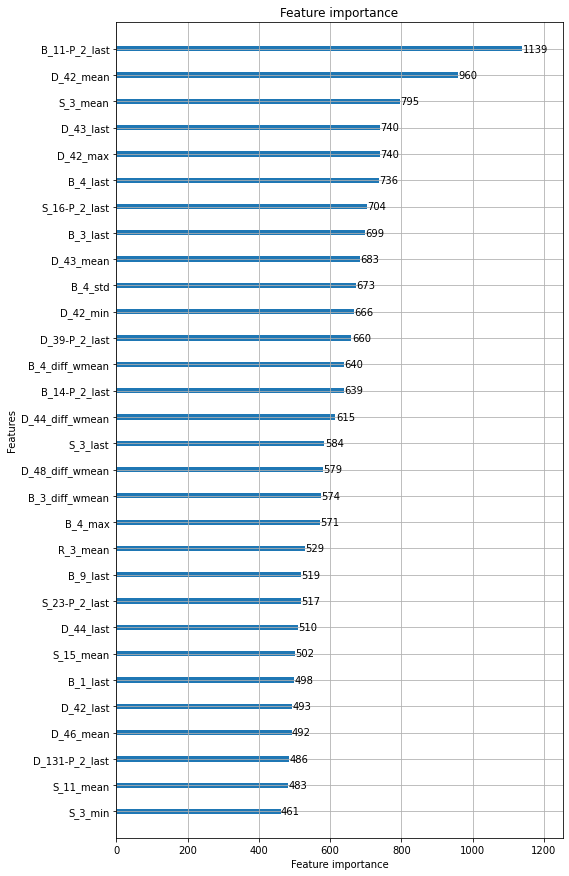

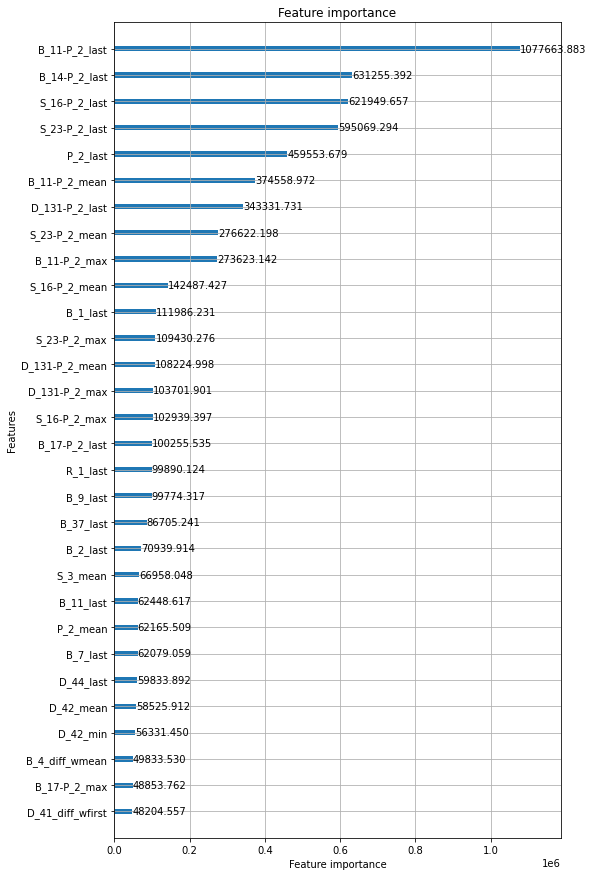

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.753277	valid_0's recall_at4: 0.605007	valid_0's norm_gini: 0.901546


[100]	valid_0's amex_metric: 0.761315	valid_0's recall_at4: 0.615695	valid_0's norm_gini: 0.906934


[150]	valid_0's amex_metric: 0.765032	valid_0's recall_at4: 0.620955	valid_0's norm_gini: 0.909109


[200]	valid_0's amex_metric: 0.767772	valid_0's recall_at4: 0.625121	valid_0's norm_gini: 0.910422


[250]	valid_0's amex_metric: 0.769917	valid_0's recall_at4: 0.627646	valid_0's norm_gini: 0.912188


[300]	valid_0's amex_metric: 0.772212	valid_0's recall_at4: 0.630717	valid_0's norm_gini: 0.913707


[350]	valid_0's amex_metric: 0.774188	valid_0's recall_at4: 0.633663	valid_0's norm_gini: 0.914712


[400]	valid_0's amex_metric: 0.77614	valid_0's recall_at4: 0.636861	valid_0's norm_gini: 0.915419


[450]	valid_0's amex_metric: 0.778176	valid_0's recall_at4: 0.639764	valid_0's norm_gini: 0.916588


[500]	valid_0's amex_metric: 0.781281	valid_0's recall_at4: 0.64473	valid_0's norm_gini: 0.917833


[550]	valid_0's amex_metric: 0.782947	valid_0's recall_at4: 0.647128	valid_0's norm_gini: 0.918765


[600]	valid_0's amex_metric: 0.784345	valid_0's recall_at4: 0.649106	valid_0's norm_gini: 0.919583


[650]	valid_0's amex_metric: 0.785556	valid_0's recall_at4: 0.651126	valid_0's norm_gini: 0.919986


[700]	valid_0's amex_metric: 0.786836	valid_0's recall_at4: 0.653145	valid_0's norm_gini: 0.920528


[750]	valid_0's amex_metric: 0.788097	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.920861


[800]	valid_0's amex_metric: 0.788385	valid_0's recall_at4: 0.655586	valid_0's norm_gini: 0.921184


[850]	valid_0's amex_metric: 0.789263	valid_0's recall_at4: 0.657017	valid_0's norm_gini: 0.921509


[900]	valid_0's amex_metric: 0.789353	valid_0's recall_at4: 0.656975	valid_0's norm_gini: 0.921731


[950]	valid_0's amex_metric: 0.789475	valid_0's recall_at4: 0.65689	valid_0's norm_gini: 0.922059


[1000]	valid_0's amex_metric: 0.790404	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.92236


[1050]	valid_0's amex_metric: 0.790792	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.922673


[1100]	valid_0's amex_metric: 0.792166	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.922896


[1150]	valid_0's amex_metric: 0.792223	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.923054


[1200]	valid_0's amex_metric: 0.792268	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.923228


[1250]	valid_0's amex_metric: 0.792629	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.923402


[1300]	valid_0's amex_metric: 0.792365	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.923421


[1350]	valid_0's amex_metric: 0.792311	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.923566


[1400]	valid_0's amex_metric: 0.79277	valid_0's recall_at4: 0.661772	valid_0's norm_gini: 0.923768


[1450]	valid_0's amex_metric: 0.793168	valid_0's recall_at4: 0.662445	valid_0's norm_gini: 0.923891


[1500]	valid_0's amex_metric: 0.793355	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924012


[1550]	valid_0's amex_metric: 0.792772	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.924152


[1600]	valid_0's amex_metric: 0.793253	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.92423


[1650]	valid_0's amex_metric: 0.793736	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.924354


[1700]	valid_0's amex_metric: 0.793751	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.924426


[1750]	valid_0's amex_metric: 0.793566	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.92452


[1800]	valid_0's amex_metric: 0.793877	valid_0's recall_at4: 0.66316	valid_0's norm_gini: 0.924593


[1850]	valid_0's amex_metric: 0.794519	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.924657


[1900]	valid_0's amex_metric: 0.794587	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.92471


[1950]	valid_0's amex_metric: 0.794197	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924772


[2000]	valid_0's amex_metric: 0.795141	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.92485


[2050]	valid_0's amex_metric: 0.794887	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.924973


[2100]	valid_0's amex_metric: 0.795234	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.925035


[2150]	valid_0's amex_metric: 0.795389	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925136


[2200]	valid_0's amex_metric: 0.79504	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.925194


[2250]	valid_0's amex_metric: 0.795443	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925244


[2300]	valid_0's amex_metric: 0.79553	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.925291


[2350]	valid_0's amex_metric: 0.796127	valid_0's recall_at4: 0.666905	valid_0's norm_gini: 0.925348


[2400]	valid_0's amex_metric: 0.796001	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.925391


[2450]	valid_0's amex_metric: 0.796385	valid_0's recall_at4: 0.667368	valid_0's norm_gini: 0.925401


[2500]	valid_0's amex_metric: 0.795891	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.925425


[2550]	valid_0's amex_metric: 0.795996	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.925465


[2600]	valid_0's amex_metric: 0.796075	valid_0's recall_at4: 0.666653	valid_0's norm_gini: 0.925497


[2650]	valid_0's amex_metric: 0.795976	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.925553


[2700]	valid_0's amex_metric: 0.795621	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925598


[2750]	valid_0's amex_metric: 0.795757	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.92562


[2800]	valid_0's amex_metric: 0.795877	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925647


[2850]	valid_0's amex_metric: 0.795627	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.925653


[2900]	valid_0's amex_metric: 0.795936	valid_0's recall_at4: 0.66619	valid_0's norm_gini: 0.925681


[2950]	valid_0's amex_metric: 0.795852	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.925682


[3000]	valid_0's amex_metric: 0.796027	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.925696


[3050]	valid_0's amex_metric: 0.796259	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.925739


[3100]	valid_0's amex_metric: 0.796418	valid_0's recall_at4: 0.667073	valid_0's norm_gini: 0.925763


[3150]	valid_0's amex_metric: 0.796392	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.925753


[3200]	valid_0's amex_metric: 0.796134	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925784


[3250]	valid_0's amex_metric: 0.796279	valid_0's recall_at4: 0.666737	valid_0's norm_gini: 0.925822


[3300]	valid_0's amex_metric: 0.796347	valid_0's recall_at4: 0.666863	valid_0's norm_gini: 0.925831


[3350]	valid_0's amex_metric: 0.796873	valid_0's recall_at4: 0.667873	valid_0's norm_gini: 0.925874


[3400]	valid_0's amex_metric: 0.797214	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.925882


[3450]	valid_0's amex_metric: 0.797012	valid_0's recall_at4: 0.668125	valid_0's norm_gini: 0.925899


[3500]	valid_0's amex_metric: 0.796611	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925896


[3550]	valid_0's amex_metric: 0.796585	valid_0's recall_at4: 0.667284	valid_0's norm_gini: 0.925886


[3600]	valid_0's amex_metric: 0.796196	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925907


[3650]	valid_0's amex_metric: 0.796762	valid_0's recall_at4: 0.66762	valid_0's norm_gini: 0.925904


[3700]	valid_0's amex_metric: 0.796562	valid_0's recall_at4: 0.667242	valid_0's norm_gini: 0.925882


[3750]	valid_0's amex_metric: 0.796328	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.925877


[3800]	valid_0's amex_metric: 0.797132	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925886


[3850]	valid_0's amex_metric: 0.797064	valid_0's recall_at4: 0.66821	valid_0's norm_gini: 0.925919


[3900]	valid_0's amex_metric: 0.79717	valid_0's recall_at4: 0.66842	valid_0's norm_gini: 0.92592


[3950]	valid_0's amex_metric: 0.797056	valid_0's recall_at4: 0.66821	valid_0's norm_gini: 0.925902


[4000]	valid_0's amex_metric: 0.797175	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925889


[4050]	valid_0's amex_metric: 0.796424	valid_0's recall_at4: 0.666947	valid_0's norm_gini: 0.9259


[4100]	valid_0's amex_metric: 0.79684	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.925891


[4150]	valid_0's amex_metric: 0.79771	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.925906


[4200]	valid_0's amex_metric: 0.797229	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.925911


[4250]	valid_0's amex_metric: 0.797186	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925911


[4300]	valid_0's amex_metric: 0.797026	valid_0's recall_at4: 0.668125	valid_0's norm_gini: 0.925927


[4350]	valid_0's amex_metric: 0.796822	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.925939


[4400]	valid_0's amex_metric: 0.797074	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.925981


[4450]	valid_0's amex_metric: 0.797474	valid_0's recall_at4: 0.668967	valid_0's norm_gini: 0.925981


[4500]	valid_0's amex_metric: 0.796885	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.925982


[4550]	valid_0's amex_metric: 0.79672	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.925988


[4600]	valid_0's amex_metric: 0.795878	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.925987


[4650]	valid_0's amex_metric: 0.796422	valid_0's recall_at4: 0.666863	valid_0's norm_gini: 0.925981


[4700]	valid_0's amex_metric: 0.796729	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.926005


[4750]	valid_0's amex_metric: 0.796938	valid_0's recall_at4: 0.667873	valid_0's norm_gini: 0.926004


[4800]	valid_0's amex_metric: 0.796532	valid_0's recall_at4: 0.667073	valid_0's norm_gini: 0.925991


[4850]	valid_0's amex_metric: 0.796554	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.925992


[4900]	valid_0's amex_metric: 0.796495	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.926001


[4950]	valid_0's amex_metric: 0.796765	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.925995


[5000]	valid_0's amex_metric: 0.796901	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.926012


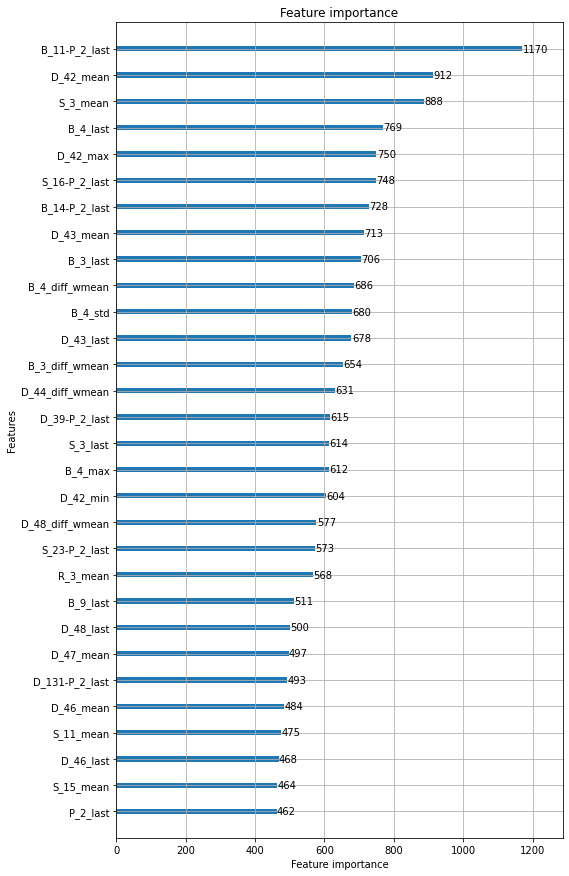

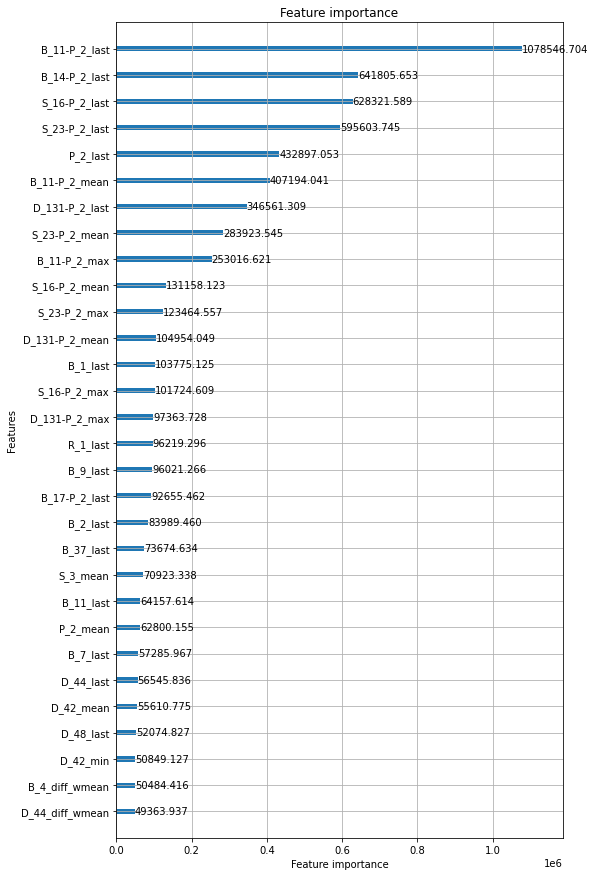

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.750295	valid_0's recall_at4: 0.599748	valid_0's norm_gini: 0.900842


[100]	valid_0's amex_metric: 0.75981	valid_0's recall_at4: 0.613507	valid_0's norm_gini: 0.906113


[150]	valid_0's amex_metric: 0.763666	valid_0's recall_at4: 0.618893	valid_0's norm_gini: 0.908439


[200]	valid_0's amex_metric: 0.765988	valid_0's recall_at4: 0.622175	valid_0's norm_gini: 0.909801


[250]	valid_0's amex_metric: 0.768145	valid_0's recall_at4: 0.624658	valid_0's norm_gini: 0.911631


[300]	valid_0's amex_metric: 0.771742	valid_0's recall_at4: 0.630297	valid_0's norm_gini: 0.913187


[350]	valid_0's amex_metric: 0.773064	valid_0's recall_at4: 0.631811	valid_0's norm_gini: 0.914316


[400]	valid_0's amex_metric: 0.774711	valid_0's recall_at4: 0.634462	valid_0's norm_gini: 0.914959


[450]	valid_0's amex_metric: 0.776872	valid_0's recall_at4: 0.637703	valid_0's norm_gini: 0.916041


[500]	valid_0's amex_metric: 0.77889	valid_0's recall_at4: 0.64048	valid_0's norm_gini: 0.9173


[550]	valid_0's amex_metric: 0.78182	valid_0's recall_at4: 0.645319	valid_0's norm_gini: 0.918321


[600]	valid_0's amex_metric: 0.783364	valid_0's recall_at4: 0.647507	valid_0's norm_gini: 0.919221


[650]	valid_0's amex_metric: 0.784068	valid_0's recall_at4: 0.648517	valid_0's norm_gini: 0.919619


[700]	valid_0's amex_metric: 0.7845	valid_0's recall_at4: 0.648853	valid_0's norm_gini: 0.920146


[750]	valid_0's amex_metric: 0.784876	valid_0's recall_at4: 0.649316	valid_0's norm_gini: 0.920436


[800]	valid_0's amex_metric: 0.786309	valid_0's recall_at4: 0.651841	valid_0's norm_gini: 0.920776


[850]	valid_0's amex_metric: 0.78606	valid_0's recall_at4: 0.651084	valid_0's norm_gini: 0.921036


[900]	valid_0's amex_metric: 0.786759	valid_0's recall_at4: 0.652135	valid_0's norm_gini: 0.921382


[950]	valid_0's amex_metric: 0.787429	valid_0's recall_at4: 0.653061	valid_0's norm_gini: 0.921797


[1000]	valid_0's amex_metric: 0.788125	valid_0's recall_at4: 0.654155	valid_0's norm_gini: 0.922095


[1050]	valid_0's amex_metric: 0.789001	valid_0's recall_at4: 0.655586	valid_0's norm_gini: 0.922415


[1100]	valid_0's amex_metric: 0.789444	valid_0's recall_at4: 0.656259	valid_0's norm_gini: 0.92263


[1150]	valid_0's amex_metric: 0.790031	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.922835


[1200]	valid_0's amex_metric: 0.790521	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.922974


[1250]	valid_0's amex_metric: 0.790469	valid_0's recall_at4: 0.657774	valid_0's norm_gini: 0.923164


[1300]	valid_0's amex_metric: 0.790592	valid_0's recall_at4: 0.657984	valid_0's norm_gini: 0.9232


[1350]	valid_0's amex_metric: 0.790338	valid_0's recall_at4: 0.657353	valid_0's norm_gini: 0.923323


[1400]	valid_0's amex_metric: 0.790759	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.923449


[1450]	valid_0's amex_metric: 0.791515	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.923532


[1500]	valid_0's amex_metric: 0.791704	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923655


[1550]	valid_0's amex_metric: 0.792143	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.923776


[1600]	valid_0's amex_metric: 0.792496	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.923894


[1650]	valid_0's amex_metric: 0.792769	valid_0's recall_at4: 0.661561	valid_0's norm_gini: 0.923977


[1700]	valid_0's amex_metric: 0.793154	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924032


[1750]	valid_0's amex_metric: 0.793682	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.924119


[1800]	valid_0's amex_metric: 0.793537	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924166


[1850]	valid_0's amex_metric: 0.793548	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.92423


[1900]	valid_0's amex_metric: 0.793482	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.924225


[1950]	valid_0's amex_metric: 0.793624	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.924257


[2000]	valid_0's amex_metric: 0.793596	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.924368


[2050]	valid_0's amex_metric: 0.794123	valid_0's recall_at4: 0.663791	valid_0's norm_gini: 0.924455


[2100]	valid_0's amex_metric: 0.793911	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.924536


[2150]	valid_0's amex_metric: 0.793935	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.924626


[2200]	valid_0's amex_metric: 0.794217	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.924684


[2250]	valid_0's amex_metric: 0.794169	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924715


[2300]	valid_0's amex_metric: 0.794319	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.924721


[2350]	valid_0's amex_metric: 0.794639	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924771


[2400]	valid_0's amex_metric: 0.794874	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.924778


[2450]	valid_0's amex_metric: 0.795164	valid_0's recall_at4: 0.665516	valid_0's norm_gini: 0.924812


[2500]	valid_0's amex_metric: 0.79521	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.924818


[2550]	valid_0's amex_metric: 0.795234	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924826


[2600]	valid_0's amex_metric: 0.794803	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.924847


[2650]	valid_0's amex_metric: 0.795141	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924892


[2700]	valid_0's amex_metric: 0.794296	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.924926


[2750]	valid_0's amex_metric: 0.794665	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.924949


[2800]	valid_0's amex_metric: 0.794885	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.924968


[2850]	valid_0's amex_metric: 0.794557	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924985


[2900]	valid_0's amex_metric: 0.794386	valid_0's recall_at4: 0.663791	valid_0's norm_gini: 0.92498


[2950]	valid_0's amex_metric: 0.793799	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.924985


[3000]	valid_0's amex_metric: 0.794015	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924995


[3050]	valid_0's amex_metric: 0.793903	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.925025


[3100]	valid_0's amex_metric: 0.793611	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.92503


[3150]	valid_0's amex_metric: 0.793936	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.925048


[3200]	valid_0's amex_metric: 0.793846	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.925079


[3250]	valid_0's amex_metric: 0.793739	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.925118


[3300]	valid_0's amex_metric: 0.79366	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.925086


[3350]	valid_0's amex_metric: 0.793449	valid_0's recall_at4: 0.661814	valid_0's norm_gini: 0.925084


[3400]	valid_0's amex_metric: 0.793665	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.925096


[3450]	valid_0's amex_metric: 0.793811	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.925136


[3500]	valid_0's amex_metric: 0.794	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.925135


[3550]	valid_0's amex_metric: 0.793875	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.925137


[3600]	valid_0's amex_metric: 0.79371	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.925144


[3650]	valid_0's amex_metric: 0.793722	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.925168


[3700]	valid_0's amex_metric: 0.793774	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.925145


[3750]	valid_0's amex_metric: 0.793687	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.925141


[3800]	valid_0's amex_metric: 0.794187	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.925172


[3850]	valid_0's amex_metric: 0.794055	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.92516


[3900]	valid_0's amex_metric: 0.793946	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.925195


[3950]	valid_0's amex_metric: 0.794403	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.925183


[4000]	valid_0's amex_metric: 0.794477	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.925204


[4050]	valid_0's amex_metric: 0.794238	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.925191


[4100]	valid_0's amex_metric: 0.794147	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.925175


[4150]	valid_0's amex_metric: 0.794298	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.925183


[4200]	valid_0's amex_metric: 0.794403	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.925183


[4250]	valid_0's amex_metric: 0.794142	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.925166


[4300]	valid_0's amex_metric: 0.7937	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.925124


[4350]	valid_0's amex_metric: 0.79355	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.925118


[4400]	valid_0's amex_metric: 0.793772	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.925142


[4450]	valid_0's amex_metric: 0.793959	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.925138


[4500]	valid_0's amex_metric: 0.7937	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.925123


[4550]	valid_0's amex_metric: 0.793488	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.925121


[4600]	valid_0's amex_metric: 0.793102	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.925105


[4650]	valid_0's amex_metric: 0.793577	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.92513


[4700]	valid_0's amex_metric: 0.793335	valid_0's recall_at4: 0.661561	valid_0's norm_gini: 0.92511


[4750]	valid_0's amex_metric: 0.792884	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.92509


[4800]	valid_0's amex_metric: 0.793242	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.925092


[4850]	valid_0's amex_metric: 0.793555	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.925087


[4900]	valid_0's amex_metric: 0.79321	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.925111


[4950]	valid_0's amex_metric: 0.793493	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.925089


[5000]	valid_0's amex_metric: 0.793686	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.925096


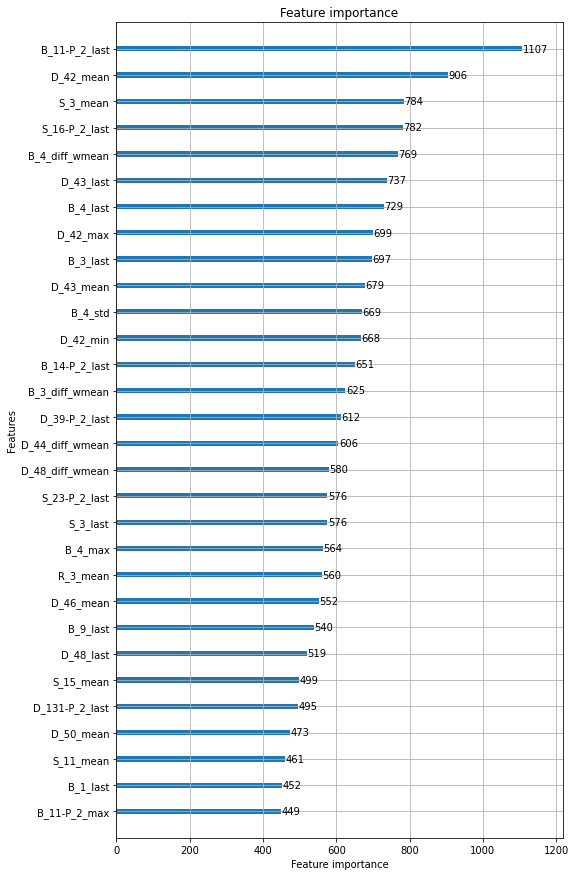

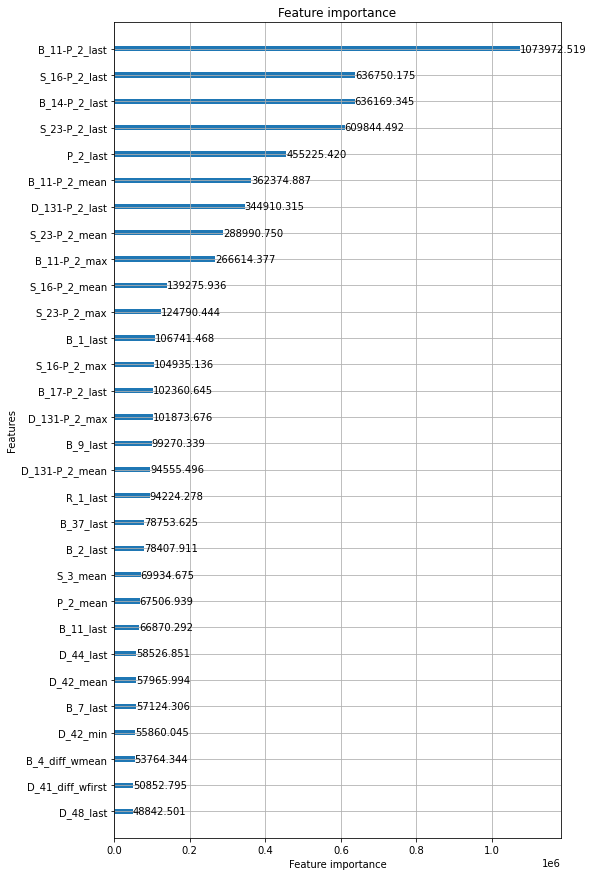

Training time: 120.16609432299931 min.
OOF recall_at4: 0.667864476386037
OOF normalized_gini: 0.9255943225541465
OOF competition metric: 0.7967293994700917
Finished CV repeat 3 in: 120.0 min.


############################### repeated cross-validation step: 5/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.755046	valid_0's recall_at4: 0.60818	valid_0's norm_gini: 0.901911


[100]	valid_0's amex_metric: 0.76163	valid_0's recall_at4: 0.616385	valid_0's norm_gini: 0.906875


[150]	valid_0's amex_metric: 0.765937	valid_0's recall_at4: 0.62257	valid_0's norm_gini: 0.909304


[200]	valid_0's amex_metric: 0.768414	valid_0's recall_at4: 0.625978	valid_0's norm_gini: 0.91085


[250]	valid_0's amex_metric: 0.771477	valid_0's recall_at4: 0.63027	valid_0's norm_gini: 0.912684


[300]	valid_0's amex_metric: 0.77495	valid_0's recall_at4: 0.635782	valid_0's norm_gini: 0.914117


[350]	valid_0's amex_metric: 0.776767	valid_0's recall_at4: 0.638223	valid_0's norm_gini: 0.91531


[400]	valid_0's amex_metric: 0.777413	valid_0's recall_at4: 0.638854	valid_0's norm_gini: 0.915972


[450]	valid_0's amex_metric: 0.779244	valid_0's recall_at4: 0.641378	valid_0's norm_gini: 0.91711


[500]	valid_0's amex_metric: 0.782379	valid_0's recall_at4: 0.646428	valid_0's norm_gini: 0.918331


[550]	valid_0's amex_metric: 0.784639	valid_0's recall_at4: 0.649962	valid_0's norm_gini: 0.919315


[600]	valid_0's amex_metric: 0.787029	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.920224


[650]	valid_0's amex_metric: 0.787915	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.92065


[700]	valid_0's amex_metric: 0.789051	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.921155


[750]	valid_0's amex_metric: 0.789228	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.921467


[800]	valid_0's amex_metric: 0.789934	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.921827


[850]	valid_0's amex_metric: 0.791251	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.922146


[900]	valid_0's amex_metric: 0.79135	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.92243


[950]	valid_0's amex_metric: 0.792075	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.922742


[1000]	valid_0's amex_metric: 0.793717	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.923039


[1050]	valid_0's amex_metric: 0.793989	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.923416


[1100]	valid_0's amex_metric: 0.794486	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.923694


[1150]	valid_0's amex_metric: 0.794708	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.923885


[1200]	valid_0's amex_metric: 0.794352	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.924016


[1250]	valid_0's amex_metric: 0.795091	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.924188


[1300]	valid_0's amex_metric: 0.795183	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.924203


[1350]	valid_0's amex_metric: 0.795702	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.924316


[1400]	valid_0's amex_metric: 0.795732	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.92446


[1450]	valid_0's amex_metric: 0.796269	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.92461


[1500]	valid_0's amex_metric: 0.796356	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.9247


[1550]	valid_0's amex_metric: 0.795941	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.924879


[1600]	valid_0's amex_metric: 0.796561	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.924984


[1650]	valid_0's amex_metric: 0.796251	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.925078


[1700]	valid_0's amex_metric: 0.796651	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925163


[1750]	valid_0's amex_metric: 0.797133	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925286


[1800]	valid_0's amex_metric: 0.797135	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925374


[1850]	valid_0's amex_metric: 0.797072	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.925416


[1900]	valid_0's amex_metric: 0.797324	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925457


[1950]	valid_0's amex_metric: 0.797361	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.92549


[2000]	valid_0's amex_metric: 0.797454	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.92559


[2050]	valid_0's amex_metric: 0.797731	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.925682


[2100]	valid_0's amex_metric: 0.7979	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925809


[2150]	valid_0's amex_metric: 0.798451	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.9259


[2200]	valid_0's amex_metric: 0.798717	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.92597


[2250]	valid_0's amex_metric: 0.798526	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.926008


[2300]	valid_0's amex_metric: 0.798573	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.926019


[2350]	valid_0's amex_metric: 0.798849	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.926025


[2400]	valid_0's amex_metric: 0.798712	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.926044


[2450]	valid_0's amex_metric: 0.799217	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926087


[2500]	valid_0's amex_metric: 0.799071	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926132


[2550]	valid_0's amex_metric: 0.799035	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926185


[2600]	valid_0's amex_metric: 0.79848	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.926212


[2650]	valid_0's amex_metric: 0.799095	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.926222


[2700]	valid_0's amex_metric: 0.799618	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.926257


[2750]	valid_0's amex_metric: 0.799572	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926293


[2800]	valid_0's amex_metric: 0.799811	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926308


[2850]	valid_0's amex_metric: 0.799741	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926336


[2900]	valid_0's amex_metric: 0.799285	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926349


[2950]	valid_0's amex_metric: 0.799228	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926319


[3000]	valid_0's amex_metric: 0.799763	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926337


[3050]	valid_0's amex_metric: 0.799789	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926389


[3100]	valid_0's amex_metric: 0.799596	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.926383


[3150]	valid_0's amex_metric: 0.799882	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.926406


[3200]	valid_0's amex_metric: 0.800405	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.926401


[3250]	valid_0's amex_metric: 0.800646	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.92642


[3300]	valid_0's amex_metric: 0.800114	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926451


[3350]	valid_0's amex_metric: 0.800608	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926471


[3400]	valid_0's amex_metric: 0.79986	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926489


[3450]	valid_0's amex_metric: 0.799817	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926487


[3500]	valid_0's amex_metric: 0.799613	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926501


[3550]	valid_0's amex_metric: 0.799774	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.926528


[3600]	valid_0's amex_metric: 0.800038	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.92655


[3650]	valid_0's amex_metric: 0.800038	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.92655


[3700]	valid_0's amex_metric: 0.800088	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926567


[3750]	valid_0's amex_metric: 0.800238	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.926573


[3800]	valid_0's amex_metric: 0.800112	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926572


[3850]	valid_0's amex_metric: 0.800137	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.92658


[3900]	valid_0's amex_metric: 0.799975	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.926593


[3950]	valid_0's amex_metric: 0.799849	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.926593


[4000]	valid_0's amex_metric: 0.799909	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.92663


[4050]	valid_0's amex_metric: 0.799851	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926639


[4100]	valid_0's amex_metric: 0.79985	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926637


[4150]	valid_0's amex_metric: 0.79985	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926638


[4200]	valid_0's amex_metric: 0.79919	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926664


[4250]	valid_0's amex_metric: 0.79883	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.92666


[4300]	valid_0's amex_metric: 0.799477	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.92665


[4350]	valid_0's amex_metric: 0.799461	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.926659


[4400]	valid_0's amex_metric: 0.799552	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926673


[4450]	valid_0's amex_metric: 0.800098	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926671


[4500]	valid_0's amex_metric: 0.800035	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926671


[4550]	valid_0's amex_metric: 0.800038	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926678


[4600]	valid_0's amex_metric: 0.800441	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926683


[4650]	valid_0's amex_metric: 0.800186	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.926677


[4700]	valid_0's amex_metric: 0.800597	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.926701


[4750]	valid_0's amex_metric: 0.800606	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.926719


[4800]	valid_0's amex_metric: 0.800954	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.926741


[4850]	valid_0's amex_metric: 0.800958	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.92675


[4900]	valid_0's amex_metric: 0.800804	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.926736


[4950]	valid_0's amex_metric: 0.80123	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.926746


[5000]	valid_0's amex_metric: 0.801229	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.926745


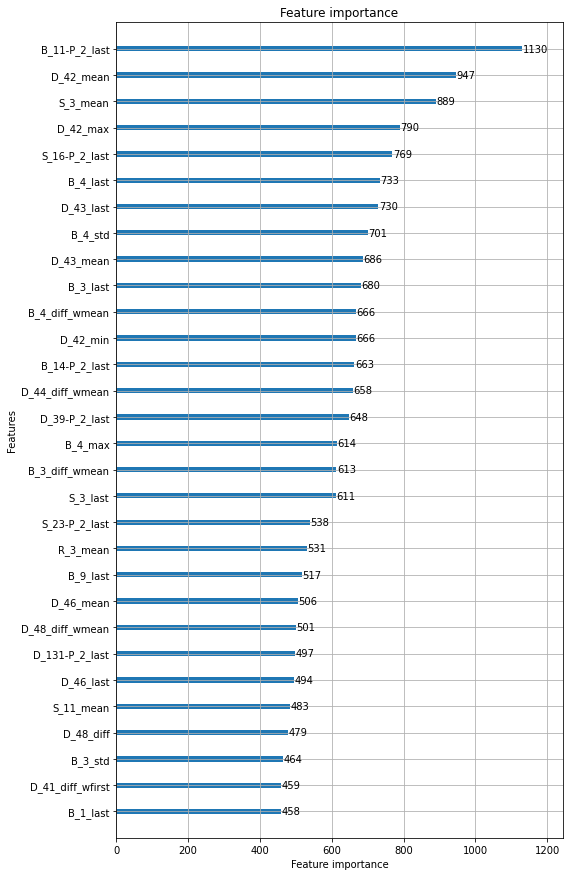

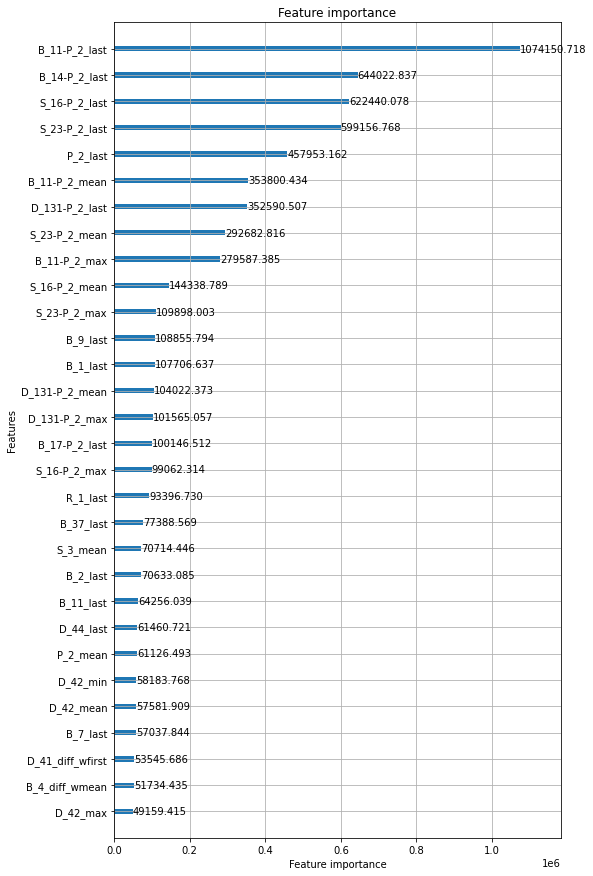

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.756154	valid_0's recall_at4: 0.608979	valid_0's norm_gini: 0.90333


[100]	valid_0's amex_metric: 0.766818	valid_0's recall_at4: 0.624968	valid_0's norm_gini: 0.908668


[150]	valid_0's amex_metric: 0.771053	valid_0's recall_at4: 0.63107	valid_0's norm_gini: 0.911036


[200]	valid_0's amex_metric: 0.773029	valid_0's recall_at4: 0.633678	valid_0's norm_gini: 0.91238


[250]	valid_0's amex_metric: 0.775573	valid_0's recall_at4: 0.637002	valid_0's norm_gini: 0.914144


[300]	valid_0's amex_metric: 0.779138	valid_0's recall_at4: 0.642515	valid_0's norm_gini: 0.915761


[350]	valid_0's amex_metric: 0.780865	valid_0's recall_at4: 0.644997	valid_0's norm_gini: 0.916732


[400]	valid_0's amex_metric: 0.782044	valid_0's recall_at4: 0.64668	valid_0's norm_gini: 0.917407


[450]	valid_0's amex_metric: 0.785042	valid_0's recall_at4: 0.651561	valid_0's norm_gini: 0.918522


[500]	valid_0's amex_metric: 0.786145	valid_0's recall_at4: 0.652529	valid_0's norm_gini: 0.919761


[550]	valid_0's amex_metric: 0.787515	valid_0's recall_at4: 0.654128	valid_0's norm_gini: 0.920902


[600]	valid_0's amex_metric: 0.790319	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.921756


[650]	valid_0's amex_metric: 0.79094	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.922155


[700]	valid_0's amex_metric: 0.792121	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.922708


[750]	valid_0's amex_metric: 0.792183	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.923002


[800]	valid_0's amex_metric: 0.792543	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.923342


[850]	valid_0's amex_metric: 0.793125	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.923622


[900]	valid_0's amex_metric: 0.793521	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.923909


[950]	valid_0's amex_metric: 0.793572	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924264


[1000]	valid_0's amex_metric: 0.794604	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.924562


[1050]	valid_0's amex_metric: 0.794706	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.924934


[1100]	valid_0's amex_metric: 0.795392	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.925169


[1150]	valid_0's amex_metric: 0.796054	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.925357


[1200]	valid_0's amex_metric: 0.79588	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.925472


[1250]	valid_0's amex_metric: 0.79607	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.925683


[1300]	valid_0's amex_metric: 0.7961	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.925702


[1350]	valid_0's amex_metric: 0.79651	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.925848


[1400]	valid_0's amex_metric: 0.797004	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925995


[1450]	valid_0's amex_metric: 0.797427	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.926126


[1500]	valid_0's amex_metric: 0.797417	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.926191


[1550]	valid_0's amex_metric: 0.798115	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.926323


[1600]	valid_0's amex_metric: 0.798927	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.926433


[1650]	valid_0's amex_metric: 0.798294	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.926512


[1700]	valid_0's amex_metric: 0.798465	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.926561


[1750]	valid_0's amex_metric: 0.798456	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.926668


[1800]	valid_0's amex_metric: 0.798462	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.926723


[1850]	valid_0's amex_metric: 0.799146	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926828


[1900]	valid_0's amex_metric: 0.798885	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926895


[1950]	valid_0's amex_metric: 0.799237	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.926927


[2000]	valid_0's amex_metric: 0.799428	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.927056


[2050]	valid_0's amex_metric: 0.799809	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.927188


[2100]	valid_0's amex_metric: 0.79995	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.927217


[2150]	valid_0's amex_metric: 0.800137	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.927253


[2200]	valid_0's amex_metric: 0.800232	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.927276


[2250]	valid_0's amex_metric: 0.800092	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.927289


[2300]	valid_0's amex_metric: 0.799904	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.927294


[2350]	valid_0's amex_metric: 0.799827	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.927307


[2400]	valid_0's amex_metric: 0.799913	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.927352


[2450]	valid_0's amex_metric: 0.799738	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.927381


[2500]	valid_0's amex_metric: 0.800298	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.927408


[2550]	valid_0's amex_metric: 0.800486	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.927446


[2600]	valid_0's amex_metric: 0.800189	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.927483


[2650]	valid_0's amex_metric: 0.800528	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.927531


[2700]	valid_0's amex_metric: 0.800346	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.927545


[2750]	valid_0's amex_metric: 0.800476	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.927553


[2800]	valid_0's amex_metric: 0.799874	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.92757


[2850]	valid_0's amex_metric: 0.800625	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.927598


[2900]	valid_0's amex_metric: 0.800851	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.92763


[2950]	valid_0's amex_metric: 0.800857	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.927641


[3000]	valid_0's amex_metric: 0.800452	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.927672


[3050]	valid_0's amex_metric: 0.800855	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.927681


[3100]	valid_0's amex_metric: 0.800771	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.927723


[3150]	valid_0's amex_metric: 0.801034	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.927743


[3200]	valid_0's amex_metric: 0.80046	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.927732


[3250]	valid_0's amex_metric: 0.80144	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.927757


[3300]	valid_0's amex_metric: 0.800932	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.927749


[3350]	valid_0's amex_metric: 0.801111	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.927771


[3400]	valid_0's amex_metric: 0.801428	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.927774


[3450]	valid_0's amex_metric: 0.801254	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.927804


[3500]	valid_0's amex_metric: 0.800891	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.927794


[3550]	valid_0's amex_metric: 0.800733	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.927772


[3600]	valid_0's amex_metric: 0.801064	valid_0's recall_at4: 0.674367	valid_0's norm_gini: 0.927761


[3650]	valid_0's amex_metric: 0.801081	valid_0's recall_at4: 0.674367	valid_0's norm_gini: 0.927794


[3700]	valid_0's amex_metric: 0.801136	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.927778


[3750]	valid_0's amex_metric: 0.800598	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.927798


[3800]	valid_0's amex_metric: 0.801016	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.927791


[3850]	valid_0's amex_metric: 0.801221	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.927822


[3900]	valid_0's amex_metric: 0.800975	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.927836


[3950]	valid_0's amex_metric: 0.8008	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.927823


[4000]	valid_0's amex_metric: 0.801073	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.927821


[4050]	valid_0's amex_metric: 0.8012	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.927822


[4100]	valid_0's amex_metric: 0.801396	valid_0's recall_at4: 0.674956	valid_0's norm_gini: 0.927835


[4150]	valid_0's amex_metric: 0.801588	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.927841


[4200]	valid_0's amex_metric: 0.801546	valid_0's recall_at4: 0.67525	valid_0's norm_gini: 0.927842


[4250]	valid_0's amex_metric: 0.801129	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.927849


[4300]	valid_0's amex_metric: 0.801396	valid_0's recall_at4: 0.674956	valid_0's norm_gini: 0.927836


[4350]	valid_0's amex_metric: 0.801391	valid_0's recall_at4: 0.674956	valid_0's norm_gini: 0.927827


[4400]	valid_0's amex_metric: 0.801995	valid_0's recall_at4: 0.676176	valid_0's norm_gini: 0.927814


[4450]	valid_0's amex_metric: 0.801469	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.927814


[4500]	valid_0's amex_metric: 0.801219	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.927819


[4550]	valid_0's amex_metric: 0.80133	valid_0's recall_at4: 0.67483	valid_0's norm_gini: 0.927829


[4600]	valid_0's amex_metric: 0.801713	valid_0's recall_at4: 0.675629	valid_0's norm_gini: 0.927796


[4650]	valid_0's amex_metric: 0.801538	valid_0's recall_at4: 0.675292	valid_0's norm_gini: 0.927784


[4700]	valid_0's amex_metric: 0.801465	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.927764


[4750]	valid_0's amex_metric: 0.801597	valid_0's recall_at4: 0.675419	valid_0's norm_gini: 0.927775


[4800]	valid_0's amex_metric: 0.802329	valid_0's recall_at4: 0.676891	valid_0's norm_gini: 0.927766


[4850]	valid_0's amex_metric: 0.80182	valid_0's recall_at4: 0.675882	valid_0's norm_gini: 0.927759


[4900]	valid_0's amex_metric: 0.801641	valid_0's recall_at4: 0.675545	valid_0's norm_gini: 0.927738


[4950]	valid_0's amex_metric: 0.801571	valid_0's recall_at4: 0.675419	valid_0's norm_gini: 0.927723


[5000]	valid_0's amex_metric: 0.802141	valid_0's recall_at4: 0.676555	valid_0's norm_gini: 0.927727


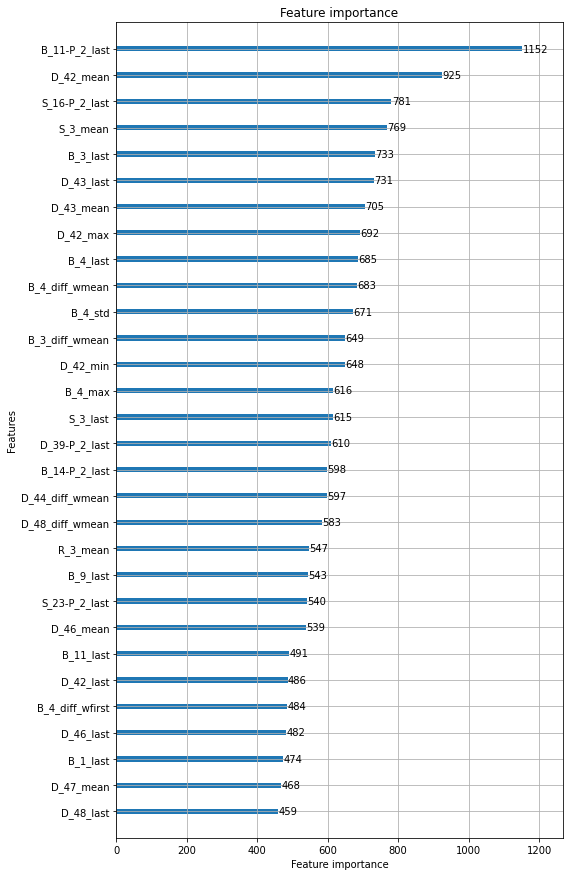

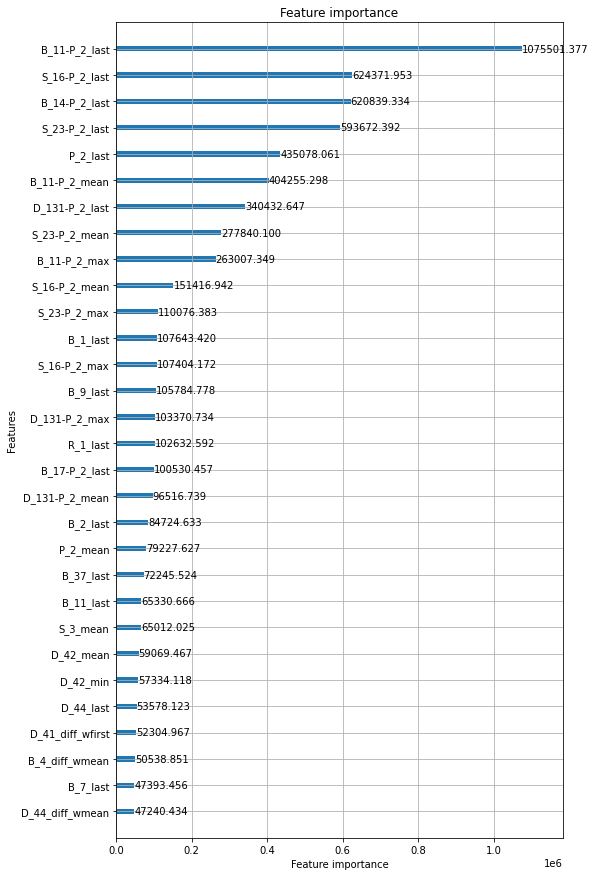

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.751752	valid_0's recall_at4: 0.6017	valid_0's norm_gini: 0.901804


[100]	valid_0's amex_metric: 0.760529	valid_0's recall_at4: 0.614113	valid_0's norm_gini: 0.906945


[150]	valid_0's amex_metric: 0.763924	valid_0's recall_at4: 0.618699	valid_0's norm_gini: 0.90915


[200]	valid_0's amex_metric: 0.765778	valid_0's recall_at4: 0.621055	valid_0's norm_gini: 0.910502


[250]	valid_0's amex_metric: 0.769832	valid_0's recall_at4: 0.627451	valid_0's norm_gini: 0.912214


[300]	valid_0's amex_metric: 0.773045	valid_0's recall_at4: 0.63229	valid_0's norm_gini: 0.913799


[350]	valid_0's amex_metric: 0.774843	valid_0's recall_at4: 0.634814	valid_0's norm_gini: 0.914871


[400]	valid_0's amex_metric: 0.775492	valid_0's recall_at4: 0.635488	valid_0's norm_gini: 0.915496


[450]	valid_0's amex_metric: 0.778073	valid_0's recall_at4: 0.639485	valid_0's norm_gini: 0.916662


[500]	valid_0's amex_metric: 0.779306	valid_0's recall_at4: 0.640663	valid_0's norm_gini: 0.917949


[550]	valid_0's amex_metric: 0.781098	valid_0's recall_at4: 0.64323	valid_0's norm_gini: 0.918967


[600]	valid_0's amex_metric: 0.782776	valid_0's recall_at4: 0.645628	valid_0's norm_gini: 0.919923


[650]	valid_0's amex_metric: 0.783436	valid_0's recall_at4: 0.646512	valid_0's norm_gini: 0.92036


[700]	valid_0's amex_metric: 0.784453	valid_0's recall_at4: 0.648027	valid_0's norm_gini: 0.92088


[750]	valid_0's amex_metric: 0.785039	valid_0's recall_at4: 0.64891	valid_0's norm_gini: 0.921167


[800]	valid_0's amex_metric: 0.785565	valid_0's recall_at4: 0.649626	valid_0's norm_gini: 0.921505


[850]	valid_0's amex_metric: 0.78598	valid_0's recall_at4: 0.650173	valid_0's norm_gini: 0.921788


[900]	valid_0's amex_metric: 0.786806	valid_0's recall_at4: 0.651561	valid_0's norm_gini: 0.92205


[950]	valid_0's amex_metric: 0.786978	valid_0's recall_at4: 0.651561	valid_0's norm_gini: 0.922396


[1000]	valid_0's amex_metric: 0.787407	valid_0's recall_at4: 0.65215	valid_0's norm_gini: 0.922663


[1050]	valid_0's amex_metric: 0.788366	valid_0's recall_at4: 0.653707	valid_0's norm_gini: 0.923026


[1100]	valid_0's amex_metric: 0.788975	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.923275


[1150]	valid_0's amex_metric: 0.789353	valid_0's recall_at4: 0.655264	valid_0's norm_gini: 0.923443


[1200]	valid_0's amex_metric: 0.790183	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.923587


[1250]	valid_0's amex_metric: 0.791214	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.923756


[1300]	valid_0's amex_metric: 0.791968	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.92379


[1350]	valid_0's amex_metric: 0.791963	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.923907


[1400]	valid_0's amex_metric: 0.791853	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.924067


[1450]	valid_0's amex_metric: 0.79173	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.924157


[1500]	valid_0's amex_metric: 0.792174	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.924286


[1550]	valid_0's amex_metric: 0.792626	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.924434


[1600]	valid_0's amex_metric: 0.793141	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.924539


[1650]	valid_0's amex_metric: 0.793411	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.924616


[1700]	valid_0's amex_metric: 0.793408	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.924694


[1750]	valid_0's amex_metric: 0.794364	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924797


[1800]	valid_0's amex_metric: 0.794203	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.924895


[1850]	valid_0's amex_metric: 0.793585	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.924963


[1900]	valid_0's amex_metric: 0.793271	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.925009


[1950]	valid_0's amex_metric: 0.793461	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.925051


[2000]	valid_0's amex_metric: 0.793922	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.925132


[2050]	valid_0's amex_metric: 0.794421	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.925205


[2100]	valid_0's amex_metric: 0.794768	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.925267


[2150]	valid_0's amex_metric: 0.794634	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.925336


[2200]	valid_0's amex_metric: 0.794712	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.925367


[2250]	valid_0's amex_metric: 0.795176	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.925411


[2300]	valid_0's amex_metric: 0.795121	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.925427


[2350]	valid_0's amex_metric: 0.795318	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.925442


[2400]	valid_0's amex_metric: 0.794951	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.925466


[2450]	valid_0's amex_metric: 0.794962	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.925487


[2500]	valid_0's amex_metric: 0.794535	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.925518


[2550]	valid_0's amex_metric: 0.794735	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.925538


[2600]	valid_0's amex_metric: 0.794986	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.925578


[2650]	valid_0's amex_metric: 0.795194	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.925614


[2700]	valid_0's amex_metric: 0.794368	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925646


[2750]	valid_0's amex_metric: 0.794899	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925656


[2800]	valid_0's amex_metric: 0.79501	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.925667


[2850]	valid_0's amex_metric: 0.795223	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.925672


[2900]	valid_0's amex_metric: 0.795317	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.925693


[2950]	valid_0's amex_metric: 0.795594	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.9257


[3000]	valid_0's amex_metric: 0.795704	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.92571


[3050]	valid_0's amex_metric: 0.795979	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.925755


[3100]	valid_0's amex_metric: 0.795853	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.925797


[3150]	valid_0's amex_metric: 0.796157	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.925816


[3200]	valid_0's amex_metric: 0.795957	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.925836


[3250]	valid_0's amex_metric: 0.795855	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.925843


[3300]	valid_0's amex_metric: 0.795906	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.92586


[3350]	valid_0's amex_metric: 0.795673	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.925857


[3400]	valid_0's amex_metric: 0.796314	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.925877


[3450]	valid_0's amex_metric: 0.796555	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.925897


[3500]	valid_0's amex_metric: 0.796464	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.925883


[3550]	valid_0's amex_metric: 0.79626	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.925894


[3600]	valid_0's amex_metric: 0.796408	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.925896


[3650]	valid_0's amex_metric: 0.79674	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.925887


[3700]	valid_0's amex_metric: 0.797152	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.925913


[3750]	valid_0's amex_metric: 0.796942	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.925912


[3800]	valid_0's amex_metric: 0.796726	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925902


[3850]	valid_0's amex_metric: 0.796264	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.925902


[3900]	valid_0's amex_metric: 0.796226	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.925911


[3950]	valid_0's amex_metric: 0.796335	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.92592


[4000]	valid_0's amex_metric: 0.796433	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.925946


[4050]	valid_0's amex_metric: 0.796028	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.925979


[4100]	valid_0's amex_metric: 0.795492	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.926001


[4150]	valid_0's amex_metric: 0.796065	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.92601


[4200]	valid_0's amex_metric: 0.795876	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.92601


[4250]	valid_0's amex_metric: 0.795659	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.925998


[4300]	valid_0's amex_metric: 0.796396	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.925998


[4350]	valid_0's amex_metric: 0.796392	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.925992


[4400]	valid_0's amex_metric: 0.796699	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.925974


[4450]	valid_0's amex_metric: 0.796531	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925975


[4500]	valid_0's amex_metric: 0.796212	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.925968


[4550]	valid_0's amex_metric: 0.796375	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.925957


[4600]	valid_0's amex_metric: 0.796306	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925945


[4650]	valid_0's amex_metric: 0.796487	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.925929


[4700]	valid_0's amex_metric: 0.795924	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.925938


[4750]	valid_0's amex_metric: 0.795813	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.925927


[4800]	valid_0's amex_metric: 0.795661	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.925918


[4850]	valid_0's amex_metric: 0.795711	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.925934


[4900]	valid_0's amex_metric: 0.795752	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.925889


[4950]	valid_0's amex_metric: 0.795623	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.925884


[5000]	valid_0's amex_metric: 0.795648	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.925892


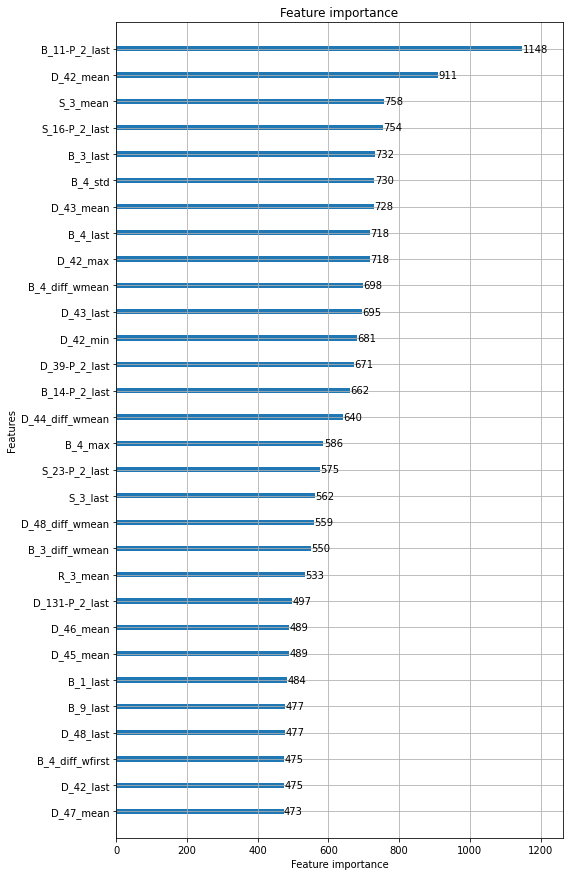

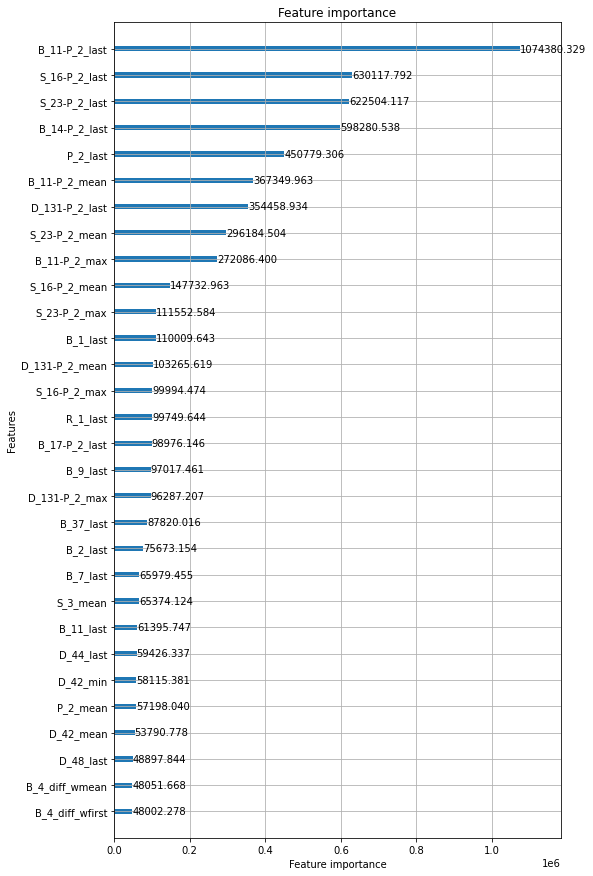

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.754266	valid_0's recall_at4: 0.606985	valid_0's norm_gini: 0.901547


[100]	valid_0's amex_metric: 0.760619	valid_0's recall_at4: 0.614475	valid_0's norm_gini: 0.906763


[150]	valid_0's amex_metric: 0.765052	valid_0's recall_at4: 0.621039	valid_0's norm_gini: 0.909064


[200]	valid_0's amex_metric: 0.767333	valid_0's recall_at4: 0.624321	valid_0's norm_gini: 0.910345


[250]	valid_0's amex_metric: 0.769788	valid_0's recall_at4: 0.627393	valid_0's norm_gini: 0.912182


[300]	valid_0's amex_metric: 0.771941	valid_0's recall_at4: 0.630297	valid_0's norm_gini: 0.913586


[350]	valid_0's amex_metric: 0.773611	valid_0's recall_at4: 0.632569	valid_0's norm_gini: 0.914653


[400]	valid_0's amex_metric: 0.775778	valid_0's recall_at4: 0.636188	valid_0's norm_gini: 0.915368


[450]	valid_0's amex_metric: 0.777361	valid_0's recall_at4: 0.63825	valid_0's norm_gini: 0.916473


[500]	valid_0's amex_metric: 0.779845	valid_0's recall_at4: 0.642079	valid_0's norm_gini: 0.917611


[550]	valid_0's amex_metric: 0.782168	valid_0's recall_at4: 0.64574	valid_0's norm_gini: 0.918595


[600]	valid_0's amex_metric: 0.784558	valid_0's recall_at4: 0.649653	valid_0's norm_gini: 0.919464


[650]	valid_0's amex_metric: 0.785387	valid_0's recall_at4: 0.650915	valid_0's norm_gini: 0.919859


[700]	valid_0's amex_metric: 0.785719	valid_0's recall_at4: 0.651041	valid_0's norm_gini: 0.920397


[750]	valid_0's amex_metric: 0.786751	valid_0's recall_at4: 0.652809	valid_0's norm_gini: 0.920694


[800]	valid_0's amex_metric: 0.787609	valid_0's recall_at4: 0.654155	valid_0's norm_gini: 0.921064


[850]	valid_0's amex_metric: 0.78727	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.92131


[900]	valid_0's amex_metric: 0.787565	valid_0's recall_at4: 0.653482	valid_0's norm_gini: 0.921649


[950]	valid_0's amex_metric: 0.788007	valid_0's recall_at4: 0.654029	valid_0's norm_gini: 0.921984


[1000]	valid_0's amex_metric: 0.788615	valid_0's recall_at4: 0.654955	valid_0's norm_gini: 0.922275


[1050]	valid_0's amex_metric: 0.789632	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.922669


[1100]	valid_0's amex_metric: 0.790447	valid_0's recall_at4: 0.657984	valid_0's norm_gini: 0.922909


[1150]	valid_0's amex_metric: 0.790765	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.923083


[1200]	valid_0's amex_metric: 0.791547	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.923216


[1250]	valid_0's amex_metric: 0.792165	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.9234


[1300]	valid_0's amex_metric: 0.792493	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.923467


[1350]	valid_0's amex_metric: 0.792448	valid_0's recall_at4: 0.661351	valid_0's norm_gini: 0.923546


[1400]	valid_0's amex_metric: 0.792686	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.923684


[1450]	valid_0's amex_metric: 0.793193	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.923814


[1500]	valid_0's amex_metric: 0.793492	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.923907


[1550]	valid_0's amex_metric: 0.793534	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924033


[1600]	valid_0's amex_metric: 0.793237	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.924113


[1650]	valid_0's amex_metric: 0.793584	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.924176


[1700]	valid_0's amex_metric: 0.794119	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924279


[1750]	valid_0's amex_metric: 0.793103	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.92435


[1800]	valid_0's amex_metric: 0.793592	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.924444


[1850]	valid_0's amex_metric: 0.793912	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.924539


[1900]	valid_0's amex_metric: 0.793669	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.924556


[1950]	valid_0's amex_metric: 0.793688	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.924594


[2000]	valid_0's amex_metric: 0.793468	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.924702


[2050]	valid_0's amex_metric: 0.793919	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924803


[2100]	valid_0's amex_metric: 0.794404	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924849


[2150]	valid_0's amex_metric: 0.794293	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.924921


[2200]	valid_0's amex_metric: 0.794032	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.924946


[2250]	valid_0's amex_metric: 0.793812	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.92501


[2300]	valid_0's amex_metric: 0.794053	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.92503


[2350]	valid_0's amex_metric: 0.793817	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.925063


[2400]	valid_0's amex_metric: 0.794229	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.925088


[2450]	valid_0's amex_metric: 0.794879	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.925124


[2500]	valid_0's amex_metric: 0.794576	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.925193


[2550]	valid_0's amex_metric: 0.794445	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.925226


[2600]	valid_0's amex_metric: 0.794469	valid_0's recall_at4: 0.663707	valid_0's norm_gini: 0.92523


[2650]	valid_0's amex_metric: 0.794587	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.925256


[2700]	valid_0's amex_metric: 0.794766	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.925236


[2750]	valid_0's amex_metric: 0.795436	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.925271


[2800]	valid_0's amex_metric: 0.795765	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.925298


[2850]	valid_0's amex_metric: 0.795072	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.925343


[2900]	valid_0's amex_metric: 0.795385	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.925337


[2950]	valid_0's amex_metric: 0.795951	valid_0's recall_at4: 0.666568	valid_0's norm_gini: 0.925333


[3000]	valid_0's amex_metric: 0.795932	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.925337


[3050]	valid_0's amex_metric: 0.796339	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925353


[3100]	valid_0's amex_metric: 0.796282	valid_0's recall_at4: 0.667158	valid_0's norm_gini: 0.925407


[3150]	valid_0's amex_metric: 0.796473	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.92541


[3200]	valid_0's amex_metric: 0.79647	valid_0's recall_at4: 0.667494	valid_0's norm_gini: 0.925446


[3250]	valid_0's amex_metric: 0.796676	valid_0's recall_at4: 0.667873	valid_0's norm_gini: 0.925478


[3300]	valid_0's amex_metric: 0.79598	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925475


[3350]	valid_0's amex_metric: 0.795638	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.925508


[3400]	valid_0's amex_metric: 0.796255	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.925521


[3450]	valid_0's amex_metric: 0.79625	valid_0's recall_at4: 0.666947	valid_0's norm_gini: 0.925552


[3500]	valid_0's amex_metric: 0.796419	valid_0's recall_at4: 0.667284	valid_0's norm_gini: 0.925554


[3550]	valid_0's amex_metric: 0.7963	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.925568


[3600]	valid_0's amex_metric: 0.796452	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925578


[3650]	valid_0's amex_metric: 0.795922	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.925611


[3700]	valid_0's amex_metric: 0.795989	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.92562


[3750]	valid_0's amex_metric: 0.796018	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.925636


[3800]	valid_0's amex_metric: 0.795992	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.925625


[3850]	valid_0's amex_metric: 0.796062	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925639


[3900]	valid_0's amex_metric: 0.796027	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.925654


[3950]	valid_0's amex_metric: 0.796377	valid_0's recall_at4: 0.667073	valid_0's norm_gini: 0.925681


[4000]	valid_0's amex_metric: 0.796349	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.925666


[4050]	valid_0's amex_metric: 0.795741	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.925671


[4100]	valid_0's amex_metric: 0.795867	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.925712


[4150]	valid_0's amex_metric: 0.795749	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.925728


[4200]	valid_0's amex_metric: 0.795681	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.92572


[4250]	valid_0's amex_metric: 0.79539	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.925727


[4300]	valid_0's amex_metric: 0.795742	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.925715


[4350]	valid_0's amex_metric: 0.7961	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925715


[4400]	valid_0's amex_metric: 0.7956	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.925726


[4450]	valid_0's amex_metric: 0.795737	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.925706


[4500]	valid_0's amex_metric: 0.79568	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925718


[4550]	valid_0's amex_metric: 0.795684	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925725


[4600]	valid_0's amex_metric: 0.795503	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.925742


[4650]	valid_0's amex_metric: 0.795715	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.925745


[4700]	valid_0's amex_metric: 0.795696	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.92575


[4750]	valid_0's amex_metric: 0.795702	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925762


[4800]	valid_0's amex_metric: 0.795194	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.925754


[4850]	valid_0's amex_metric: 0.795826	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.925756


[4900]	valid_0's amex_metric: 0.795472	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.925764


[4950]	valid_0's amex_metric: 0.795261	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.925763


[5000]	valid_0's amex_metric: 0.795826	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.925757


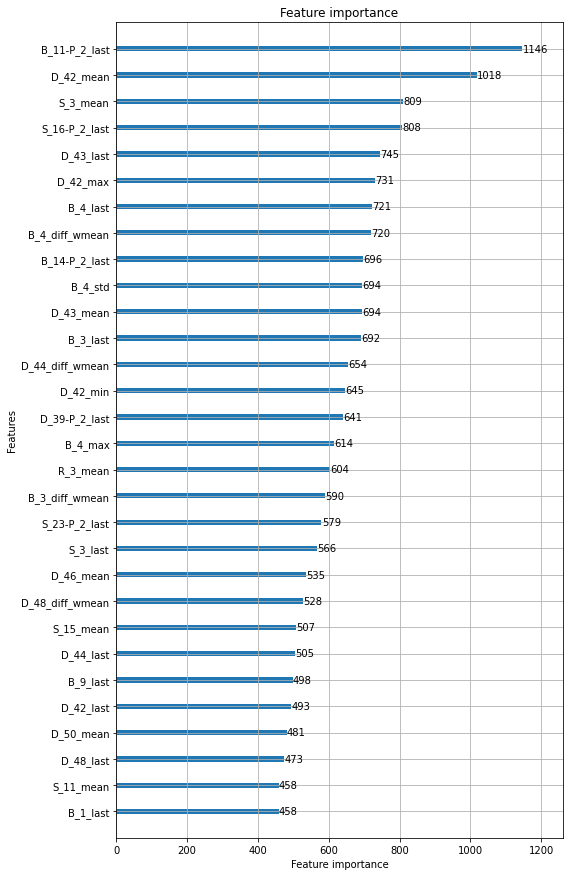

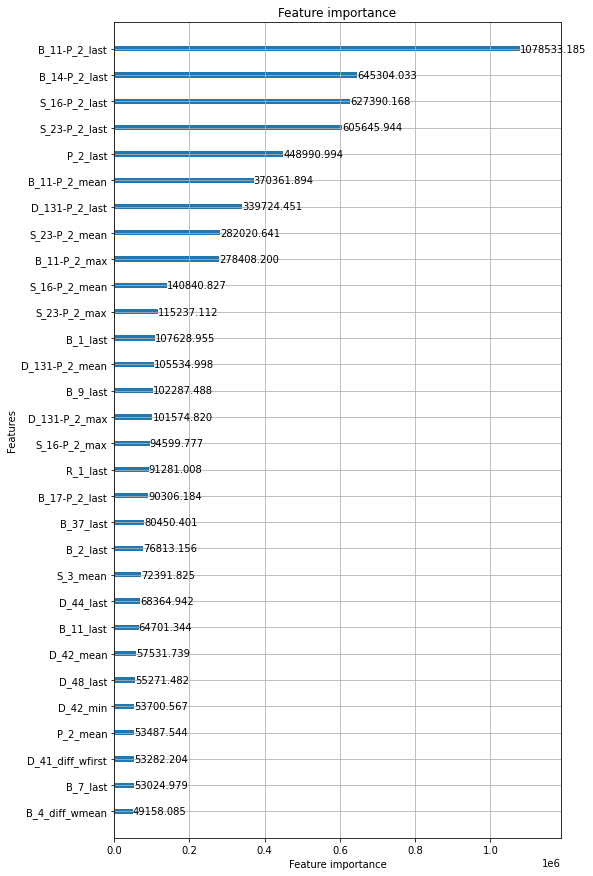

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[50]	valid_0's amex_metric: 0.751632	valid_0's recall_at4: 0.60303	valid_0's norm_gini: 0.900233


[100]	valid_0's amex_metric: 0.758997	valid_0's recall_at4: 0.612624	valid_0's norm_gini: 0.90537


[150]	valid_0's amex_metric: 0.762958	valid_0's recall_at4: 0.618388	valid_0's norm_gini: 0.907527


[200]	valid_0's amex_metric: 0.764546	valid_0's recall_at4: 0.620029	valid_0's norm_gini: 0.909062


[250]	valid_0's amex_metric: 0.76738	valid_0's recall_at4: 0.623901	valid_0's norm_gini: 0.910859


[300]	valid_0's amex_metric: 0.769909	valid_0's recall_at4: 0.627435	valid_0's norm_gini: 0.912383


[350]	valid_0's amex_metric: 0.771256	valid_0's recall_at4: 0.629118	valid_0's norm_gini: 0.913393


[400]	valid_0's amex_metric: 0.771841	valid_0's recall_at4: 0.629623	valid_0's norm_gini: 0.914059


[450]	valid_0's amex_metric: 0.774085	valid_0's recall_at4: 0.632948	valid_0's norm_gini: 0.915223


[500]	valid_0's amex_metric: 0.777135	valid_0's recall_at4: 0.637829	valid_0's norm_gini: 0.916442


[550]	valid_0's amex_metric: 0.779367	valid_0's recall_at4: 0.641237	valid_0's norm_gini: 0.917497


[600]	valid_0's amex_metric: 0.781949	valid_0's recall_at4: 0.645529	valid_0's norm_gini: 0.91837


[650]	valid_0's amex_metric: 0.782007	valid_0's recall_at4: 0.645235	valid_0's norm_gini: 0.918779


[700]	valid_0's amex_metric: 0.783172	valid_0's recall_at4: 0.647044	valid_0's norm_gini: 0.919301


[750]	valid_0's amex_metric: 0.78423	valid_0's recall_at4: 0.648811	valid_0's norm_gini: 0.919649


[800]	valid_0's amex_metric: 0.784832	valid_0's recall_at4: 0.649653	valid_0's norm_gini: 0.920011


[850]	valid_0's amex_metric: 0.785851	valid_0's recall_at4: 0.651336	valid_0's norm_gini: 0.920367


[900]	valid_0's amex_metric: 0.786889	valid_0's recall_at4: 0.653103	valid_0's norm_gini: 0.920675


[950]	valid_0's amex_metric: 0.787351	valid_0's recall_at4: 0.653608	valid_0's norm_gini: 0.921093


[1000]	valid_0's amex_metric: 0.787469	valid_0's recall_at4: 0.653566	valid_0's norm_gini: 0.921372


[1050]	valid_0's amex_metric: 0.7882	valid_0's recall_at4: 0.654618	valid_0's norm_gini: 0.921781


[1100]	valid_0's amex_metric: 0.788361	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.922019


[1150]	valid_0's amex_metric: 0.788218	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.922196


[1200]	valid_0's amex_metric: 0.788739	valid_0's recall_at4: 0.655165	valid_0's norm_gini: 0.922314


[1250]	valid_0's amex_metric: 0.788167	valid_0's recall_at4: 0.653861	valid_0's norm_gini: 0.922474


[1300]	valid_0's amex_metric: 0.788578	valid_0's recall_at4: 0.654618	valid_0's norm_gini: 0.922538


[1350]	valid_0's amex_metric: 0.788608	valid_0's recall_at4: 0.654576	valid_0's norm_gini: 0.922641


[1400]	valid_0's amex_metric: 0.789703	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.922809


[1450]	valid_0's amex_metric: 0.789859	valid_0's recall_at4: 0.656764	valid_0's norm_gini: 0.922954


[1500]	valid_0's amex_metric: 0.789853	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.923026


[1550]	valid_0's amex_metric: 0.790143	valid_0's recall_at4: 0.657101	valid_0's norm_gini: 0.923185


[1600]	valid_0's amex_metric: 0.790531	valid_0's recall_at4: 0.657732	valid_0's norm_gini: 0.923331


[1650]	valid_0's amex_metric: 0.791064	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.923428


[1700]	valid_0's amex_metric: 0.790798	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.923527


[1750]	valid_0's amex_metric: 0.790843	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.923618


[1800]	valid_0's amex_metric: 0.791369	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.923744


[1850]	valid_0's amex_metric: 0.791783	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923815


[1900]	valid_0's amex_metric: 0.791824	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923897


[1950]	valid_0's amex_metric: 0.791597	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.923948


[2000]	valid_0's amex_metric: 0.791622	valid_0's recall_at4: 0.659205	valid_0's norm_gini: 0.924038


[2050]	valid_0's amex_metric: 0.792132	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.924133


[2100]	valid_0's amex_metric: 0.792536	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.924226


[2150]	valid_0's amex_metric: 0.792023	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.924294


[2200]	valid_0's amex_metric: 0.793112	valid_0's recall_at4: 0.661814	valid_0's norm_gini: 0.92441


[2250]	valid_0's amex_metric: 0.793076	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.924465


[2300]	valid_0's amex_metric: 0.79349	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924494


[2350]	valid_0's amex_metric: 0.793279	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.924534


[2400]	valid_0's amex_metric: 0.79354	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.92455


[2450]	valid_0's amex_metric: 0.793904	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.924605


[2500]	valid_0's amex_metric: 0.793874	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.92463


[2550]	valid_0's amex_metric: 0.79384	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924645


[2600]	valid_0's amex_metric: 0.793461	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924646


[2650]	valid_0's amex_metric: 0.79347	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924664


[2700]	valid_0's amex_metric: 0.793134	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.924665


[2750]	valid_0's amex_metric: 0.793498	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.92472


[2800]	valid_0's amex_metric: 0.79339	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.924755


[2850]	valid_0's amex_metric: 0.794072	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.924773


[2900]	valid_0's amex_metric: 0.794198	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924773


[2950]	valid_0's amex_metric: 0.79377	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.924759


[3000]	valid_0's amex_metric: 0.793752	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.924765


[3050]	valid_0's amex_metric: 0.793555	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.924792


[3100]	valid_0's amex_metric: 0.793858	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924808


[3150]	valid_0's amex_metric: 0.793605	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.924807


[3200]	valid_0's amex_metric: 0.793674	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924818


[3250]	valid_0's amex_metric: 0.793728	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.924843


[3300]	valid_0's amex_metric: 0.793688	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924847


[3350]	valid_0's amex_metric: 0.793687	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924846


[3400]	valid_0's amex_metric: 0.793261	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.924834


[3450]	valid_0's amex_metric: 0.793894	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.924839


[3500]	valid_0's amex_metric: 0.793766	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924835


[3550]	valid_0's amex_metric: 0.793489	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.924828


[3600]	valid_0's amex_metric: 0.793429	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.924833


[3650]	valid_0's amex_metric: 0.793473	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.924837


[3700]	valid_0's amex_metric: 0.793033	valid_0's recall_at4: 0.661224	valid_0's norm_gini: 0.924842


[3750]	valid_0's amex_metric: 0.793069	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.924829


[3800]	valid_0's amex_metric: 0.792717	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.924841


[3850]	valid_0's amex_metric: 0.793526	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.92486


[3900]	valid_0's amex_metric: 0.793969	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.924863


[3950]	valid_0's amex_metric: 0.793572	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924867


[4000]	valid_0's amex_metric: 0.793886	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924864


[4050]	valid_0's amex_metric: 0.793785	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924872


[4100]	valid_0's amex_metric: 0.793931	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.924871


[4150]	valid_0's amex_metric: 0.794628	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.924876


[4200]	valid_0's amex_metric: 0.793885	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924862


[4250]	valid_0's amex_metric: 0.793691	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924853


[4300]	valid_0's amex_metric: 0.793759	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.924863


[4350]	valid_0's amex_metric: 0.794067	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.924847


[4400]	valid_0's amex_metric: 0.793805	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.924871


[4450]	valid_0's amex_metric: 0.794261	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.924857


[4500]	valid_0's amex_metric: 0.794	valid_0's recall_at4: 0.66316	valid_0's norm_gini: 0.924841


[4550]	valid_0's amex_metric: 0.793814	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.924847


[4600]	valid_0's amex_metric: 0.793599	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.924838


[4650]	valid_0's amex_metric: 0.793564	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924851


[4700]	valid_0's amex_metric: 0.793499	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.92489


[4750]	valid_0's amex_metric: 0.793734	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.924896


[4800]	valid_0's amex_metric: 0.79367	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.924938


[4850]	valid_0's amex_metric: 0.793645	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.92493


[4900]	valid_0's amex_metric: 0.793595	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924914


[4950]	valid_0's amex_metric: 0.7936	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924923


[5000]	valid_0's amex_metric: 0.793849	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.924916


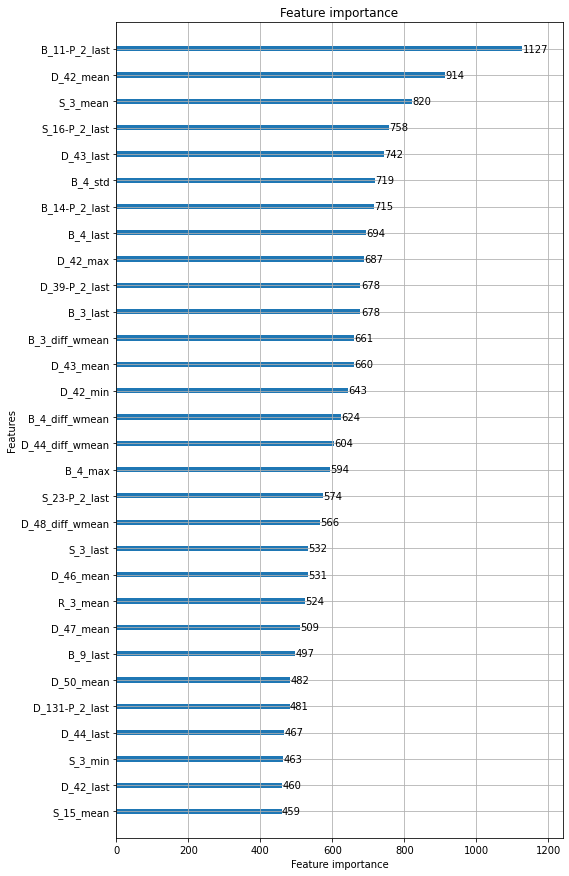

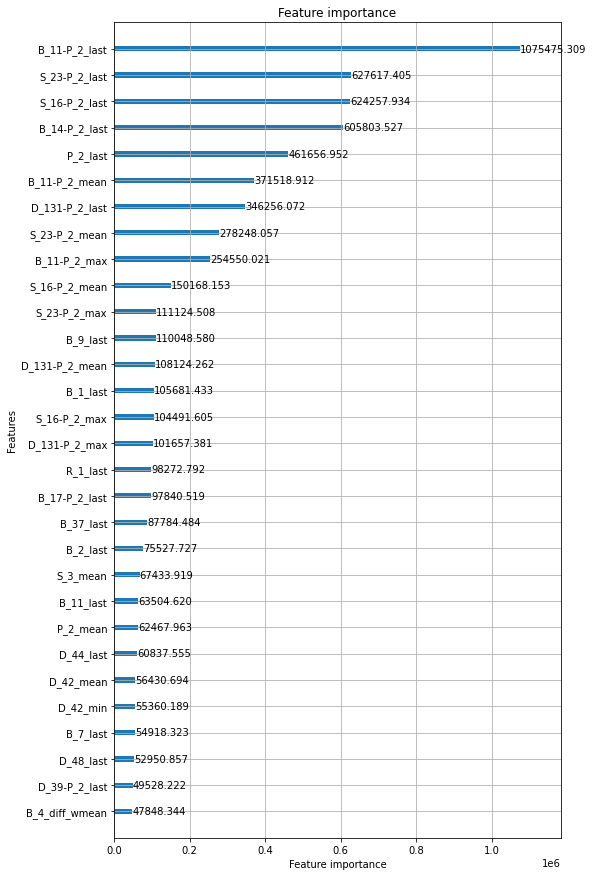

Training time: 120.75662765105565 min.
OOF recall_at4: 0.6695475813781264
OOF normalized_gini: 0.9257410085869979
OOF competition metric: 0.7976442949825622
Finished CV repeat 4 in: 120.0 min.


CPU times: user 6d 4h 34min 27s, sys: 10min 8s, total: 6d 4h 44min 36s
Wall time: 10h 32min 45s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))
    
    tic = time.time()
    
    if "fold" in train.columns:
        train.drop("fold", axis=1, inplace=True)
    folds = pd.read_parquet(f'../data/processed/cv{repetition}.parquet')
    train = pd.merge(train, folds, how="inner", on="customer_id")
    
    tic = time.time()
    models,oof = train_models(train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
          
    all_models.extend(models)
    all_oof_dfs.append(oof)
    
    tac = time.time()
    print(f"Finished CV repeat {repetition} in: {(tac-tic)//60} min.")
    
    try:
        oof.to_csv(f"../data/oof/lgbm-dart-bce-dsv02/oof-cv{repetition}.csv", index=False)
    except:
        pass
          
    del folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

recall_at4      gini    metric
0    0.668512  0.925659  0.797086
1    0.668336  0.925666  0.797001
2    0.668176  0.925737  0.796956
3    0.667864  0.925594  0.796729
4    0.669548  0.925741  0.797644


mean:


recall_at4    0.668487
gini          0.925679
metric        0.797083
dtype: float64


std:


recall_at4    0.000639
gini          0.000061
metric        0.000340
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet("../data/processed/dsv02/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

save_pl = False
path_pl = "../data/subs/lgbm-bce-dsv02-pl/pl/iter0"
all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    imin = repetition*5
    imax = (repetition+1)*5
    
    preds = list()
    for fold,idx in enumerate(range(imin, imax)):
        pred = all_models[idx].predict(test[input_feats])
        if save_pl:
            test["prediction"] = pred
            test[["prediction"]].to_parquet(f"{path_pl}/cv{repetition}/pl-fold{fold}.parquet")
        preds.append(pred)
    all_preds.extend(preds)
       
    test["prediction"] = np.mean(preds, axis=0)
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(f"../data/subs/lgbm-dart-bce-dsv02/submission-cv{repetition}.csv", index=False)

CPU times: user 5h 47s, sys: 1min 34s, total: 5h 2min 22s
Wall time: 23min 6s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(f"../data/subs/lgbm-dart-bce-dsv02/submission-all.csv", index=False)

CPU times: user 3.6 s, sys: 814 ms, total: 4.42 s
Wall time: 4.42 s


***